In [1]:
#Gluonts Package
import gluonts

import scipy as sp
import pandas as pd
import numpy as np
import mxnet as mx
import seaborn as sns
import matplotlib.pyplot as plt
import os

from matplotlib import cm
from typing import Dict, Optional, Tuple, List

from gluonts.model.common import Tensor
from gluonts.core.component import validated
from gluonts.distribution import Distribution, DistributionOutput
from gluonts.distribution.distribution import _sample_multiple, getF, softplus
from gluonts.dataset.common import ListDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.trainer import Trainer
from gluonts.model.canonical._estimator import MLPForecasterEstimator

#S3 Data Package
from aws_poirot_model_benchmark.anomaly_dataset import AnomalyDataset

#SPOT & DSPOT Package
from scipy.optimize import minimize
from math import log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

plt.rcParams['figure.figsize'] = (12.8, 9.6) 

# colors for plot
deep_saffron = '#FF9933'
air_force_blue = '#5D8AA8'

In [2]:
data_list = AnomalyDataset.from_s3("s3://poirot-ad-datasets/order-rate/US/data.json")
d = data_list[0]
d

AnomalyDataset object None with 1347422 data points. 

In [3]:
d[:15000].to_s3("s3://poirot-ad-datasets/order-rate/toy/US/data.json")

In [4]:
import numpy as np
np.array(d.ts).mean()

7974.844943158119

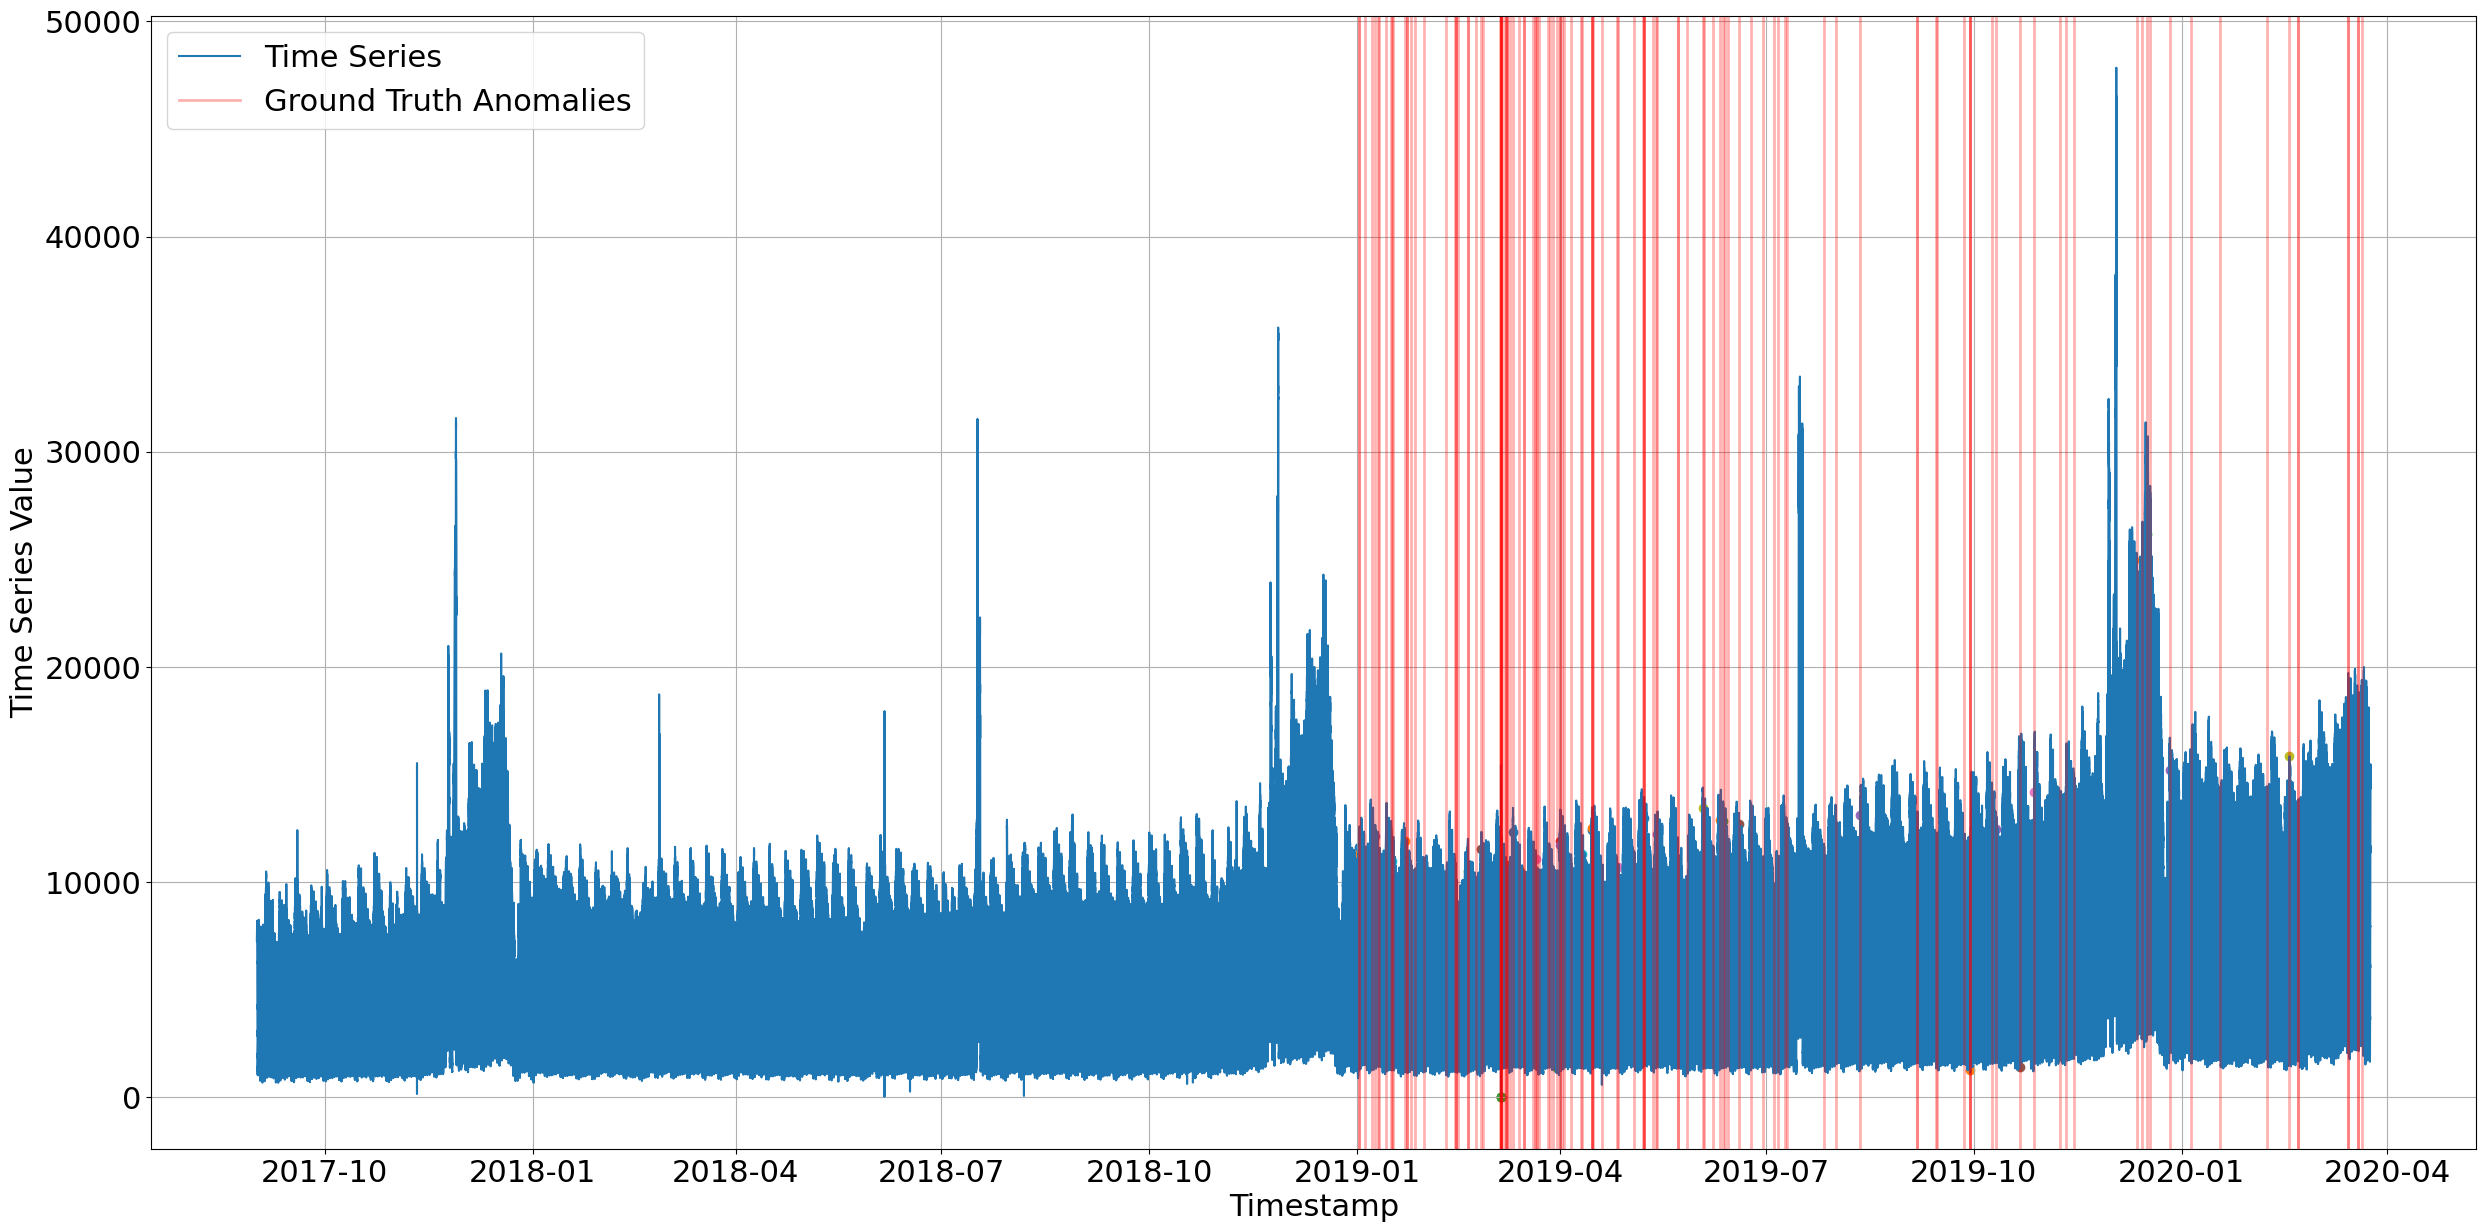

In [5]:
d.plot()

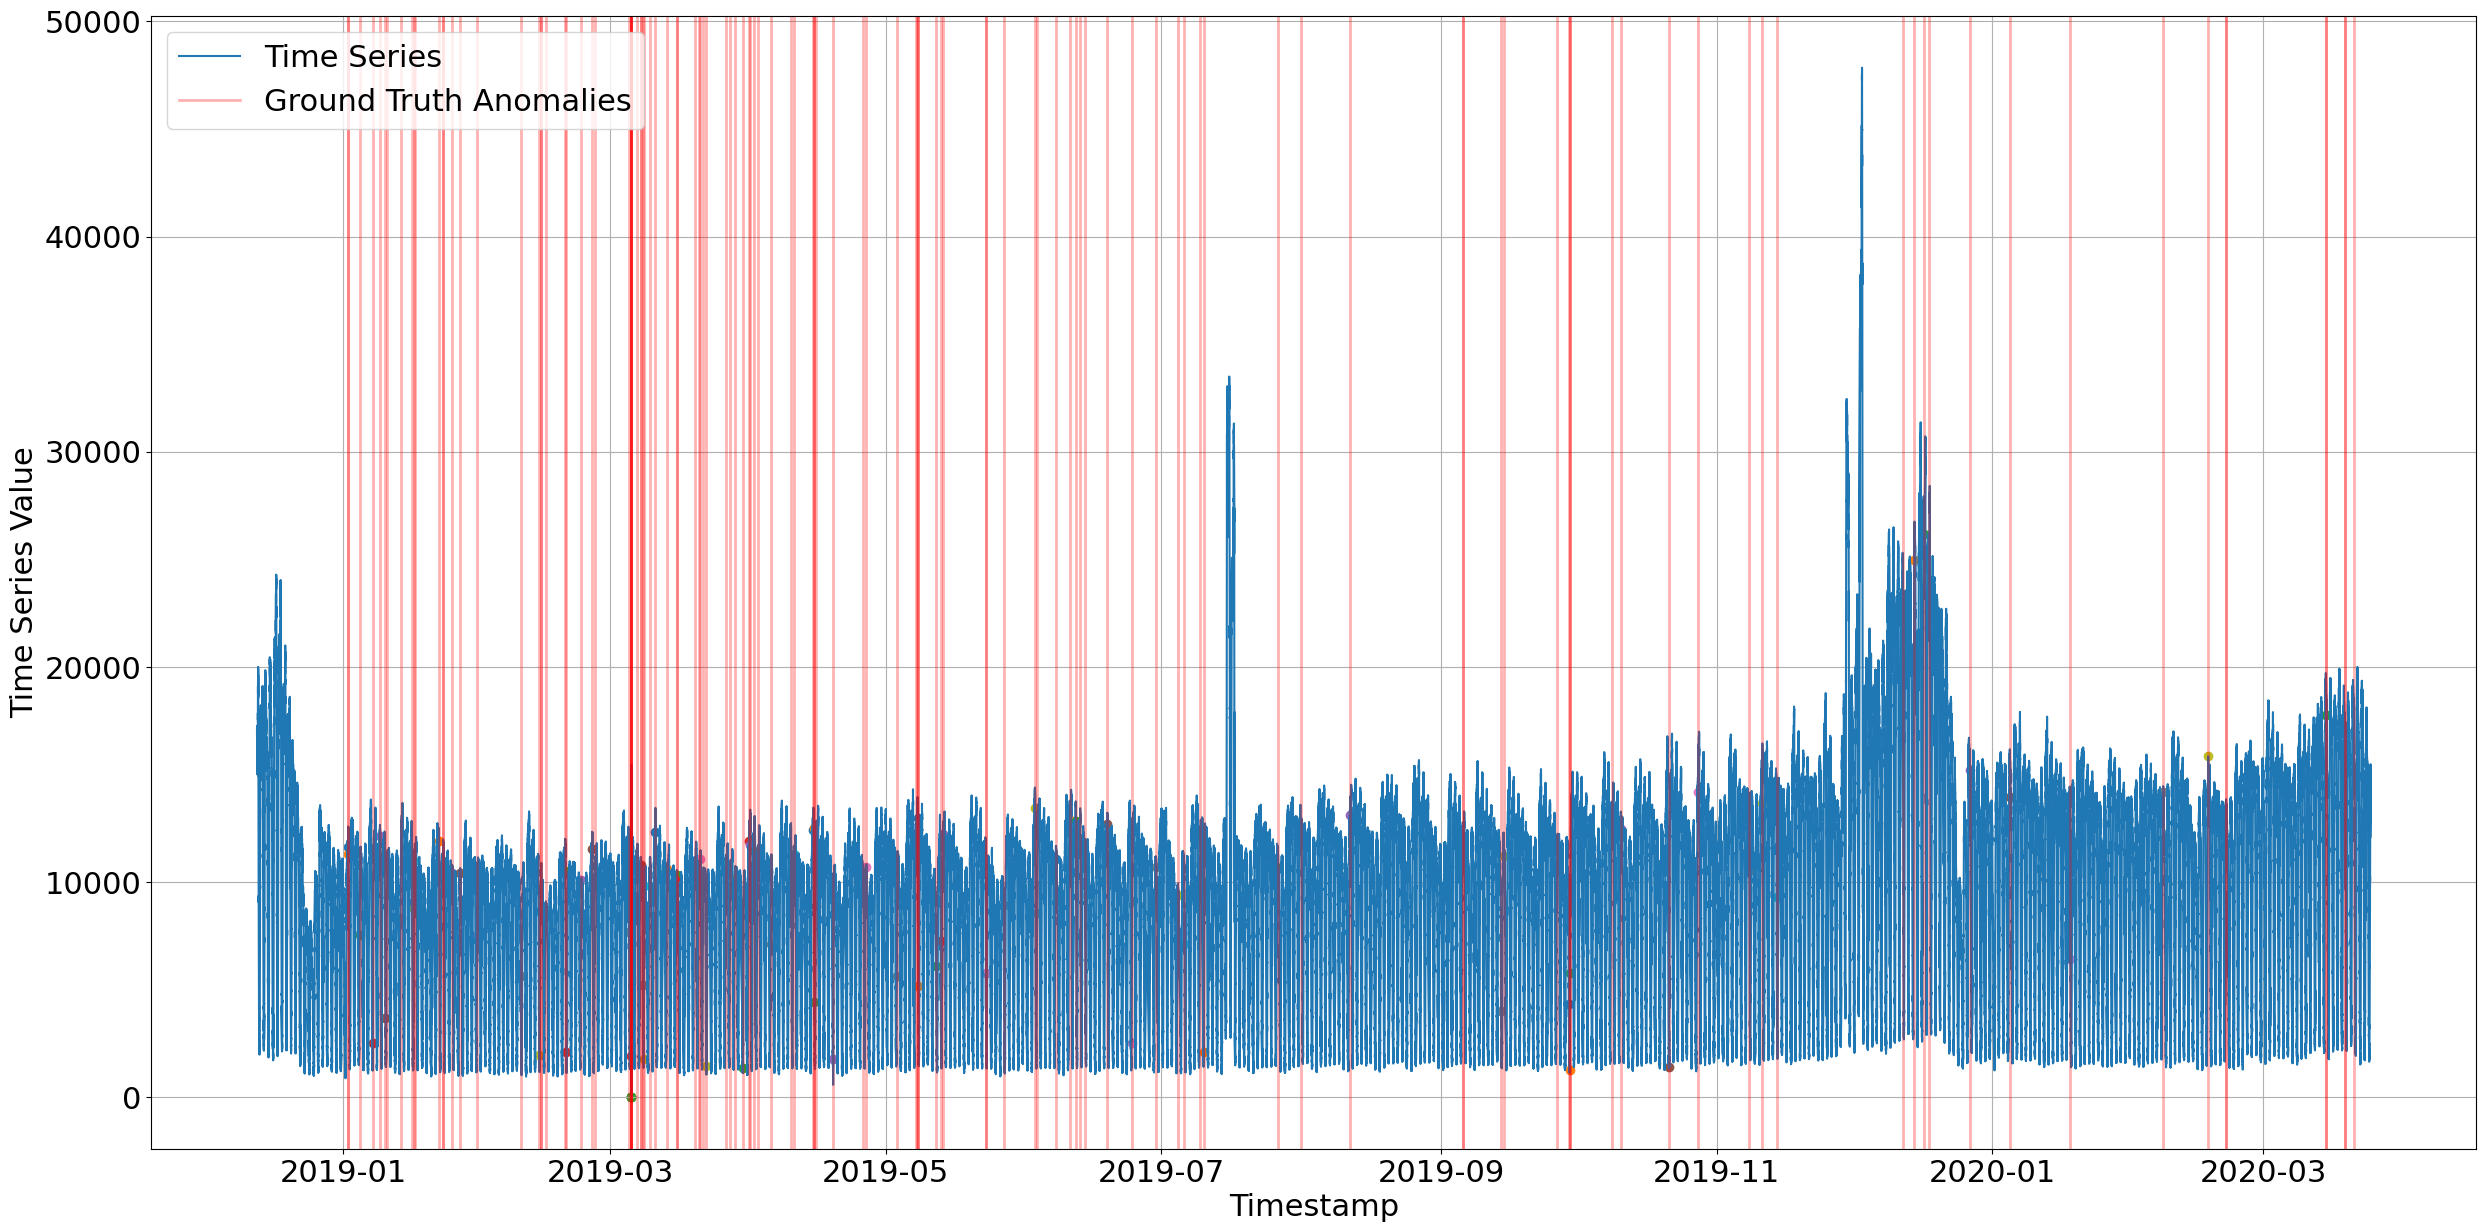

In [6]:
d[len(d)//2:].plot()

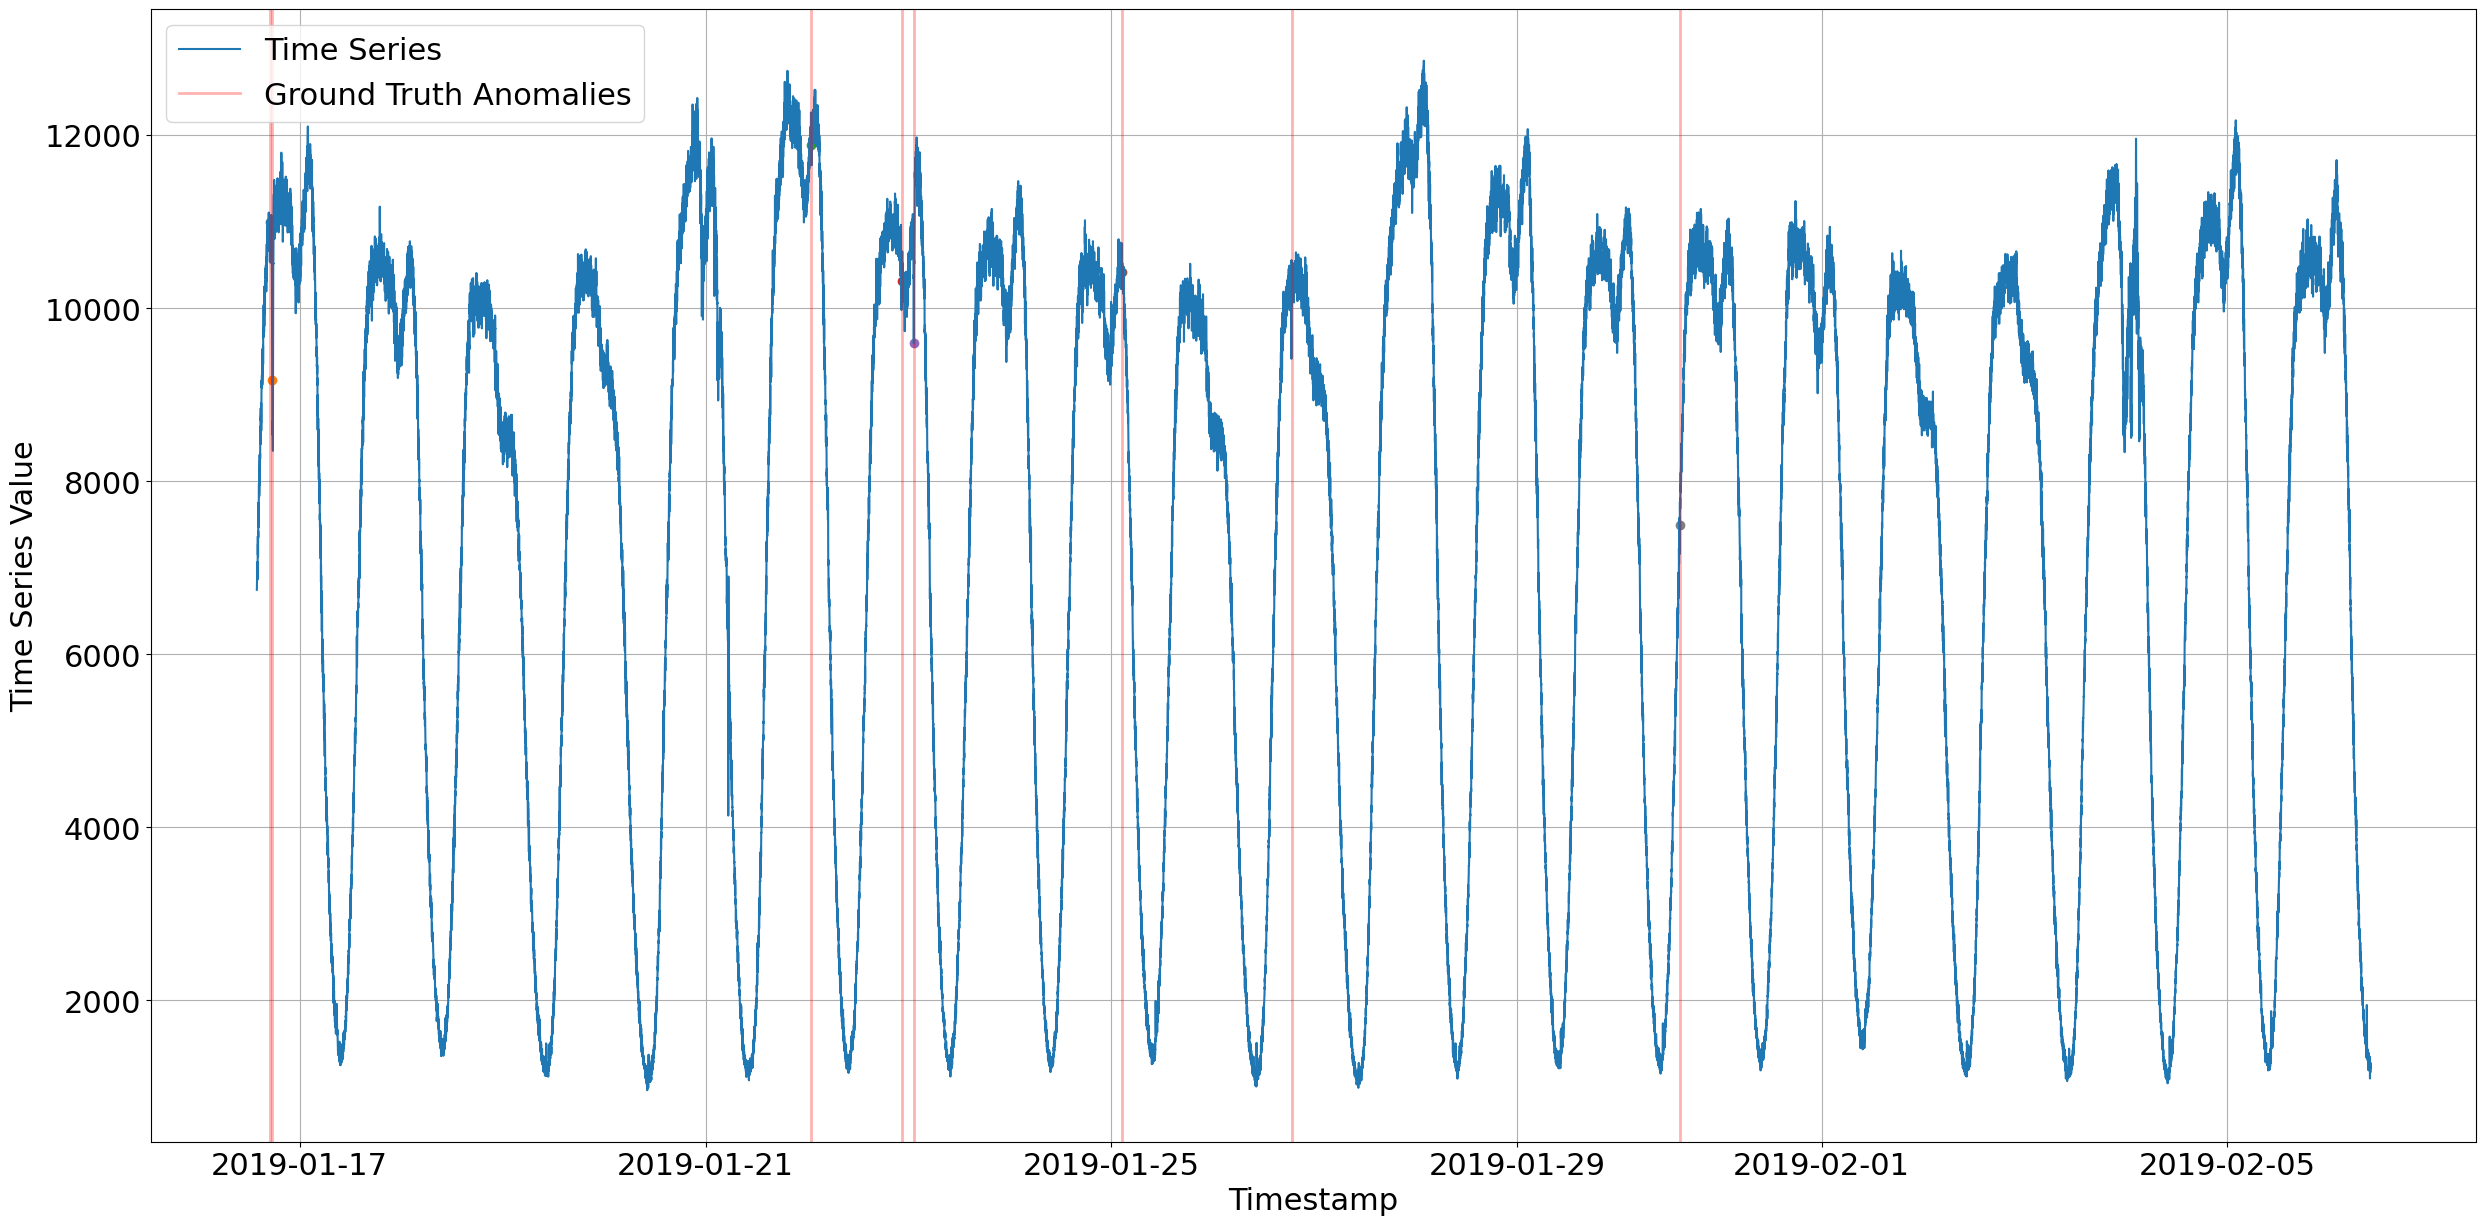

In [7]:
d[len(d)//2+50000:len(d)//2+80000].plot()

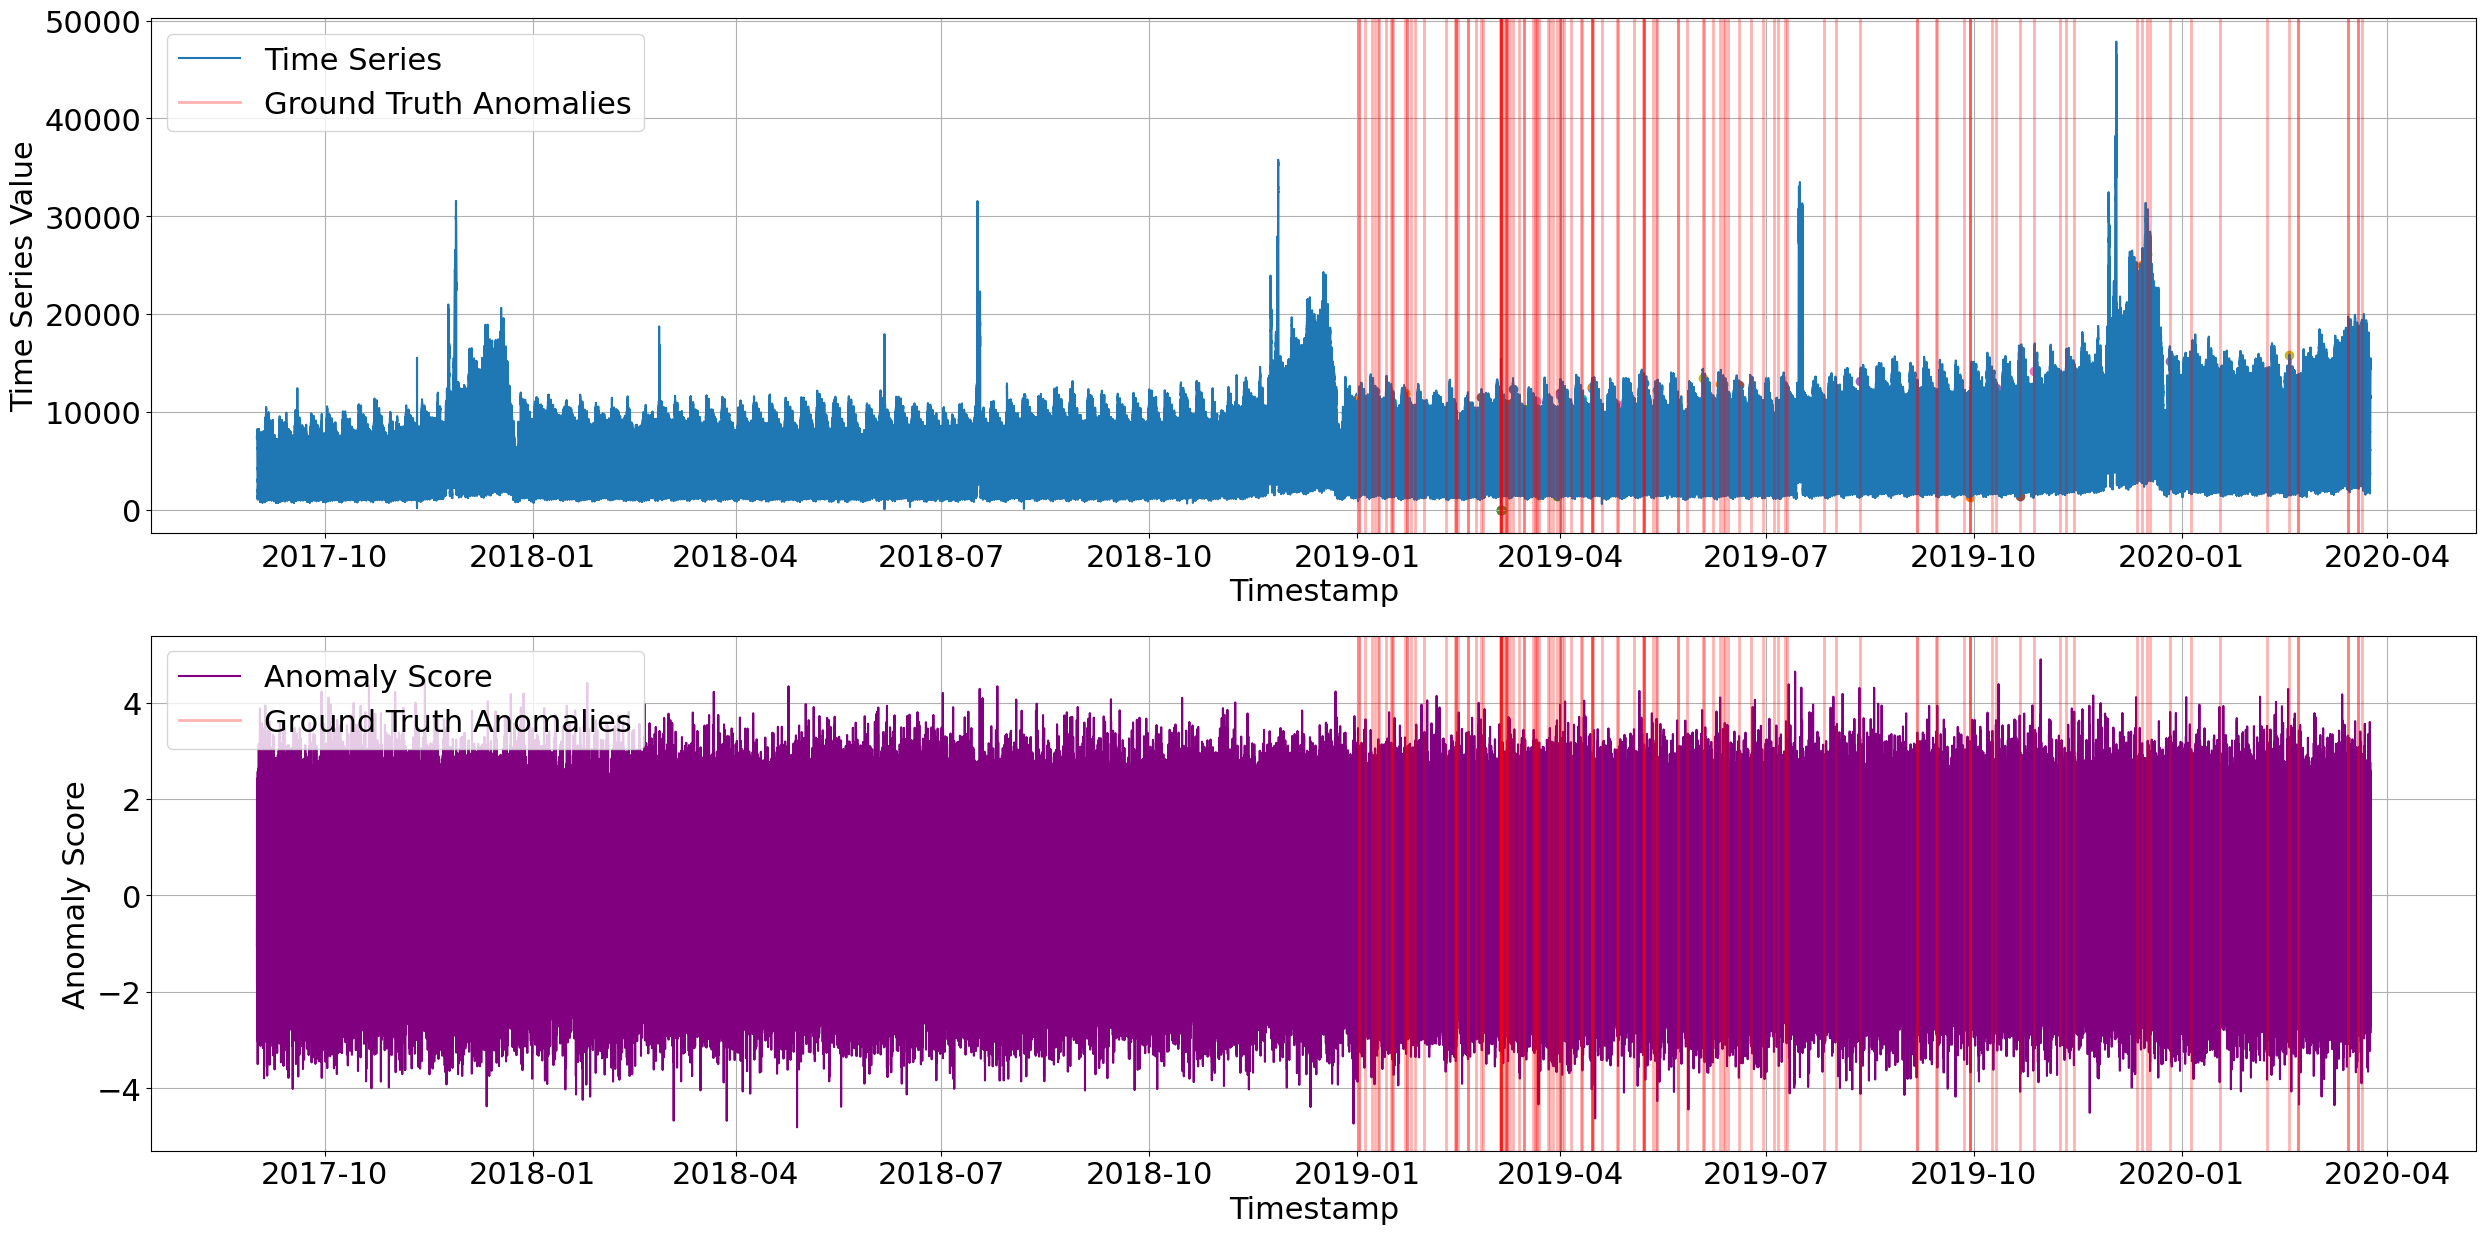

In [8]:
import numpy as np
d.anomaly_score = np.random.normal(size=len(d.ts))
d.plot()

In [9]:
# MARKET_PLACE_LIST = ["AU", "BR", "CA", "DE", "ES", "FR", "IN", "IT", "JP", "MX", "UK", "US"]
# for market in MARKET_PLACE_LIST:
#     print(market)
#     d = AnomalyDataset.from_s3(f"s3://poirot-ad-datasets/order-rate/{market}/data.json")[0]
#     ad = d.get_aggregated_dataset(aggregate_window=5)
#     ad.to_s3(f"s3://poirot-ad-datasets/order-rate/5min/{market}/data.json")

# SPOT

In [10]:
class SPOT:
    """
    This class allows to run SPOT algorithm on univariate dataset (upper-bound)
    
    Attributes
    ----------
    proba : float
        Detection level (risk), chosen by the user
        
    extreme_quantile : float
        current threshold (bound between normal and abnormal events)
        
    data : numpy.array
        stream
    
    init_data : numpy.array
        initial batch of observations (for the calibration/initialization step)
    
    init_threshold : float
        initial threshold computed during the calibration step
    
    peaks : numpy.array
        array of peaks (excesses above the initial threshold)
    
    n : int
        number of observed values
    
    Nt : int
        number of observed peaks
    """
    
    def __init__(self, q = 1e-4):
        """
        Constructor

	    Parameters
	    ----------
	    q
		    Detection level (risk)
	
	    Returns
	    ----------
    	SPOT object
        """
        self.proba = q
        self.extreme_quantile = None
        self.data = None
        self.init_data = None
        self.init_threshold = None
        self.peaks = None
        self.n = 0
        self.Nt = 0
        
    def __str__(self):
        s = ''
        s += 'Streaming Peaks-Over-Threshold Object\n'
        s += 'Detection level q = %s\n' % self.proba
        if self.data is not None:
            s += 'Data imported : Yes\n'
            s += '\t initialization  : %s values\n' % self.init_data.size
            s += '\t stream : %s values\n' % self.data.size
        else:
            s += 'Data imported : No\n'
            return s
            
        if self.n == 0:
            s += 'Algorithm initialized : No\n'
        else:
            s += 'Algorithm initialized : Yes\n'
            s += '\t initial threshold : %s\n' % self.init_threshold
            
            r = self.n-self.init_data.size
            if r > 0:
                s += 'Algorithm run : Yes\n'
                s += '\t number of observations : %s (%.2f %%)\n' % (r,100*r/self.n)
            else:
                s += '\t number of peaks  : %s\n' % self.Nt
                s += '\t extreme quantile : %s\n' % self.extreme_quantile
                s += 'Algorithm run : No\n'
        return s
    
    
    def fit(self,init_data,data):
        """
        Import data to SPOT object
        
        Parameters
	    ----------
	    init_data : list, numpy.array or pandas.Series
		    initial batch to calibrate the algorithm
            
        data : numpy.array
		    data for the run (list, np.array or pd.series)
	
        """
        if isinstance(data,list):
            self.data = np.array(data)
        elif isinstance(data,np.ndarray):
            self.data = data
        elif isinstance(data,pd.Series):
            self.data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
            
        if isinstance(init_data,list):
            self.init_data = np.array(init_data)
        elif isinstance(init_data,np.ndarray):
            self.init_data = init_data
        elif isinstance(init_data,pd.Series):
            self.init_data = init_data.values
        elif isinstance(init_data,int):
            self.init_data = self.data[:init_data]
            self.data = self.data[init_data:]
        elif isinstance(init_data,float) & (init_data<1) & (init_data>0):
            r = int(init_data*data.size)
            self.init_data = self.data[:r]
            self.data = self.data[r:]
        else:
            print('The initial data cannot be set')
            return
        
    def add(self,data):
        """
        This function allows to append data to the already fitted data
        
        Parameters
	    ----------
	    data : list, numpy.array, pandas.Series
		    data to append
        """
        if isinstance(data,list):
            data = np.array(data)
        elif isinstance(data,np.ndarray):
            data = data
        elif isinstance(data,pd.Series):
            data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
        
        self.data = np.append(self.data,data)
        return
    
    def initialize(self, numObser, verbose = True):
        """
        Run the calibration (initialization) step
        
        Parameters
	    ----------
	    verbose : bool
		    (default = True) If True, gives details about the batch initialization
        """
        n_init = self.init_data.size
        
        S = np.sort(self.init_data)     # we sort X to get the empirical quantile
        self.init_threshold = S[int(0.98*n_init)] # t is fixed for the whole algorithm

        # initial peaks
        self.peaks = self.init_data[self.init_data>self.init_threshold]-self.init_threshold 
        self.Nt = self.peaks.size
        self.n = n_init
        
        if verbose:
            print('Initial threshold : %s' % self.init_threshold)
            print('Number of peaks : %s' % self.Nt)
            print('The ratio number of peaks over number of observations : ', float(self.Nt)/float(numObser))
            print('Grimshaw maximum log-likelihood estimation ... ', end = '')
            
        g,s,l = self._grimshaw()
        self.extreme_quantile = self._quantile(g,s)
        
        if verbose:
            print('[done]')
            print('\t'+chr(0x03B3) + ' = ' + str(g))
            print('\t'+chr(0x03C3) + ' = ' + str(s))
            print('\tL = ' + str(l))
            print('Extreme quantile (probability = %s): %s' % (self.proba,self.extreme_quantile))
        
        return 
    
    
    
    
    def _rootsFinder(fun,jac,bounds,npoints,method):
        """
        Find possible roots of a scalar function
        
        Parameters
        ----------
        fun : function
		    scalar function 
        jac : function
            first order derivative of the function  
        bounds : tuple
            (min,max) interval for the roots search    
        npoints : int
            maximum number of roots to output      
        method : str
            'regular' : regular sample of the search interval, 'random' : uniform (distribution) sample of the search interval
        
        Returns
        ----------
        numpy.array
            possible roots of the function
        """
        if method == 'regular':
            step = (bounds[1]-bounds[0])/(npoints+1)
            X0 = np.arange(bounds[0]+step,bounds[1],step)
        elif method == 'random':
            X0 = np.random.uniform(bounds[0],bounds[1],npoints)
        
        def objFun(X,f,jac):
            g = 0
            j = np.zeros(X.shape)
            i = 0
            for x in X:
                fx = f(x)
                g = g+fx**2
                j[i] = 2*fx*jac(x)
                i = i+1
            return g,j
        
        opt = minimize(lambda X:objFun(X,fun,jac), X0, 
                       method='L-BFGS-B', 
                       jac=True, bounds=[bounds]*len(X0))
        
        X = opt.x
        np.round(X,decimals = 5)
        return np.unique(X)
    
    
    def _log_likelihood(Y,gamma,sigma):
        """
        Compute the log-likelihood for the Generalized Pareto Distribution (μ=0)
        
        Parameters
        ----------
        Y : numpy.array
		    observations
        gamma : float
            GPD index parameter
        sigma : float
            GPD scale parameter (>0)   

        Returns
        ----------
        float
            log-likelihood of the sample Y to be drawn from a GPD(γ,σ,μ=0)
        """
        n = Y.size
        if gamma != 0:
            tau = gamma/sigma
            L = -n * log(sigma) - ( 1 + (1/gamma) ) * ( np.log(1+tau*Y) ).sum()
        else:
            L = n * ( 1 + log(Y.mean()) )
        return L


    def _grimshaw(self,epsilon = 1e-8, n_points = 10):
        """
        Compute the GPD parameters estimation with the Grimshaw's trick
        
        Parameters
        ----------
        epsilon : float
		    numerical parameter to perform (default : 1e-8)
        n_points : int
            maximum number of candidates for maximum likelihood (default : 10)

        Returns
        ----------
        gamma_best,sigma_best,ll_best
            gamma estimates, sigma estimates and corresponding log-likelihood
        """
        def u(s):
            return 1 + np.log(s).mean()
            
        def v(s):
            return np.mean(1/s)
        
        def w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            return us*vs-1
        
        def jac_w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            jac_us = (1/t)*(1-vs)
            jac_vs = (1/t)*(-vs+np.mean(1/s**2))
            return us*jac_vs+vs*jac_us
            
    
        Ym = self.peaks.min()
        YM = self.peaks.max()
        Ymean = self.peaks.mean()
        
        
        a = -1/YM
        if abs(a)<2*epsilon:
            epsilon = abs(a)/n_points
        
        a = a + epsilon
        b = 2*(Ymean-Ym)/(Ymean*Ym)
        c = 2*(Ymean-Ym)/(Ym**2)
    
        # We look for possible roots
        left_zeros = SPOT._rootsFinder(lambda t: w(self.peaks,t),
                                 lambda t: jac_w(self.peaks,t),
                                 (a+epsilon,-epsilon),
                                 n_points,'regular')
        
        right_zeros = SPOT._rootsFinder(lambda t: w(self.peaks,t),
                                  lambda t: jac_w(self.peaks,t),
                                  (b,c),
                                  n_points,'regular')
    
        # all the possible roots
        zeros = np.concatenate((left_zeros,right_zeros))
        
        # 0 is always a solution so we initialize with it
        gamma_best = 0
        sigma_best = Ymean
        ll_best = SPOT._log_likelihood(self.peaks,gamma_best,sigma_best)
        
        # we look for better candidates
        for z in zeros:
            gamma = u(1+z*self.peaks)-1
            sigma = gamma/z
            ll = SPOT._log_likelihood(self.peaks,gamma,sigma)
            if ll>ll_best:
                gamma_best = gamma
                sigma_best = sigma
                ll_best = ll
    
        return gamma_best,sigma_best,ll_best

    

    def _quantile(self,gamma,sigma):
        """
        Compute the quantile at level 1-q
        
        Parameters
        ----------
        gamma : float
		    GPD parameter
        sigma : float
            GPD parameter

        Returns
        ----------
        float
            quantile at level 1-q for the GPD(γ,σ,μ=0)
        """
        r = self.n * self.proba / self.Nt
        if gamma != 0:
            return self.init_threshold + (sigma/gamma)*(pow(r,-gamma)-1)
        else:
            return self.init_threshold - sigma*log(r)

        
    def run(self, with_alarm = True):
        """
        Run SPOT on the stream
        
        Parameters
        ----------
        with_alarm : bool
		    (default = True) If False, SPOT will adapt the threshold assuming \
            there is no abnormal values


        Returns
        ----------
        dict
            keys : 'thresholds' and 'alarms'
            
            'thresholds' contains the extreme quantiles and 'alarms' contains \
            the indexes of the values which have triggered alarms
            
        """
        if (self.n>self.init_data.size):
            print('Warning : the algorithm seems to have already been run, you \
            should initialize before running again')
            return {}
        
        # list of the thresholds
        th = []
        alarm = []
        # Loop over the stream
        for i in tqdm.tqdm(range(self.data.size)):
    
            # If the observed value exceeds the current threshold (alarm case)
            if self.data[i]>self.extreme_quantile:
                # if we want to alarm, we put it in the alarm list
                if with_alarm:
                    alarm.append(i)
                # otherwise we add it in the peaks
                else:
                    self.peaks = np.append(self.peaks,self.data[i]-self.init_threshold)
                    self.Nt += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw()
                    self.extreme_quantile = self._quantile(g,s)

            # case where the value exceeds the initial threshold but not the alarm ones
            elif self.data[i]>self.init_threshold:
                    # we add it in the peaks
                    self.peaks = np.append(self.peaks,self.data[i]-self.init_threshold)
                    self.Nt += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw()
                    self.extreme_quantile = self._quantile(g,s)
            else:
                self.n += 1

                
            th.append(self.extreme_quantile) # thresholds record
        
        return {'thresholds' : th, 'alarms': alarm}
    

    def plot(self,run_results,with_alarm = True):
        """
        Plot the results of given by the run
        
        Parameters
        ----------
        run_results : dict
            results given by the 'run' method
        with_alarm : bool
		    (default = True) If True, alarms are plotted.


        Returns
        ----------
        list
            list of the plots
            
        """
        x = range(self.data.size)
        K = run_results.keys()
        
        ts_fig, = plt.plot(x,self.data,color=air_force_blue)
        fig = [ts_fig]
        
        if 'thresholds' in K:
            th = run_results['thresholds']
            th_fig, = plt.plot(x,th,color=deep_saffron,lw=2,ls='dashed')
            fig.append(th_fig)
        
        if with_alarm and ('alarms' in K):
            alarm = run_results['alarms']
            al_fig = plt.scatter(alarm,self.data[alarm],color='red')
            fig.append(al_fig)
            
        plt.xlim((0,self.data.size))

        
        return fig
    
    def plotErrorRate(self,zth,run_results,with_alarm = True):
        """
        Plot the error rate of given by the run
        
        Parameters
        ----------
        run_results : dict
            results given by the 'run' method
        with_alarm : bool
		    (default = True) If True, alarms are plotted.


        Returns
        ----------
        list
            list of the plots
            
        """
        x = range(self.data.size)
        K = run_results.keys()
        fig = []
        errorRate = []
        
        if 'thresholds' in K:
            th = run_results['thresholds']
            for i in range(len(th)):
                errorRate.append(abs(th[i]-zth/zth))
            th_fig, = plt.plot(x,errorRate,color=air_force_blue)
            fig.append(th_fig)
            
        plt.xlim((0,self.data.size))
        
        return fig
    def calPosiRate(self,run_results,with_alarm = True):
        """
        Plot the error rate of given by the run
        
        Parameters
        ----------
        run_results : dict
            results given by the 'run' method
        with_alarm : bool
		    (default = True) If True, alarms are plotted.


        Returns
        ----------
        list
            list of the plots
            
        """
        K = run_results.keys()
        truePosi = 0
        falsePosi = 0
        alarmNum = 0
        notExtreme = 0
        
        if 'thresholds' in K:
            th = run_results['thresholds']
            for i in range(len(th)):
                if self.data[i] > th[i]:
                    truePosi = truePosi + 1
                    if self.data[i] <= self.extreme_quantile:
                        notExtreme = notExtreme + 1
                else:
                    falsePosi = falsePosi + 1
        if with_alarm and ('alarms' in K):
            alarm = run_results['alarms']
            alarmNum = len(alarm)
        
        return truePosi, falsePosi, alarmNum, notExtreme

# biSPOT

In [11]:
class biSPOT:
    """
    This class allows to run biSPOT algorithm on univariate dataset (upper and lower bounds)
    
    Attributes
    ----------
    proba : float
        Detection level (risk), chosen by the user
        
    extreme_quantile : float
        current threshold (bound between normal and abnormal events)
        
    data : numpy.array
        stream
    
    init_data : numpy.array
        initial batch of observations (for the calibration/initialization step)
    
    init_threshold : float
        initial threshold computed during the calibration step
    
    peaks : numpy.array
        array of peaks (excesses above the initial threshold)
    
    n : int
        number of observed values
    
    Nt : int
        number of observed peaks
    """
    def __init__(self, q = 1e-4):
        """
        Constructor

	    Parameters
	    ----------
	    q
		    Detection level (risk)
	
	    Returns
	    ----------
        biSPOT object
        """
        self.proba = q
        self.data = None
        self.init_data = None
        self.n = 0
        nonedict =  {'up':None,'down':None}
        
        self.extreme_quantile = dict.copy(nonedict)
        self.init_threshold = dict.copy(nonedict)
        self.peaks = dict.copy(nonedict)
        self.gamma = dict.copy(nonedict)
        self.sigma = dict.copy(nonedict)
        self.Nt = {'up':0,'down':0}
        
        
    def __str__(self):
        s = ''
        s += 'Streaming Peaks-Over-Threshold Object\n'
        s += 'Detection level q = %s\n' % self.proba
        if self.data is not None:
            s += 'Data imported : Yes\n'
            s += '\t initialization  : %s values\n' % self.init_data.size
            s += '\t stream : %s values\n' % self.data.size
        else:
            s += 'Data imported : No\n'
            return s
            
        if self.n == 0:
            s += 'Algorithm initialized : No\n'
        else:
            s += 'Algorithm initialized : Yes\n'
            s += '\t initial threshold : %s\n' % self.init_threshold
            
            r = self.n-self.init_data.size
            if r > 0:
                s += 'Algorithm run : Yes\n'
                s += '\t number of observations : %s (%.2f %%)\n' % (r,100*r/self.n)
                s += '\t triggered alarms : %s (%.2f %%)\n' % (len(self.alarm),100*len(self.alarm)/self.n)
            else:
                s += '\t number of peaks  : %s\n' % self.Nt
                s += '\t upper extreme quantile : %s\n' % self.extreme_quantile['up']
                s += '\t lower extreme quantile : %s\n' % self.extreme_quantile['down']
                s += 'Algorithm run : No\n'
        return s
    
    
    def fit(self,init_data,data):
        """
        Import data to biSPOT object
        
        Parameters
	    ----------
	    init_data : list, numpy.array or pandas.Series
		    initial batch to calibrate the algorithm ()
            
        data : numpy.array
		    data for the run (list, np.array or pd.series)
	
        """
        if isinstance(data,list):
            self.data = np.array(data)
        elif isinstance(data,np.ndarray):
            self.data = data
        elif isinstance(data,pd.Series):
            self.data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
            
        if isinstance(init_data,list):
            self.init_data = np.array(init_data)
        elif isinstance(init_data,np.ndarray):
            self.init_data = init_data
        elif isinstance(init_data,pd.Series):
            self.init_data = init_data.values
        elif isinstance(init_data,int):
            self.init_data = self.data[:init_data]
            self.data = self.data[init_data:]
        elif isinstance(init_data,float) & (init_data<1) & (init_data>0):
            r = int(init_data*data.size)
            self.init_data = self.data[:r]
            self.data = self.data[r:]
        else:
            print('The initial data cannot be set')
            return
        
    def add(self,data):
        """
        This function allows to append data to the already fitted data
        
        Parameters
	    ----------
	    data : list, numpy.array, pandas.Series
		    data to append
        """
        if isinstance(data,list):
            data = np.array(data)
        elif isinstance(data,np.ndarray):
            data = data
        elif isinstance(data,pd.Series):
            data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
        
        self.data = np.append(self.data,data)
        return

    def initialize(self, numObser, verbose = True):
        """
        Run the calibration (initialization) step
        
        Parameters
	    ----------
	    verbose : bool
		    (default = True) If True, gives details about the batch initialization
        """
        n_init = self.init_data.size
        
        S = np.sort(self.init_data)     # we sort X to get the empirical quantile
        self.init_threshold['up'] = S[int(0.98*n_init)] # t is fixed for the whole algorithm
        self.init_threshold['down'] = S[int(0.02*n_init)] # t is fixed for the whole algorithm

        # initial peaks
        self.peaks['up'] = self.init_data[self.init_data>self.init_threshold['up']]-self.init_threshold['up']
        self.peaks['down'] = -(self.init_data[self.init_data<self.init_threshold['down']]-self.init_threshold['down'])
        self.Nt['up'] = self.peaks['up'].size
        self.Nt['down'] = self.peaks['down'].size
        self.n = n_init
        
        if verbose:
            print('Initial threshold : %s' % self.init_threshold)
            print('Number of peaks : %s' % self.Nt)
            print('The ratio number of peaks over number of observations : ', float(self.Nt['up']+self.Nt['down'])/float(numObser))
            print('Grimshaw maximum log-likelihood estimation ... ', end = '')
            
        l = {'up':None,'down':None}
        for side in ['up','down']:
            g,s,l[side] = self._grimshaw(side)
            self.extreme_quantile[side] = self._quantile(side,g,s)
            self.gamma[side] = g
            self.sigma[side] = s
        
        ltab = 20
        form = ('\t'+'%20s' + '%20.2f' + '%20.2f')
        if verbose:
            print('[done]')
            print('\t' + 'Parameters'.rjust(ltab) + 'Upper'.rjust(ltab) + 'Lower'.rjust(ltab))
            print('\t' + '-'*ltab*3)
            print(form % (chr(0x03B3),self.gamma['up'],self.gamma['down']))
            print(form % (chr(0x03C3),self.sigma['up'],self.sigma['down']))
            print(form % ('likelihood',l['up'],l['down']))
            print(form % ('Extreme quantile',self.extreme_quantile['up'],self.extreme_quantile['down']))
            print('\t' + '-'*ltab*3)
        return 
    
    
    
    
    def _rootsFinder(fun,jac,bounds,npoints,method):
        """
        Find possible roots of a scalar function
        
        Parameters
        ----------
        fun : function
		    scalar function 
        jac : function
            first order derivative of the function  
        bounds : tuple
            (min,max) interval for the roots search    
        npoints : int
            maximum number of roots to output      
        method : str
            'regular' : regular sample of the search interval, 'random' : uniform (distribution) sample of the search interval
        
        Returns
        ----------
        numpy.array
            possible roots of the function
        """
        if method == 'regular':
            step = (bounds[1]-bounds[0])/(npoints+1)
            X0 = np.arange(bounds[0]+step,bounds[1],step)
        elif method == 'random':
            X0 = np.random.uniform(bounds[0],bounds[1],npoints)
        
        def objFun(X,f,jac):
            g = 0
            j = np.zeros(X.shape)
            i = 0
            for x in X:
                fx = f(x)
                g = g+fx**2
                j[i] = 2*fx*jac(x)
                i = i+1
            return g,j
        opt = minimize(lambda X:objFun(X,fun,jac), X0, 
                       method='L-BFGS-B', 
                       jac=True, bounds=[bounds]*len(X0))
        
        X = opt.x
        np.round(X,decimals = 5)
        return np.unique(X)
    
    
    def _log_likelihood(Y,gamma,sigma):
        """
        Compute the log-likelihood for the Generalized Pareto Distribution (μ=0)
        
        Parameters
        ----------
        Y : numpy.array
		    observations
        gamma : float
            GPD index parameter
        sigma : float
            GPD scale parameter (>0)   

        Returns
        ----------
        float
            log-likelihood of the sample Y to be drawn from a GPD(γ,σ,μ=0)
        """
        n = Y.size
        if gamma != 0:
            tau = gamma/sigma
            L = -n * log(sigma) - ( 1 + (1/gamma) ) * ( np.log(1+tau*Y) ).sum()
        else:
            L = n * ( 1 + log(Y.mean()) )
        return L


    def _grimshaw(self,side,epsilon = 1e-8, n_points = 10):
        """
        Compute the GPD parameters estimation with the Grimshaw's trick
        
        Parameters
        ----------
        epsilon : float
		    numerical parameter to perform (default : 1e-8)
        n_points : int
            maximum number of candidates for maximum likelihood (default : 10)

        Returns
        ----------
        gamma_best,sigma_best,ll_best
            gamma estimates, sigma estimates and corresponding log-likelihood
        """
        def u(s):
            return 1 + np.log(s).mean()
            
        def v(s):
            return np.mean(1/s)
        
        def w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            return us*vs-1
        
        def jac_w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            jac_us = (1/t)*(1-vs)
            jac_vs = (1/t)*(-vs+np.mean(1/s**2))
            return us*jac_vs+vs*jac_us
            
    
        Ym = self.peaks[side].min()
        YM = self.peaks[side].max()
        Ymean = self.peaks[side].mean()
        
        
        a = -1/YM
        if abs(a)<2*epsilon:
            epsilon = abs(a)/n_points
        
        a = a + epsilon
        b = 2*(Ymean-Ym)/(Ymean*Ym)
        c = 2*(Ymean-Ym)/(Ym**2)
    
        # We look for possible roots
        left_zeros = biSPOT._rootsFinder(lambda t: w(self.peaks[side],t),
                                 lambda t: jac_w(self.peaks[side],t),
                                 (a+epsilon,-epsilon),
                                 n_points,'regular')
        
        right_zeros = biSPOT._rootsFinder(lambda t: w(self.peaks[side],t),
                                  lambda t: jac_w(self.peaks[side],t),
                                  (b,c),
                                  n_points,'regular')
    
        # all the possible roots
        zeros = np.concatenate((left_zeros,right_zeros))
        
        # 0 is always a solution so we initialize with it
        gamma_best = 0
        sigma_best = Ymean
        ll_best = biSPOT._log_likelihood(self.peaks[side],gamma_best,sigma_best)
        
        # we look for better candidates
        for z in zeros:
            gamma = u(1+z*self.peaks[side])-1
            sigma = gamma/z
            ll = biSPOT._log_likelihood(self.peaks[side],gamma,sigma)
            if ll>ll_best:
                gamma_best = gamma
                sigma_best = sigma
                ll_best = ll
    
        return gamma_best,sigma_best,ll_best

    

    def _quantile(self,side,gamma,sigma):
        """
        Compute the quantile at level 1-q for a given side
        
        Parameters
        ----------
        side : str
            'up' or 'down'
        gamma : float
		    GPD parameter
        sigma : float
            GPD parameter

        Returns
        ----------
        float
            quantile at level 1-q for the GPD(γ,σ,μ=0)
        """
        if side == 'up':
            r = self.n * self.proba / self.Nt[side]
            if gamma != 0:
                return self.init_threshold['up'] + (sigma/gamma)*(pow(r,-gamma)-1)
            else:
                return self.init_threshold['up'] - sigma*log(r)
        elif side == 'down':
            r = self.n * self.proba / self.Nt[side]
            if gamma != 0:
                return self.init_threshold['down'] - (sigma/gamma)*(pow(r,-gamma)-1)
            else:
                return self.init_threshold['down'] + sigma*log(r)
        else:
            print('error : the side is not right')

        
    def run(self, with_alarm = True):
        """
        Run biSPOT on the stream
        
        Parameters
        ----------
        with_alarm : bool
		    (default = True) If False, SPOT will adapt the threshold assuming \
            there is no abnormal values


        Returns
        ----------
        dict
            keys : 'upper_thresholds', 'lower_thresholds' and 'alarms'
            
            '***-thresholds' contains the extreme quantiles and 'alarms' contains \
            the indexes of the values which have triggered alarms
            
        """
        if (self.n>self.init_data.size):
            print('Warning : the algorithm seems to have already been run, you \
            should initialize before running again')
            return {}
        
        # list of the thresholds
        thup = []
        thdown = []
        alarm = []
        # Loop over the stream
        for i in tqdm.tqdm(range(self.data.size)):
    
            # If the observed value exceeds the current threshold (alarm case)
            if self.data[i]>self.extreme_quantile['up'] :
                # if we want to alarm, we put it in the alarm list
                if with_alarm:
                    alarm.append(i)
                # otherwise we add it in the peaks
                else:
                    self.peaks['up'] = np.append(self.peaks['up'],self.data[i]-self.init_threshold['up'])
                    self.Nt['up'] += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw('up')
                    self.extreme_quantile['up'] = self._quantile('up',g,s)

            # case where the value exceeds the initial threshold but not the alarm ones
            elif self.data[i]>self.init_threshold['up']:
                    # we add it in the peaks
                    self.peaks['up'] = np.append(self.peaks['up'],self.data[i]-self.init_threshold['up'])
                    self.Nt['up'] += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw('up')
                    self.extreme_quantile['up'] = self._quantile('up',g,s)
                    
            elif self.data[i]<self.extreme_quantile['down'] :
                # if we want to alarm, we put it in the alarm list
                if with_alarm:
                    alarm.append(i)
                # otherwise we add it in the peaks
                else:
                    self.peaks['down'] = np.append(self.peaks['down'],-(self.data[i]-self.init_threshold['down']))
                    self.Nt['down'] += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw('down')
                    self.extreme_quantile['down'] = self._quantile('down',g,s)

            # case where the value exceeds the initial threshold but not the alarm ones
            elif self.data[i]<self.init_threshold['down']:
                    # we add it in the peaks
                    self.peaks['down'] = np.append(self.peaks['down'],-(self.data[i]-self.init_threshold['down']))
                    self.Nt['down'] += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw('down')
                    self.extreme_quantile['down'] = self._quantile('down',g,s)
            else:
                self.n += 1

                
            thup.append(self.extreme_quantile['up']) # thresholds record
            thdown.append(self.extreme_quantile['down']) # thresholds record
        
        return {'upper_thresholds' : thup,'lower_thresholds' : thdown, 'alarms': alarm}
    
    def plot(self,run_results,with_alarm = True):
        """
        Plot the results of given by the run
        
        Parameters
        ----------
        run_results : dict
            results given by the 'run' method
        with_alarm : bool
		    (default = True) If True, alarms are plotted.


        Returns
        ----------
        list
            list of the plots
            
        """
        x = range(self.data.size)
        K = run_results.keys()
        
        ts_fig, = plt.plot(x,self.data,color=air_force_blue)
        fig = [ts_fig]
        
        if 'upper_thresholds' in K:
            thup = run_results['upper_thresholds']
            uth_fig, = plt.plot(x,thup,color=deep_saffron,lw=2,ls='dashed')
            fig.append(uth_fig)
            
        if 'lower_thresholds' in K:
            thdown = run_results['lower_thresholds']
            lth_fig, = plt.plot(x,thdown,color=deep_saffron,lw=2,ls='dashed')
            fig.append(lth_fig)
        
        if with_alarm and ('alarms' in K):
            alarm = run_results['alarms']
            al_fig = plt.scatter(alarm,self.data[alarm],color='red')
            fig.append(al_fig)
            
        plt.xlim((0,self.data.size))

        
        return fig

# WITH DRIFT

In [12]:
def backMean(X,d):
    M = []
    w = X[:d].sum()
    M.append(w/d)
    for i in range(d,len(X)):
        w = w - X[i-d] + X[i]
        M.append(w/d)
    return np.array(M)

# DSPOT

In [13]:
class dSPOT:
    """
    This class allows to run DSPOT algorithm on univariate dataset (upper-bound)
    
    Attributes
    ----------
    proba : float
        Detection level (risk), chosen by the user
        
    depth : int
        Number of observations to compute the moving average
        
    extreme_quantile : float
        current threshold (bound between normal and abnormal events)
        
    data : numpy.array
        stream
    
    init_data : numpy.array
        initial batch of observations (for the calibration/initialization step)
    
    init_threshold : float
        initial threshold computed during the calibration step
    
    peaks : numpy.array
        array of peaks (excesses above the initial threshold)
    
    n : int
        number of observed values
    
    Nt : int
        number of observed peaks
    """
    def __init__(self, q, depth):
        self.proba = q
        self.extreme_quantile = None
        self.data = None
        self.init_data = None
        self.init_threshold = None
        self.peaks = None
        self.n = 0
        self.Nt = 0
        self.depth = depth
        
    def __str__(self):
        s = ''
        s += 'Streaming Peaks-Over-Threshold Object\n'
        s += 'Detection level q = %s\n' % self.proba
        if self.data is not None:
            s += 'Data imported : Yes\n'
            s += '\t initialization  : %s values\n' % self.init_data.size
            s += '\t stream : %s values\n' % self.data.size
        else:
            s += 'Data imported : No\n'
            return s
            
        if self.n == 0:
            s += 'Algorithm initialized : No\n'
        else:
            s += 'Algorithm initialized : Yes\n'
            s += '\t initial threshold : %s\n' % self.init_threshold
            
            r = self.n-self.init_data.size
            if r > 0:
                s += 'Algorithm run : Yes\n'
                s += '\t number of observations : %s (%.2f %%)\n' % (r,100*r/self.n)
                s += '\t triggered alarms : %s (%.2f %%)\n' % (len(self.alarm),100*len(self.alarm)/self.n)
            else:
                s += '\t number of peaks  : %s\n' % self.Nt
                s += '\t extreme quantile : %s\n' % self.extreme_quantile
                s += 'Algorithm run : No\n'
        return s
    
    
    def fit(self,init_data,data):
        """
        Import data to DSPOT object
        
        Parameters
	    ----------
	    init_data : list, numpy.array or pandas.Series
		    initial batch to calibrate the algorithm
            
        data : numpy.array
		    data for the run (list, np.array or pd.series)
	
        """
        if isinstance(data,list):
            self.data = np.array(data)
        elif isinstance(data,np.ndarray):
            self.data = data
        elif isinstance(data,pd.Series):
            self.data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
            
        if isinstance(init_data,list):
            self.init_data = np.array(init_data)
        elif isinstance(init_data,np.ndarray):
            self.init_data = init_data
        elif isinstance(init_data,pd.Series):
            self.init_data = init_data.values
        elif isinstance(init_data,int):
            self.init_data = self.data[:init_data]
            self.data = self.data[init_data:]
        elif isinstance(init_data,float) & (init_data<1) & (init_data>0):
            r = int(init_data*data.size)
            self.init_data = self.data[:r]
            self.data = self.data[r:]
        else:
            print('The initial data cannot be set')
            return
        
    def add(self,data):
        """
        This function allows to append data to the already fitted data
        
        Parameters
	    ----------
	    data : list, numpy.array, pandas.Series
		    data to append
        """
        if isinstance(data,list):
            data = np.array(data)
        elif isinstance(data,np.ndarray):
            data = data
        elif isinstance(data,pd.Series):
            data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
        
        self.data = np.append(self.data,data)
        return
    
    def initialize(self, numObser, verbose = True):
        """
        Run the calibration (initialization) step
        
        Parameters
	    ----------
	    verbose : bool
		    (default = True) If True, gives details about the batch initialization
        """
        n_init = self.init_data.size - self.depth
        
        M = backMean(self.init_data,self.depth)
        T = self.init_data[self.depth:]-M[:-1] # new variable
        
        S = np.sort(T)     # we sort X to get the empirical quantile
        self.init_threshold = S[int(0.98*n_init)] # t is fixed for the whole algorithm

        # initial peaks
        self.peaks = T[T>self.init_threshold]-self.init_threshold 
        self.Nt = self.peaks.size
        self.n = n_init
        
        if verbose:
            print('Initial threshold : %s' % self.init_threshold)
            print('Number of peaks : %s' % self.Nt)
            print('The ratio number of peaks over number of observations : ', float(self.Nt)/float(numObser))
            print('Grimshaw maximum log-likelihood estimation ... ', end = '')
            
        g,s,l = self._grimshaw()
        self.extreme_quantile = self._quantile(g,s)
        
        if verbose:
            print('[done]')
            print('\t'+chr(0x03B3) + ' = ' + str(g))
            print('\t'+chr(0x03C3) + ' = ' + str(s))
            print('\tL = ' + str(l))
            print('Extreme quantile (probability = %s): %s' % (self.proba,self.extreme_quantile))
        
        return
    
    
    
    
    def _rootsFinder(fun,jac,bounds,npoints,method):
        """
        Find possible roots of a scalar function
        
        Parameters
        ----------
        fun : function
		    scalar function 
        jac : function
            first order derivative of the function  
        bounds : tuple
            (min,max) interval for the roots search    
        npoints : int
            maximum number of roots to output      
        method : str
            'regular' : regular sample of the search interval, 'random' : uniform (distribution) sample of the search interval
        
        Returns
        ----------
        numpy.array
            possible roots of the function
        """
        if method == 'regular':
            step = (bounds[1]-bounds[0])/(npoints+1)
            X0 = np.arange(bounds[0]+step,bounds[1],step)
        elif method == 'random':
            X0 = np.random.uniform(bounds[0],bounds[1],npoints)
        
        def objFun(X,f,jac):
            g = 0
            j = np.zeros(X.shape)
            i = 0
            for x in X:
                fx = f(x)
                g = g+fx**2
                j[i] = 2*fx*jac(x)
                i = i+1
            return g,j
        
        opt = minimize(lambda X:objFun(X,fun,jac), X0, 
                       method='L-BFGS-B', 
                       jac=True, bounds=[bounds]*len(X0))
        
        X = opt.x
        np.round(X,decimals = 5)
        return np.unique(X)
    
    
    def _log_likelihood(Y,gamma,sigma):
        """
        Compute the log-likelihood for the Generalized Pareto Distribution (μ=0)
        
        Parameters
        ----------
        Y : numpy.array
		    observations
        gamma : float
            GPD index parameter
        sigma : float
            GPD scale parameter (>0)   

        Returns
        ----------
        float
            log-likelihood of the sample Y to be drawn from a GPD(γ,σ,μ=0)
        """
        n = Y.size
        if gamma != 0:
            tau = gamma/sigma
            L = -n * log(sigma) - ( 1 + (1/gamma) ) * ( np.log(1+tau*Y) ).sum()
        else:
            L = n * ( 1 + log(Y.mean()) )
        return L


    def _grimshaw(self,epsilon = 1e-8, n_points = 10):
        """
        Compute the GPD parameters estimation with the Grimshaw's trick
        
        Parameters
        ----------
        epsilon : float
		    numerical parameter to perform (default : 1e-8)
        n_points : int
            maximum number of candidates for maximum likelihood (default : 10)

        Returns
        ----------
        gamma_best,sigma_best,ll_best
            gamma estimates, sigma estimates and corresponding log-likelihood
        """
        def u(s):
            return 1 + np.log(s).mean()
            
        def v(s):
            return np.mean(1/s)
        
        def w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            return us*vs-1
        
        def jac_w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            jac_us = (1/t)*(1-vs)
            jac_vs = (1/t)*(-vs+np.mean(1/s**2))
            return us*jac_vs+vs*jac_us
            
    
        Ym = self.peaks.min()
        YM = self.peaks.max()
        Ymean = self.peaks.mean()
        
        
        a = -1/YM
        if abs(a)<2*epsilon:
            epsilon = abs(a)/n_points
        
        a = a + epsilon
        b = 2*(Ymean-Ym)/(Ymean*Ym)
        c = 2*(Ymean-Ym)/(Ym**2)
    
        # We look for possible roots
        left_zeros = SPOT._rootsFinder(lambda t: w(self.peaks,t),
                                 lambda t: jac_w(self.peaks,t),
                                 (a+epsilon,-epsilon),
                                 n_points,'regular')
        
        right_zeros = SPOT._rootsFinder(lambda t: w(self.peaks,t),
                                  lambda t: jac_w(self.peaks,t),
                                  (b,c),
                                  n_points,'regular')
    
        # all the possible roots
        zeros = np.concatenate((left_zeros,right_zeros))
        
        # 0 is always a solution so we initialize with it
        gamma_best = 0
        sigma_best = Ymean
        ll_best = SPOT._log_likelihood(self.peaks,gamma_best,sigma_best)
        
        # we look for better candidates
        for z in zeros:
            gamma = u(1+z*self.peaks)-1
            sigma = gamma/z
            ll = dSPOT._log_likelihood(self.peaks,gamma,sigma)
            if ll>ll_best:
                gamma_best = gamma
                sigma_best = sigma
                ll_best = ll
    
        return gamma_best,sigma_best,ll_best

    

    def _quantile(self,gamma,sigma):
        """
        Compute the quantile at level 1-q
        
        Parameters
        ----------
        gamma : float
		    GPD parameter
        sigma : float
            GPD parameter

        Returns
        ----------
        float
            quantile at level 1-q for the GPD(γ,σ,μ=0)
        """
        r = self.n * self.proba / self.Nt
        if gamma != 0:
            return self.init_threshold + (sigma/gamma)*(pow(r,-gamma)-1)
        else:
            return self.init_threshold - sigma*log(r)

        
    def run(self, with_alarm = True):
        """
        Run biSPOT on the stream
        
        Parameters
        ----------
        with_alarm : bool
		    (default = True) If False, SPOT will adapt the threshold assuming \
            there is no abnormal values


        Returns
        ----------
        dict
            keys : 'upper_thresholds', 'lower_thresholds' and 'alarms'
            
            '***-thresholds' contains the extreme quantiles and 'alarms' contains \
            the indexes of the values which have triggered alarms
            
        """
        if (self.n>self.init_data.size):
            print('Warning : the algorithm seems to have already been run, you \
            should initialize before running again')
            return {}
        
        # actual normal window
        W = self.init_data[-self.depth:]
        
        # list of the thresholds
        th = []
        alarm = []
        # Loop over the stream
        for i in tqdm.tqdm(range(self.data.size)):
            Mi = W.mean()
            # If the observed value exceeds the current threshold (alarm case)
            if (self.data[i]-Mi)>self.extreme_quantile:
                # if we want to alarm, we put it in the alarm list
                if with_alarm:
                    alarm.append(i)
                # otherwise we add it in the peaks
                else:
                    self.peaks = np.append(self.peaks,self.data[i]-Mi-self.init_threshold)
                    self.Nt += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw()
                    self.extreme_quantile = self._quantile(g,s) #+ Mi
                    W = np.append(W[1:],self.data[i])

            # case where the value exceeds the initial threshold but not the alarm ones
            elif (self.data[i]-Mi)>self.init_threshold:
                    # we add it in the peaks
                    self.peaks = np.append(self.peaks,self.data[i]-Mi-self.init_threshold)
                    self.Nt += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw()
                    self.extreme_quantile = self._quantile(g,s) #+ Mi
                    W = np.append(W[1:],self.data[i])
            else:
                self.n += 1
                W = np.append(W[1:],self.data[i])

                
            th.append(self.extreme_quantile+Mi) # thresholds record
        
        return {'thresholds' : th, 'alarms': alarm}
    

    def plot(self,run_results, with_alarm = True):
        """
        Plot the results given by the run
        
        Parameters
        ----------
        run_results : dict
            results given by the 'run' method
        with_alarm : bool
		    (default = True) If True, alarms are plotted.


        Returns
        ----------
        list
            list of the plots
            
        """
        x = range(self.data.size)
        K = run_results.keys()
        
        ts_fig, = plt.plot(x,self.data,color=air_force_blue)
        fig = [ts_fig]
        
#        if 'upper_thresholds' in K:
#            thup = run_results['upper_thresholds']
#            uth_fig, = plt.plot(x,thup,color=deep_saffron,lw=2,ls='dashed')
#            fig.append(uth_fig)
#            
#        if 'lower_thresholds' in K:
#            thdown = run_results['lower_thresholds']
#            lth_fig, = plt.plot(x,thdown,color=deep_saffron,lw=2,ls='dashed')
#            fig.append(lth_fig)
        
        if 'thresholds' in K:
            th = run_results['thresholds']
            th_fig, = plt.plot(x,th,color=deep_saffron,lw=2,ls='dashed')
            fig.append(th_fig)
        
        if with_alarm and ('alarms' in K):
            alarm = run_results['alarms']
            if len(alarm)>0:
                plt.scatter(alarm,self.data[alarm],color='red')
            
        plt.xlim((0,self.data.size))

        
        return fig

# bidSPOT when DRIFT & DOUBLE BOUNDS

In [14]:
class bidSPOT:
    """
    This class allows to run DSPOT algorithm on univariate dataset (upper and lower bounds)
    
    Attributes
    ----------
    proba : float
        Detection level (risk), chosen by the user
        
    depth : int
        Number of observations to compute the moving average
        
    extreme_quantile : float
        current threshold (bound between normal and abnormal events)
        
    data : numpy.array
        stream
    
    init_data : numpy.array
        initial batch of observations (for the calibration/initialization step)
    
    init_threshold : float
        initial threshold computed during the calibration step
    
    peaks : numpy.array
        array of peaks (excesses above the initial threshold)
    
    n : int
        number of observed values
    
    Nt : int
        number of observed peaks
    """
    def __init__(self, q = 1e-4, depth = 10):
        self.proba = q
        self.data = None
        self.init_data = None
        self.n = 0
        self.depth = depth
        
        nonedict =  {'up':None,'down':None}
        
        self.extreme_quantile = dict.copy(nonedict)
        self.init_threshold = dict.copy(nonedict)
        self.peaks = dict.copy(nonedict)
        self.gamma = dict.copy(nonedict)
        self.sigma = dict.copy(nonedict)
        self.Nt = {'up':0,'down':0}
        
        
    def __str__(self):
        s = ''
        s += 'Streaming Peaks-Over-Threshold Object\n'
        s += 'Detection level q = %s\n' % self.proba
        if self.data is not None:
            s += 'Data imported : Yes\n'
            s += '\t initialization  : %s values\n' % self.init_data.size
            s += '\t stream : %s values\n' % self.data.size
        else:
            s += 'Data imported : No\n'
            return s
            
        if self.n == 0:
            s += 'Algorithm initialized : No\n'
        else:
            s += 'Algorithm initialized : Yes\n'
            s += '\t initial threshold : %s\n' % self.init_threshold
            
            r = self.n-self.init_data.size
            if r > 0:
                s += 'Algorithm run : Yes\n'
                s += '\t number of observations : %s (%.2f %%)\n' % (r,100*r/self.n)
                s += '\t triggered alarms : %s (%.2f %%)\n' % (len(self.alarm),100*len(self.alarm)/self.n)
            else:
                s += '\t number of peaks  : %s\n' % self.Nt
                s += '\t upper extreme quantile : %s\n' % self.extreme_quantile['up']
                s += '\t lower extreme quantile : %s\n' % self.extreme_quantile['down']
                s += 'Algorithm run : No\n'
        return s
    
    
    def fit(self,init_data,data):
        """
        Import data to biDSPOT object
        
        Parameters
	    ----------
	    init_data : list, numpy.array or pandas.Series
		    initial batch to calibrate the algorithm
            
        data : numpy.array
		    data for the run (list, np.array or pd.series)
	
        """
        if isinstance(data,list):
            self.data = np.array(data)
        elif isinstance(data,np.ndarray):
            self.data = data
        elif isinstance(data,pd.Series):
            self.data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
            
        if isinstance(init_data,list):
            self.init_data = np.array(init_data)
        elif isinstance(init_data,np.ndarray):
            self.init_data = init_data
        elif isinstance(init_data,pd.Series):
            self.init_data = init_data.values
        elif isinstance(init_data,int):
            self.init_data = self.data[:init_data]
            self.data = self.data[init_data:]
        elif isinstance(init_data,float) & (init_data<1) & (init_data>0):
            r = int(init_data*data.size)
            self.init_data = self.data[:r]
            self.data = self.data[r:]
        else:
            print('The initial data cannot be set')
            return
        
    def add(self,data):
        """
        This function allows to append data to the already fitted data
        
        Parameters
	    ----------
	    data : list, numpy.array, pandas.Series
		    data to append
        """
        if isinstance(data,list):
            data = np.array(data)
        elif isinstance(data,np.ndarray):
            data = data
        elif isinstance(data,pd.Series):
            data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
        
        self.data = np.append(self.data,data)
        return
    
    def initialize(self, numObser, verbose = True):
        """
        Run the calibration (initialization) step
        
        Parameters
	    ----------
	    verbose : bool
		    (default = True) If True, gives details about the batch initialization
        """
        n_init = self.init_data.size - self.depth
        
        M = backMean(self.init_data,self.depth)
        T = self.init_data[self.depth:]-M[:-1] # new variable
        
        S = np.sort(T)     # we sort T to get the empirical quantile
        self.init_threshold['up'] = S[int(0.98*n_init)] # t is fixed for the whole algorithm
        self.init_threshold['down'] = S[int(0.02*n_init)] # t is fixed for the whole algorithm

        # initial peaks
        self.peaks['up'] = T[T>self.init_threshold['up']]-self.init_threshold['up']
        self.peaks['down'] = -( T[ T<self.init_threshold['down'] ] - self.init_threshold['down'] )
        self.Nt['up'] = self.peaks['up'].size
        self.Nt['down'] = self.peaks['down'].size
        self.n = n_init
        
        if verbose:
            print('Initial threshold : %s' % self.init_threshold)
            print('Number of peaks : %s' % self.Nt)
            print('The ratio number of peaks over number of observations : ', float(self.Nt['up']+self.Nt['down'])/float(numObser))
            print('Grimshaw maximum log-likelihood estimation ... ', end = '')
            
        l = {'up':None,'down':None}
        for side in ['up','down']:
            g,s,l[side] = self._grimshaw(side)
            self.extreme_quantile[side] = self._quantile(side,g,s)
            self.gamma[side] = g
            self.sigma[side] = s
        
        ltab = 20
        form = ('\t'+'%20s' + '%20.2f' + '%20.2f')
        if verbose:
            print('[done]')
            print('\t' + 'Parameters'.rjust(ltab) + 'Upper'.rjust(ltab) + 'Lower'.rjust(ltab))
            print('\t' + '-'*ltab*3)
            print(form % (chr(0x03B3),self.gamma['up'],self.gamma['down']))
            print(form % (chr(0x03C3),self.sigma['up'],self.sigma['down']))
            print(form % ('likelihood',l['up'],l['down']))
            print(form % ('Extreme quantile',self.extreme_quantile['up'],self.extreme_quantile['down']))
            print('\t' + '-'*ltab*3)
        return 
    
    
    
    
    def _rootsFinder(fun,jac,bounds,npoints,method):
        """
        Find possible roots of a scalar function
        
        Parameters
        ----------
        fun : function
		    scalar function 
        jac : function
            first order derivative of the function  
        bounds : tuple
            (min,max) interval for the roots search    
        npoints : int
            maximum number of roots to output      
        method : str
            'regular' : regular sample of the search interval, 'random' : uniform (distribution) sample of the search interval
        
        Returns
        ----------
        numpy.array
            possible roots of the function
        """
        if method == 'regular':
            step = (bounds[1]-bounds[0])/(npoints+1)
            X0 = np.arange(bounds[0]+step,bounds[1],step)
        elif method == 'random':
            X0 = np.random.uniform(bounds[0],bounds[1],npoints)
        
        def objFun(X,f,jac):
            g = 0
            j = np.zeros(X.shape)
            i = 0
            for x in X:
                fx = f(x)
                g = g+fx**2
                j[i] = 2*fx*jac(x)
                i = i+1
            return g,j
        
        opt = minimize(lambda X:objFun(X,fun,jac), X0, 
                       method='L-BFGS-B', 
                       jac=True, bounds=[bounds]*len(X0))
        
        X = opt.x
        np.round(X,decimals = 5)
        return np.unique(X)
    
    
    def _log_likelihood(Y,gamma,sigma):
        """
        Compute the log-likelihood for the Generalized Pareto Distribution (μ=0)
        
        Parameters
        ----------
        Y : numpy.array
		    observations
        gamma : float
            GPD index parameter
        sigma : float
            GPD scale parameter (>0)   

        Returns
        ----------
        float
            log-likelihood of the sample Y to be drawn from a GPD(γ,σ,μ=0)
        """
        n = Y.size
        if gamma != 0:
            tau = gamma/sigma
            L = -n * log(sigma) - ( 1 + (1/gamma) ) * ( np.log(1+tau*Y) ).sum()
        else:
            L = n * ( 1 + log(Y.mean()) )
        return L


    def _grimshaw(self,side,epsilon = 1e-8, n_points = 8):
        """
        Compute the GPD parameters estimation with the Grimshaw's trick
        
        Parameters
        ----------
        epsilon : float
		    numerical parameter to perform (default : 1e-8)
        n_points : int
            maximum number of candidates for maximum likelihood (default : 10)

        Returns
        ----------
        gamma_best,sigma_best,ll_best
            gamma estimates, sigma estimates and corresponding log-likelihood
        """
        def u(s):
            return 1 + np.log(s).mean()
            
        def v(s):
            return np.mean(1/s)
        
        def w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            return us*vs-1
        
        def jac_w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            jac_us = (1/t)*(1-vs)
            jac_vs = (1/t)*(-vs+np.mean(1/s**2))
            return us*jac_vs+vs*jac_us
            
    
        Ym = self.peaks[side].min()
        YM = self.peaks[side].max()
        Ymean = self.peaks[side].mean()
        
        
        a = -1/YM
        if abs(a)<2*epsilon:
            epsilon = abs(a)/n_points
        
        a = a + epsilon
        b = 2*(Ymean-Ym)/(Ymean*Ym)
        c = 2*(Ymean-Ym)/(Ym**2)
    
        # We look for possible roots
        left_zeros = bidSPOT._rootsFinder(lambda t: w(self.peaks[side],t),
                                 lambda t: jac_w(self.peaks[side],t),
                                 (a+epsilon,-epsilon),
                                 n_points,'regular')
        
        right_zeros = bidSPOT._rootsFinder(lambda t: w(self.peaks[side],t),
                                  lambda t: jac_w(self.peaks[side],t),
                                  (b,c),
                                  n_points,'regular')
    
        # all the possible roots
        zeros = np.concatenate((left_zeros,right_zeros))
        
        # 0 is always a solution so we initialize with it
        gamma_best = 0
        sigma_best = Ymean
        ll_best = bidSPOT._log_likelihood(self.peaks[side],gamma_best,sigma_best)
        
        # we look for better candidates
        for z in zeros:
            gamma = u(1+z*self.peaks[side])-1
            sigma = gamma/z
            ll = bidSPOT._log_likelihood(self.peaks[side],gamma,sigma)
            if ll>ll_best:
                gamma_best = gamma
                sigma_best = sigma
                ll_best = ll
    
        return gamma_best,sigma_best,ll_best

    

    def _quantile(self,side,gamma,sigma):
        """
        Compute the quantile at level 1-q for a given side
        
        Parameters
        ----------
        side : str
            'up' or 'down'
        gamma : float
		    GPD parameter
        sigma : float
            GPD parameter

        Returns
        ----------
        float
            quantile at level 1-q for the GPD(γ,σ,μ=0)
        """
        if side == 'up':
            r = self.n * self.proba / self.Nt[side]
            if gamma != 0:
                return self.init_threshold['up'] + (sigma/gamma)*(pow(r,-gamma)-1)
            else:
                return self.init_threshold['up'] - sigma*log(r)
        elif side == 'down':
            r = self.n * self.proba / self.Nt[side]
            if gamma != 0:
                return self.init_threshold['down'] - (sigma/gamma)*(pow(r,-gamma)-1)
            else:
                return self.init_threshold['down'] + sigma*log(r)
        else:
            print('error : the side is not right')

        
    def run(self, with_alarm = True, plot = True):
        """
        Run biDSPOT on the stream
        
        Parameters
        ----------
        with_alarm : bool
		    (default = True) If False, SPOT will adapt the threshold assuming \
            there is no abnormal values


        Returns
        ----------
        dict
            keys : 'upper_thresholds', 'lower_thresholds' and 'alarms'
            
            '***-thresholds' contains the extreme quantiles and 'alarms' contains \
            the indexes of the values which have triggered alarms
            
        """
        if (self.n>self.init_data.size):
            print('Warning : the algorithm seems to have already been run, you \
            should initialize before running again')
            return {}
        
        # actual normal window
        W = self.init_data[-self.depth:]
        
        # list of the thresholds
        thup = []
        thdown = []
        alarm = []
        # Loop over the stream
        for i in tqdm.tqdm(range(self.data.size)):
            Mi = W.mean()
            Ni = self.data[i]-Mi
            # If the observed value exceeds the current threshold (alarm case)
            if Ni>self.extreme_quantile['up'] :
                # if we want to alarm, we put it in the alarm list
                if with_alarm:
                    alarm.append(i)
                # otherwise we add it in the peaks
                else:
                    self.peaks['up'] = np.append(self.peaks['up'],Ni-self.init_threshold['up'])
                    self.Nt['up'] += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw('up')
                    self.extreme_quantile['up'] = self._quantile('up',g,s)
                    W = np.append(W[1:],self.data[i])
                    
            # case where the value exceeds the initial threshold but not the alarm ones
            elif Ni>self.init_threshold['up']:
                    # we add it in the peaks
                    self.peaks['up'] = np.append(self.peaks['up'],Ni-self.init_threshold['up'])
                    self.Nt['up'] += 1
                    self.n += 1
                    # and we update the thresholds
                    g,s,l = self._grimshaw('up')
                    self.extreme_quantile['up'] = self._quantile('up',g,s)
                    W = np.append(W[1:],self.data[i])
                    
            elif Ni<self.extreme_quantile['down'] :
                # if we want to alarm, we put it in the alarm list
                if with_alarm:
                    alarm.append(i)
                # otherwise we add it in the peaks
                else:
                    self.peaks['down'] = np.append(self.peaks['down'],-(Ni-self.init_threshold['down']))
                    self.Nt['down'] += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw('down')
                    self.extreme_quantile['down'] = self._quantile('down',g,s)
                    W = np.append(W[1:],self.data[i])
                    
            # case where the value exceeds the initial threshold but not the alarm ones
            elif Ni<self.init_threshold['down']:
                    # we add it in the peaks
                    self.peaks['down'] = np.append(self.peaks['down'],-(Ni-self.init_threshold['down']))
                    self.Nt['down'] += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw('down')
                    self.extreme_quantile['down'] = self._quantile('down',g,s)
                    W = np.append(W[1:],self.data[i])
            else:
                self.n += 1
                W = np.append(W[1:],self.data[i])

                
            thup.append(self.extreme_quantile['up']+Mi) # upper thresholds record
            thdown.append(self.extreme_quantile['down']+Mi) # lower thresholds record
        
        return {'upper_thresholds' : thup,'lower_thresholds' : thdown, 'alarms': alarm}
    

    def plot(self,run_results, with_alarm = True):
        """
        Plot the results given by the run
        
        Parameters
        ----------
        run_results : dict
            results given by the 'run' method
        with_alarm : bool
		    (default = True) If True, alarms are plotted.


        Returns
        ----------
        list
            list of the plots
            
        """
        x = range(self.data.size)
        K = run_results.keys()
        
        ts_fig, = plt.plot(x,self.data,color=air_force_blue)
        fig = [ts_fig]
        
        if 'upper_thresholds' in K:
            thup = run_results['upper_thresholds']
            uth_fig, = plt.plot(x,thup,color=deep_saffron,lw=2,ls='dashed')
            fig.append(uth_fig)
            
        if 'lower_thresholds' in K:
            thdown = run_results['lower_thresholds']
            lth_fig, = plt.plot(x,thdown,color=deep_saffron,lw=2,ls='dashed')
            fig.append(lth_fig)
        
        if with_alarm and ('alarms' in K):
            alarm = run_results['alarms']
            if len(alarm)>0:
                al_fig = plt.scatter(alarm,self.data[alarm],color='red')
                fig.append(al_fig)
            
        plt.xlim((0,self.data.size))

        
        return fig



# SPOT on US_DATA

In [15]:
# n_init = 100000
# init_data = d.ts[:n_init] 	# initial batch
# data = d.ts[n_init:] 	# stream
# numObser = len(d.ts)/n_init

# q = 1e-4 		# risk parameter 1e-2 13007.860767489547
# s = SPOT(q) 		# biDSPOT object
# s.fit(init_data,data) 	# data import
# s.initialize(numObser) 		# initialization step
# results = s.run() 	# run
# s.plot(results) 	# plot

# DSPOT on US_DATA

In [16]:
# n_init = 100000
# init_data = d.ts[:n_init] 	# initial batch
# data = d.ts[n_init:] 	# stream
# numObser = len(d.ts)/n_init

# q = 1e-4 		# risk parameter 1e-2 13007.860767489547
# deepth = 22500				# depth
# s = dSPOT(q,deepth) 		# bidSPOT object
# s.fit(init_data,data) 	# data import
# s.initialize(numObser) 		# initialization step
# results = s.run() 	# run
# s.plot(results) 	# plot

# SimpleFeedForward Forecasting Model in GluonTS

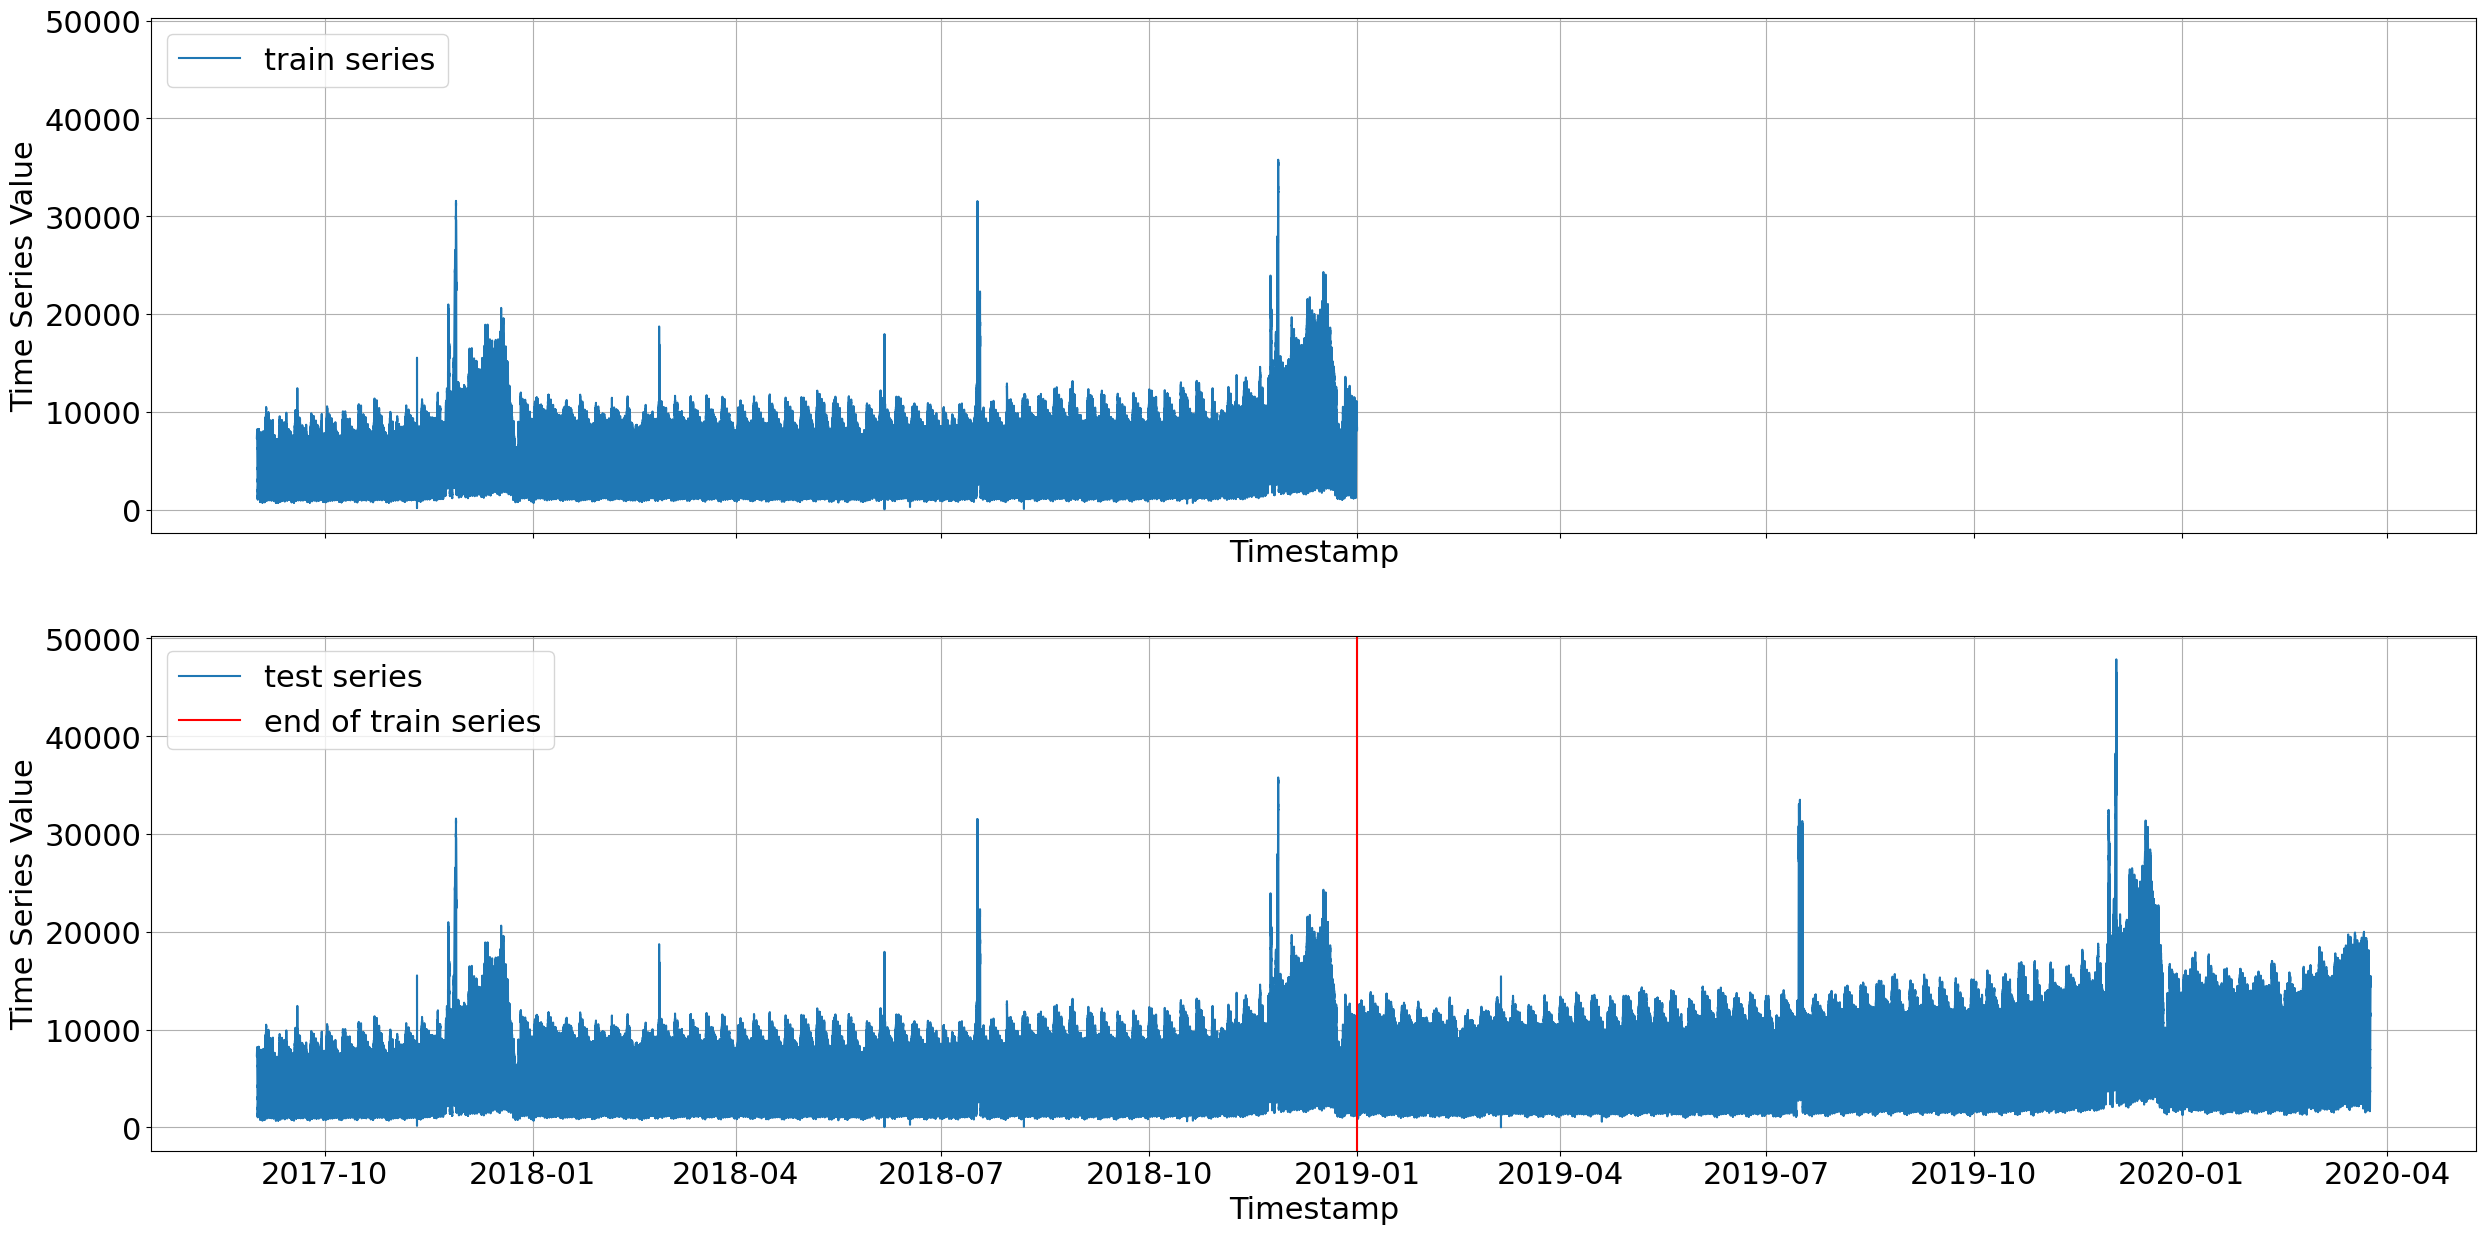

In [17]:
from mxnet import gluon
from gluonts.distribution import Gaussian, GaussianOutput


plt.rcParams["figure.figsize"] = (30, 15)
plt.rcParams["figure.dpi"] = 100
plt.rcParams['font.size'] = 22

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

ax[0].plot(d.timestamps[:701279], d.ts[:701279])
ax[0].legend(["train series"], loc="upper left")
ax[0].set_ylabel("Time Series Value")
ax[0].set_xlabel("Timestamp")
ax[0].grid(which="both")

ax[1].plot(d.timestamps, d.ts)
ax[1].axvline(d.timestamps[701279], color='r') # end of train dataset
ax[1].legend(["test series", "end of train series"], loc="upper left")
ax[1].set_ylabel("Time Series Value")
ax[1].set_xlabel("Timestamp")
ax[1].grid(which="both")


plt.show()

In [18]:
from gluonts.dataset.common import ListDataset

def mk_ds(df):
    havel_dict_data = df.to_havel_dict()
    feat_dynamic_cat = np.vstack([df.timestamps.hour.values, 
                                 df.timestamps.dayofweek.values, df.timestamps. .values])
    
    target = havel_dict_data["target"]
    observed = [0 if np.isnan(x) else 1 for x in target]
    
    ds = ListDataset([{
        'feat_dynamic_cat': feat_dynamic_cat,
        'target': [0 if np.isnan(x) else x for x in target],
        'start': pd.to_datetime(havel_dict_data["start"]),
        'observed_values': observed,          
        }],
        freq='1min'
    )
    return ds

train_ds = mk_ds(d[:701279])

# havel_dict_data_test = d[701280:].to_havel_dict()
# feat_dynamic_cat_test = np.vstack([d.timestamps[701280:].hour.values, 
#                                    d.timestamps[701280:].dayofweek.values, d.timestamps[701280:].month.values])

# test_ds = ListDataset([{
#     "feat_dynamic_cat": feat_dynamic_cat_test,
#     "target": havel_dict_data_test["target"],
#     "start": pd.to_datetime(havel_dict_data_test["start"]),
# }], freq='1min')


# def mk_ds(df):
#     feat_dynamic_cat = np.vstack([df.timestamps.hour.values, df.timestamps.dayofweek.values, df.timestamps.month.values])
#     feat_dynamic_real = np.vstack([df['mean'].values]) # , df.stderr.values, df.dof.values 
    
#     target = df.peak_below.values
#     observed = [0 if np.isnan(x) else 1 for x in target]
    
#     ds = ListDataset([{
#         'feat_dynamic_cat': feat_dynamic_cat,
#         'feat_dynamic_real': feat_dynamic_real,
#         'target': [0 if np.isnan(x) else x for x in target],
#         'start': '2019-01-01 00:00:00',
#         'observed_values': observed
#                       }],
#         freq='1min'
#     )
#     return ds

# train_ds = mk_ds(d.tail(-1000).dropna()) # note the dropna!
# test_df = d.tail(10000).dropna() 
# test_ds = mk_ds(test_df) 

# test_df

# prediction_length=60, context_length=60*24

In [21]:
from gluonts.distribution import GaussianOutput

estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=60,
    context_length=60*24,
    freq='1min',
    trainer = Trainer(
        epochs=50,
        batch_size=25,
        num_batches_per_epoch=100,
        learning_rate=1e-3,
        hybridize=False,
        ),
    distr_output = GaussianOutput()
)

predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [03:52<00:00,  2.32s/it, epoch=50/50, avg_epoch_loss=10] 


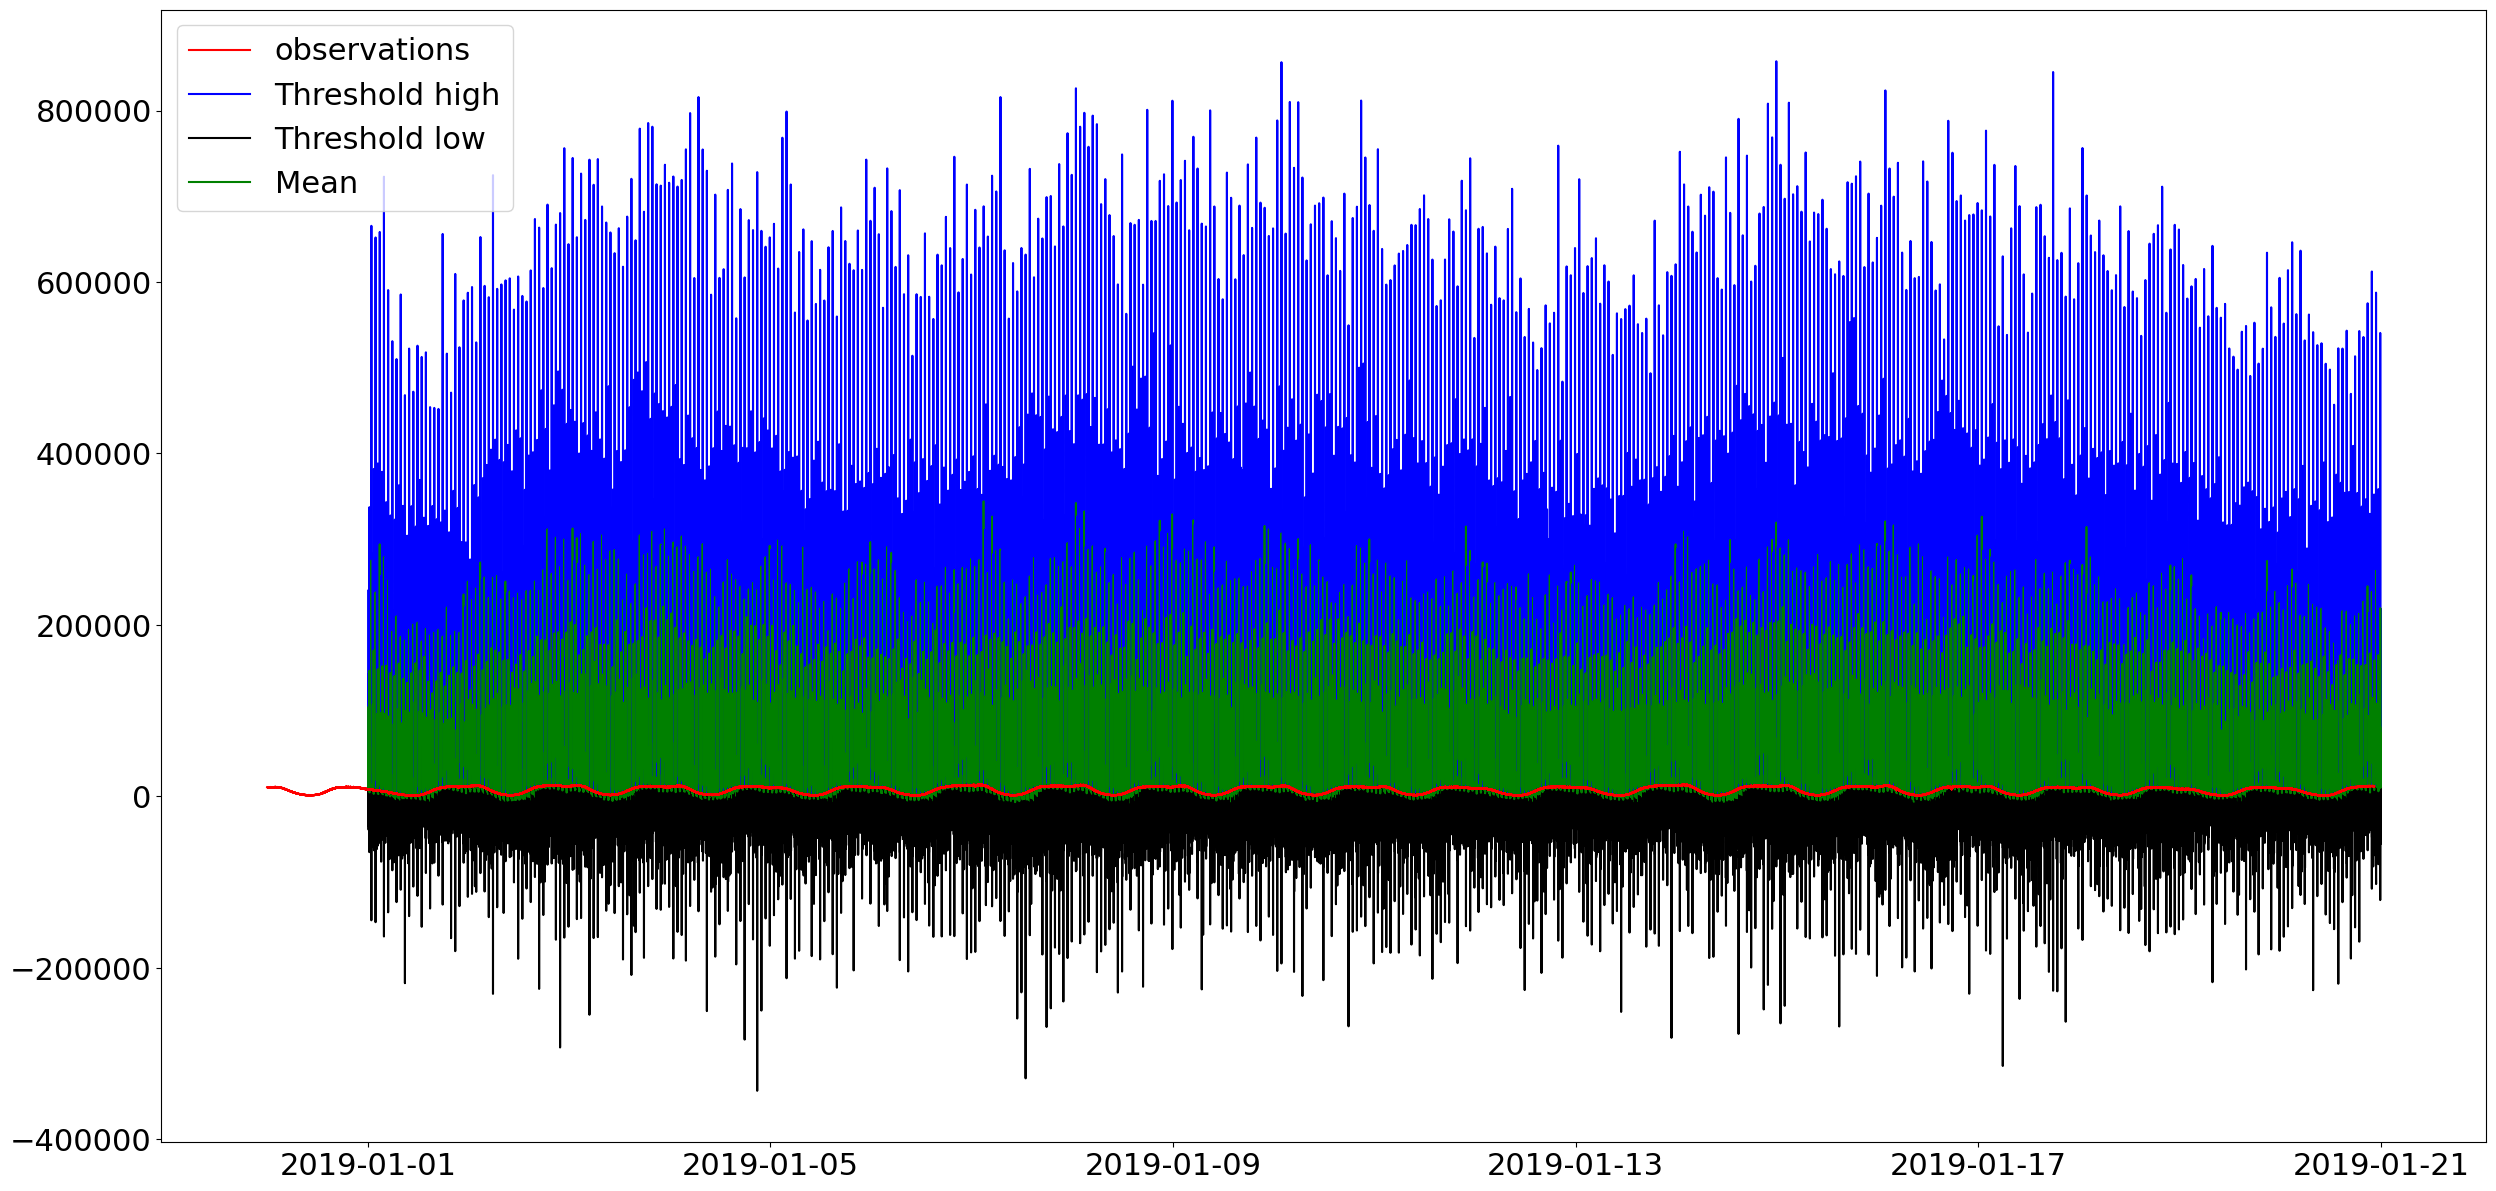

In [22]:
from gluonts.evaluation.backtest import make_evaluation_predictions

fig, ax = plt.subplots(1, 1)

def plot_prob_forecasts(recur, ts_entry, forecast_entry):
    plot_length = 60*25
#     prediction_intervals = (50.0,98.0)
#     legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    prediction_intervals = [98.0]
#     legend = ["observations", "median prediction"] + [f"{prediction_intervals[0]}% prediction interval"]
    legend = ["observations", "Threshold high", "Threshold low", "Mean"]
#     fig, ax = plt.subplots(1, 1)
#     ts_entry[-plot_length:].plot(ax=ax, color='r')  # plot the time series
    ax.plot(ts_entry, color='r', label='observations')
#     print(forecast_entry.quantile(0.98))
#     print(len(ts_entry))
#     forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.plot(d.timestamps[701280-60*24*1+60*recur+60*24*1:701280-60*24*1+60*recur+60*24*1+60], forecast_entry.quantile(0.98), color='b', label='Threshold high')
    ax.plot(d.timestamps[701280-60*24*1+60*recur+60*24*1:701280-60*24*1+60*recur+60*24*1+60], forecast_entry.quantile(0.02), color='black', label='Threshold low')
    ax.plot(d.timestamps[701280-60*24*1+60*recur+60*24*1:701280-60*24*1+60*recur+60*24*1+60], forecast_entry.mean, color='g', label='Mean')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
#     plt.show()
    
peakover = []
peakover_point = []
peakbelow = []
peakbelow_point = []
threshold_over = []
threshold_below = []
mean = []

period = 480

for recur in range(period):
    #test_ds = mk_ds(d[701280+60*4+recur*60*24:701280+60*4+60*24*9+60-1+recur*60*24]) #End: 1347422
    #test_ds = mk_ds(d[701280:])
    test_ds = mk_ds(d[701280-60*24*1+60*recur:701280-60*24*1+60*recur+60*24*1+60]) #End: 1347422
    #test_ds = mk_ds(d[0:701280-60*24*1+60*recur+60*24*1+60]) #End: 1347422

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)

    # first entry of the time series list
    ts_entry = tss[0]

    # first entry of test_ds
    test_ds_entry = next(iter(test_ds))

    # first entry of the forecast list
    forecast_entry = forecasts[0]
    
    #Compute the threshold above and below the series, and compute the extreme values
    threshold_over.extend(forecast_entry.quantile(0.98))
    threshold_below.extend(forecast_entry.quantile(0.02))
    mean.extend(forecast_entry.mean)
#     print(len(ts_entry[0]))
#     print(ts_entry)
    for i in range(len(forecast_entry.quantile(0.98))):
        threshold_high = (forecast_entry.quantile(0.98))[i]
        threshold_low = (forecast_entry.quantile(0.02))[i]
        peakover.append(ts_entry[0][1440+i] - threshold_high if ts_entry[0][1440+i] - threshold_high >= 0 else np.nan)
        peakover_point.append(ts_entry[0][1440+i] if ts_entry[0][1440+i] - threshold_high >= 0 else np.nan)
        peakbelow.append(threshold_low - ts_entry[0][1440+i] if ts_entry[0][1440+i] - threshold_low <= 0 else np.nan)
        peakbelow_point.append(ts_entry[0][1440+i] if ts_entry[0][1440+i] - threshold_low <= 0 else np.nan)

    plot_prob_forecasts(recur, ts_entry, forecast_entry)

plt.show()

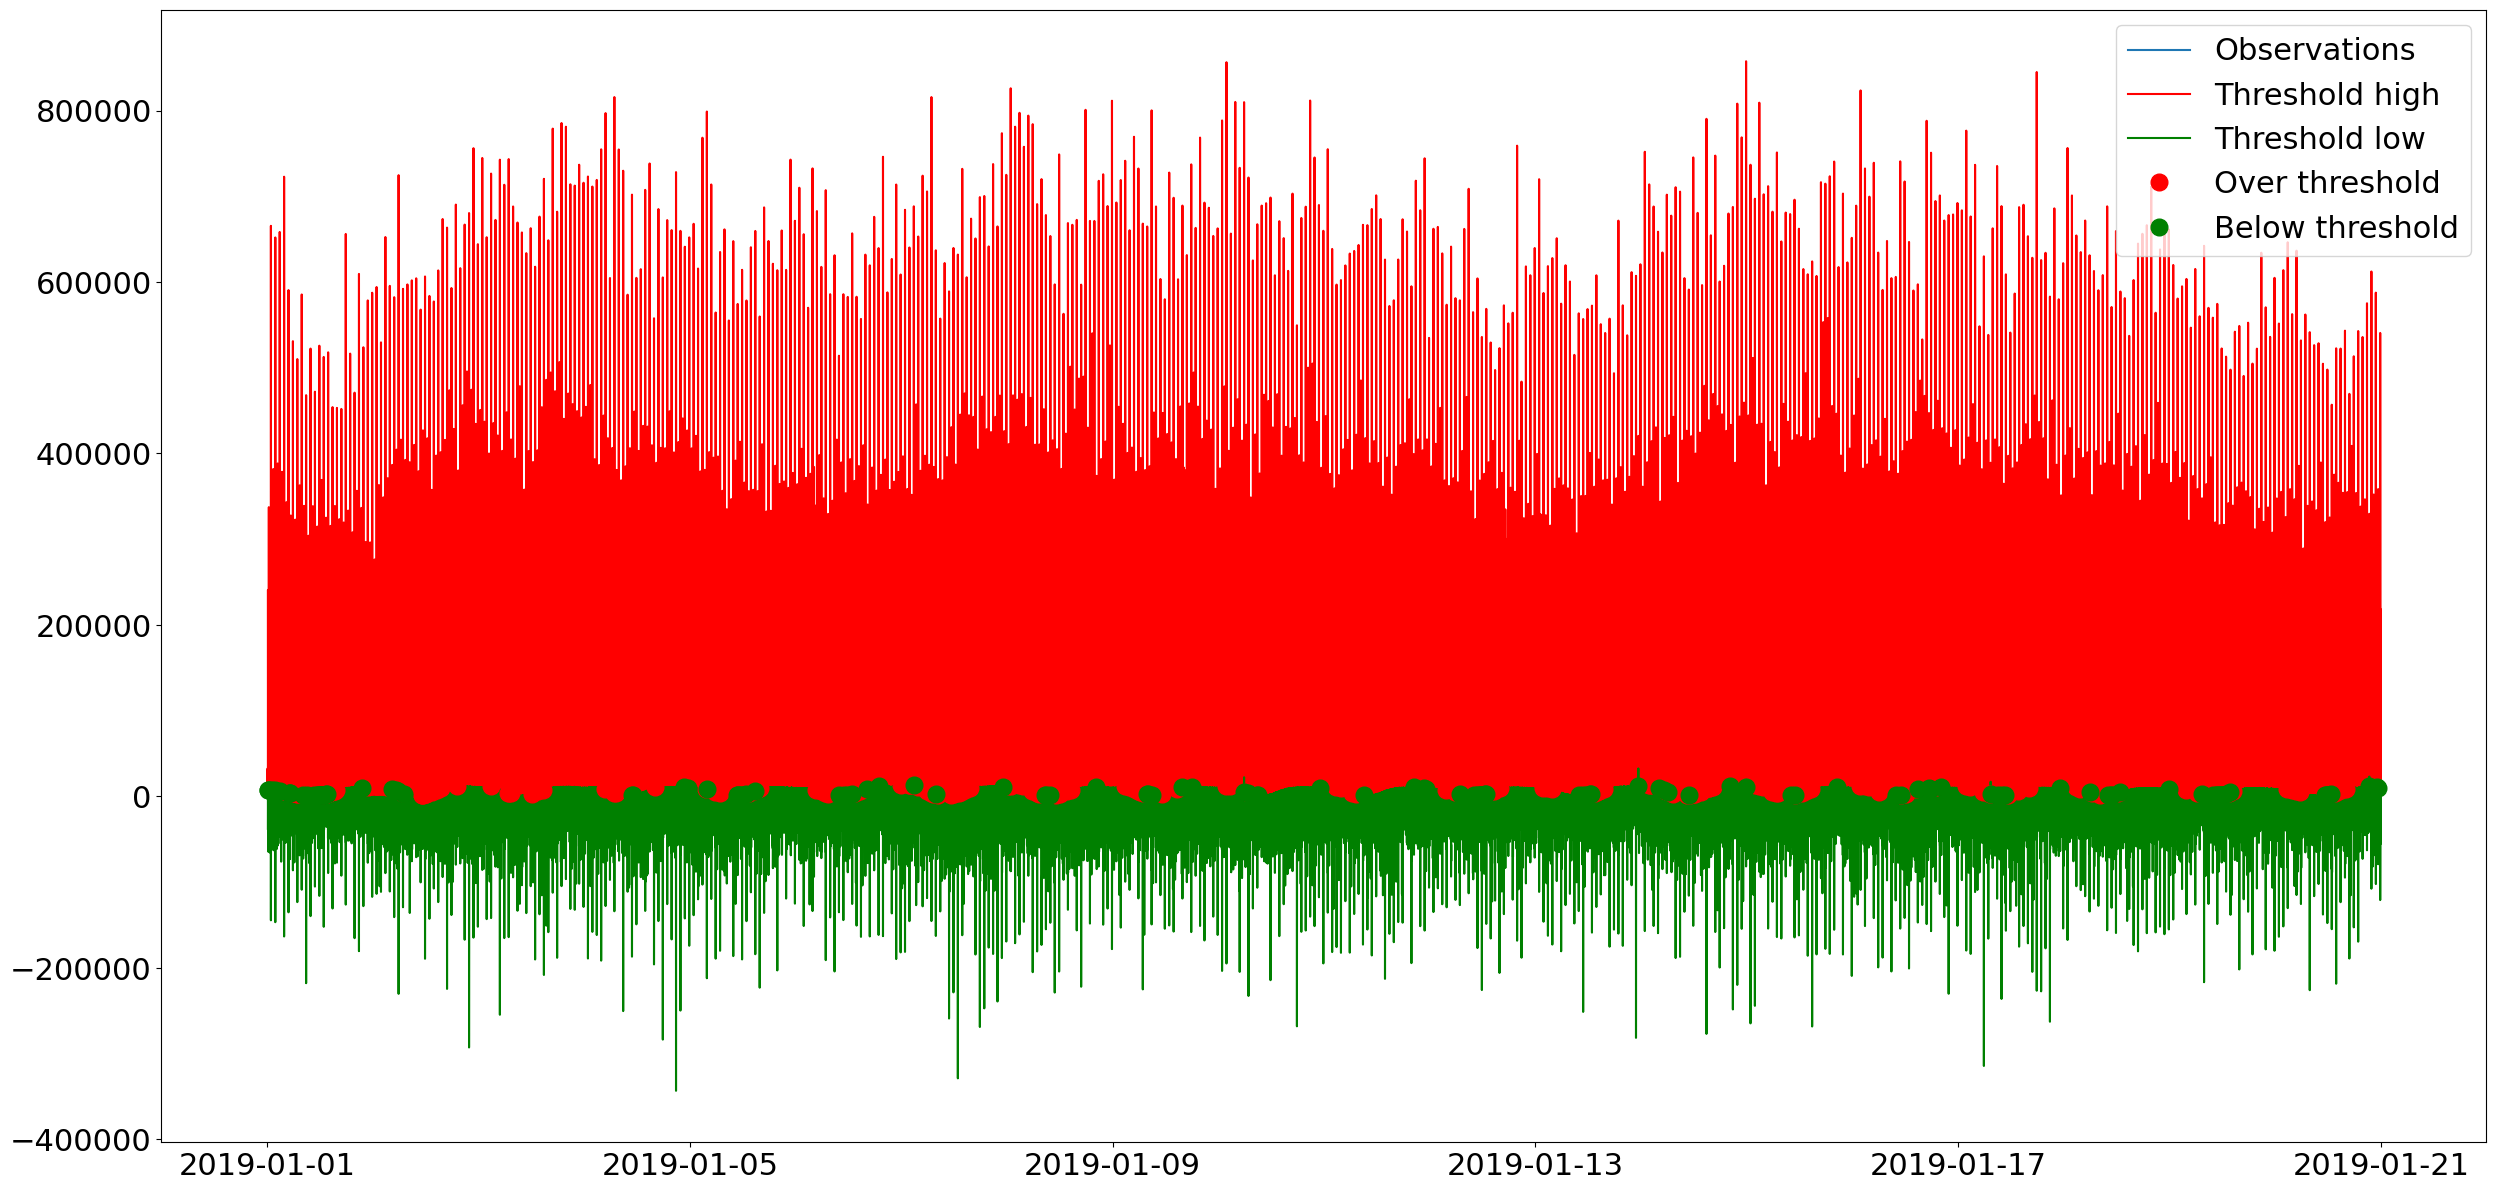

In [23]:
def plot_peaks():
    fig, ax = plt.subplots()
    #fig.set_size_inches(18.5, 10.5)
    
    ax.plot(d.timestamps[701280:701280+60*period], d.ts[701280:701280+60*period], label='Observations')
    ax.plot(d.timestamps[701280:701280+60*period], threshold_over, color='r', label='Threshold high')
    ax.plot(d.timestamps[701280:701280+60*period], threshold_below, color='g', label='Threshold low')
    
    ax.plot(d.timestamps[701280:701280+60*period], peakover_point, marker='o', color='r', linestyle = 'None', label='Over threshold', markersize = 12)
    ax.plot(d.timestamps[701280:701280+60*period], peakbelow_point, marker='o', color='g', linestyle = 'None', label='Below threshold', markersize = 12)
    
    ax.legend()
    
plot_peaks()

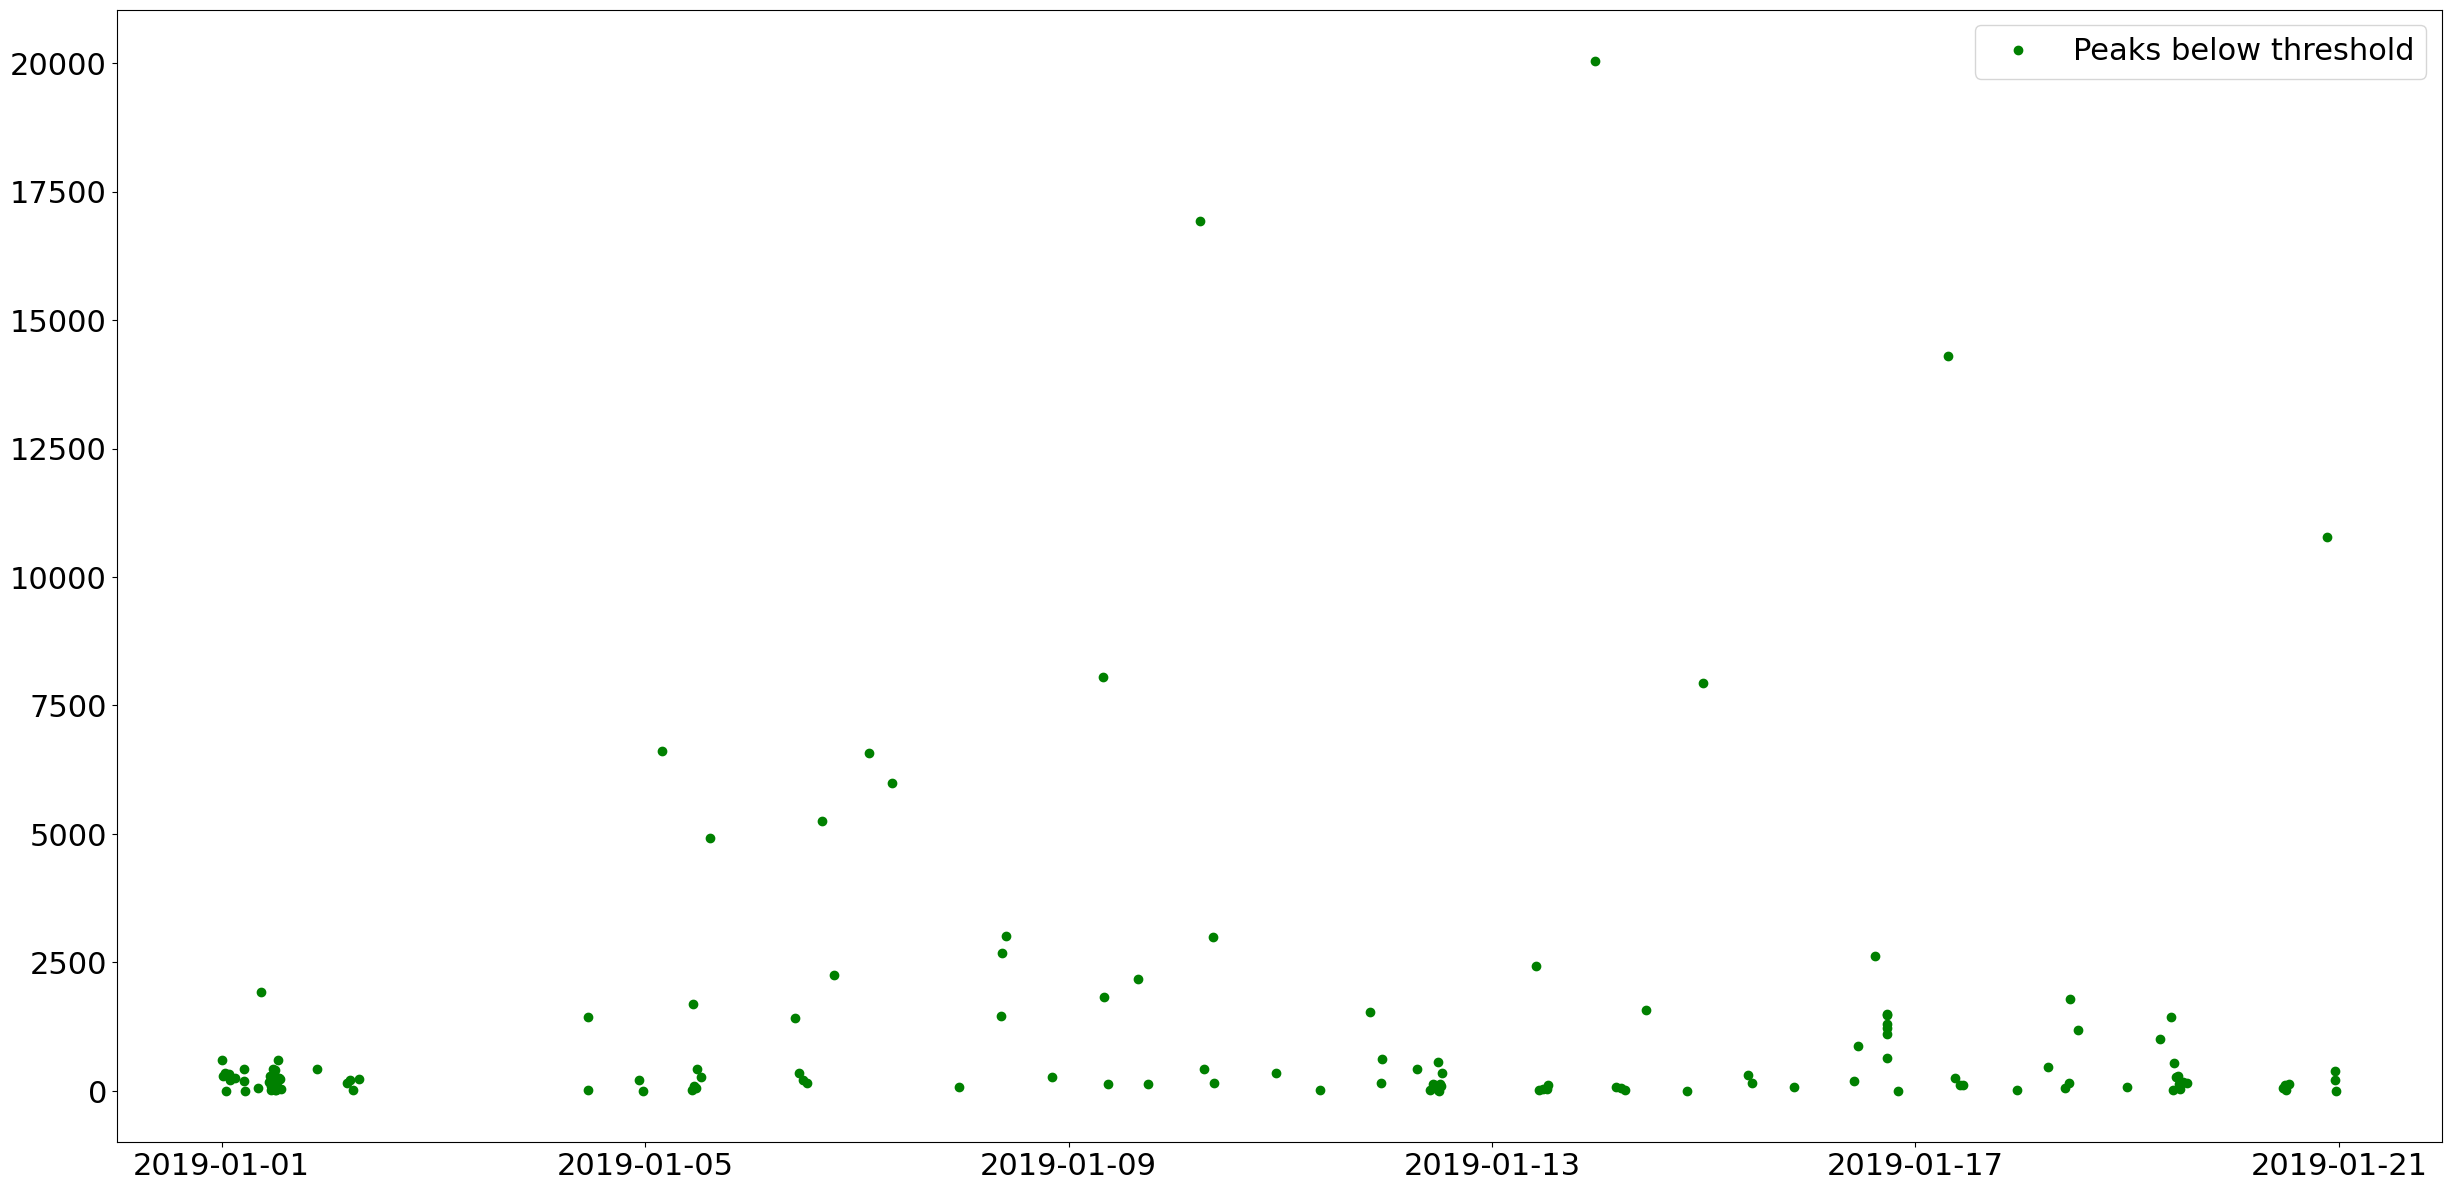

In [24]:
def plot_peakbelow():
    fig, ax = plt.subplots()
    #fig.set_size_inches(18.5, 10.5)

    ax.plot(d.timestamps[701280:701280+60*period], peakbelow, marker='o', color='g', linestyle = 'None', label='Peaks below threshold')
    #ax.plot(df['peak_over'], marker='o', color='r', linestyle = 'None', label='Peaks over threshold')
    ax.legend()

plot_peakbelow()

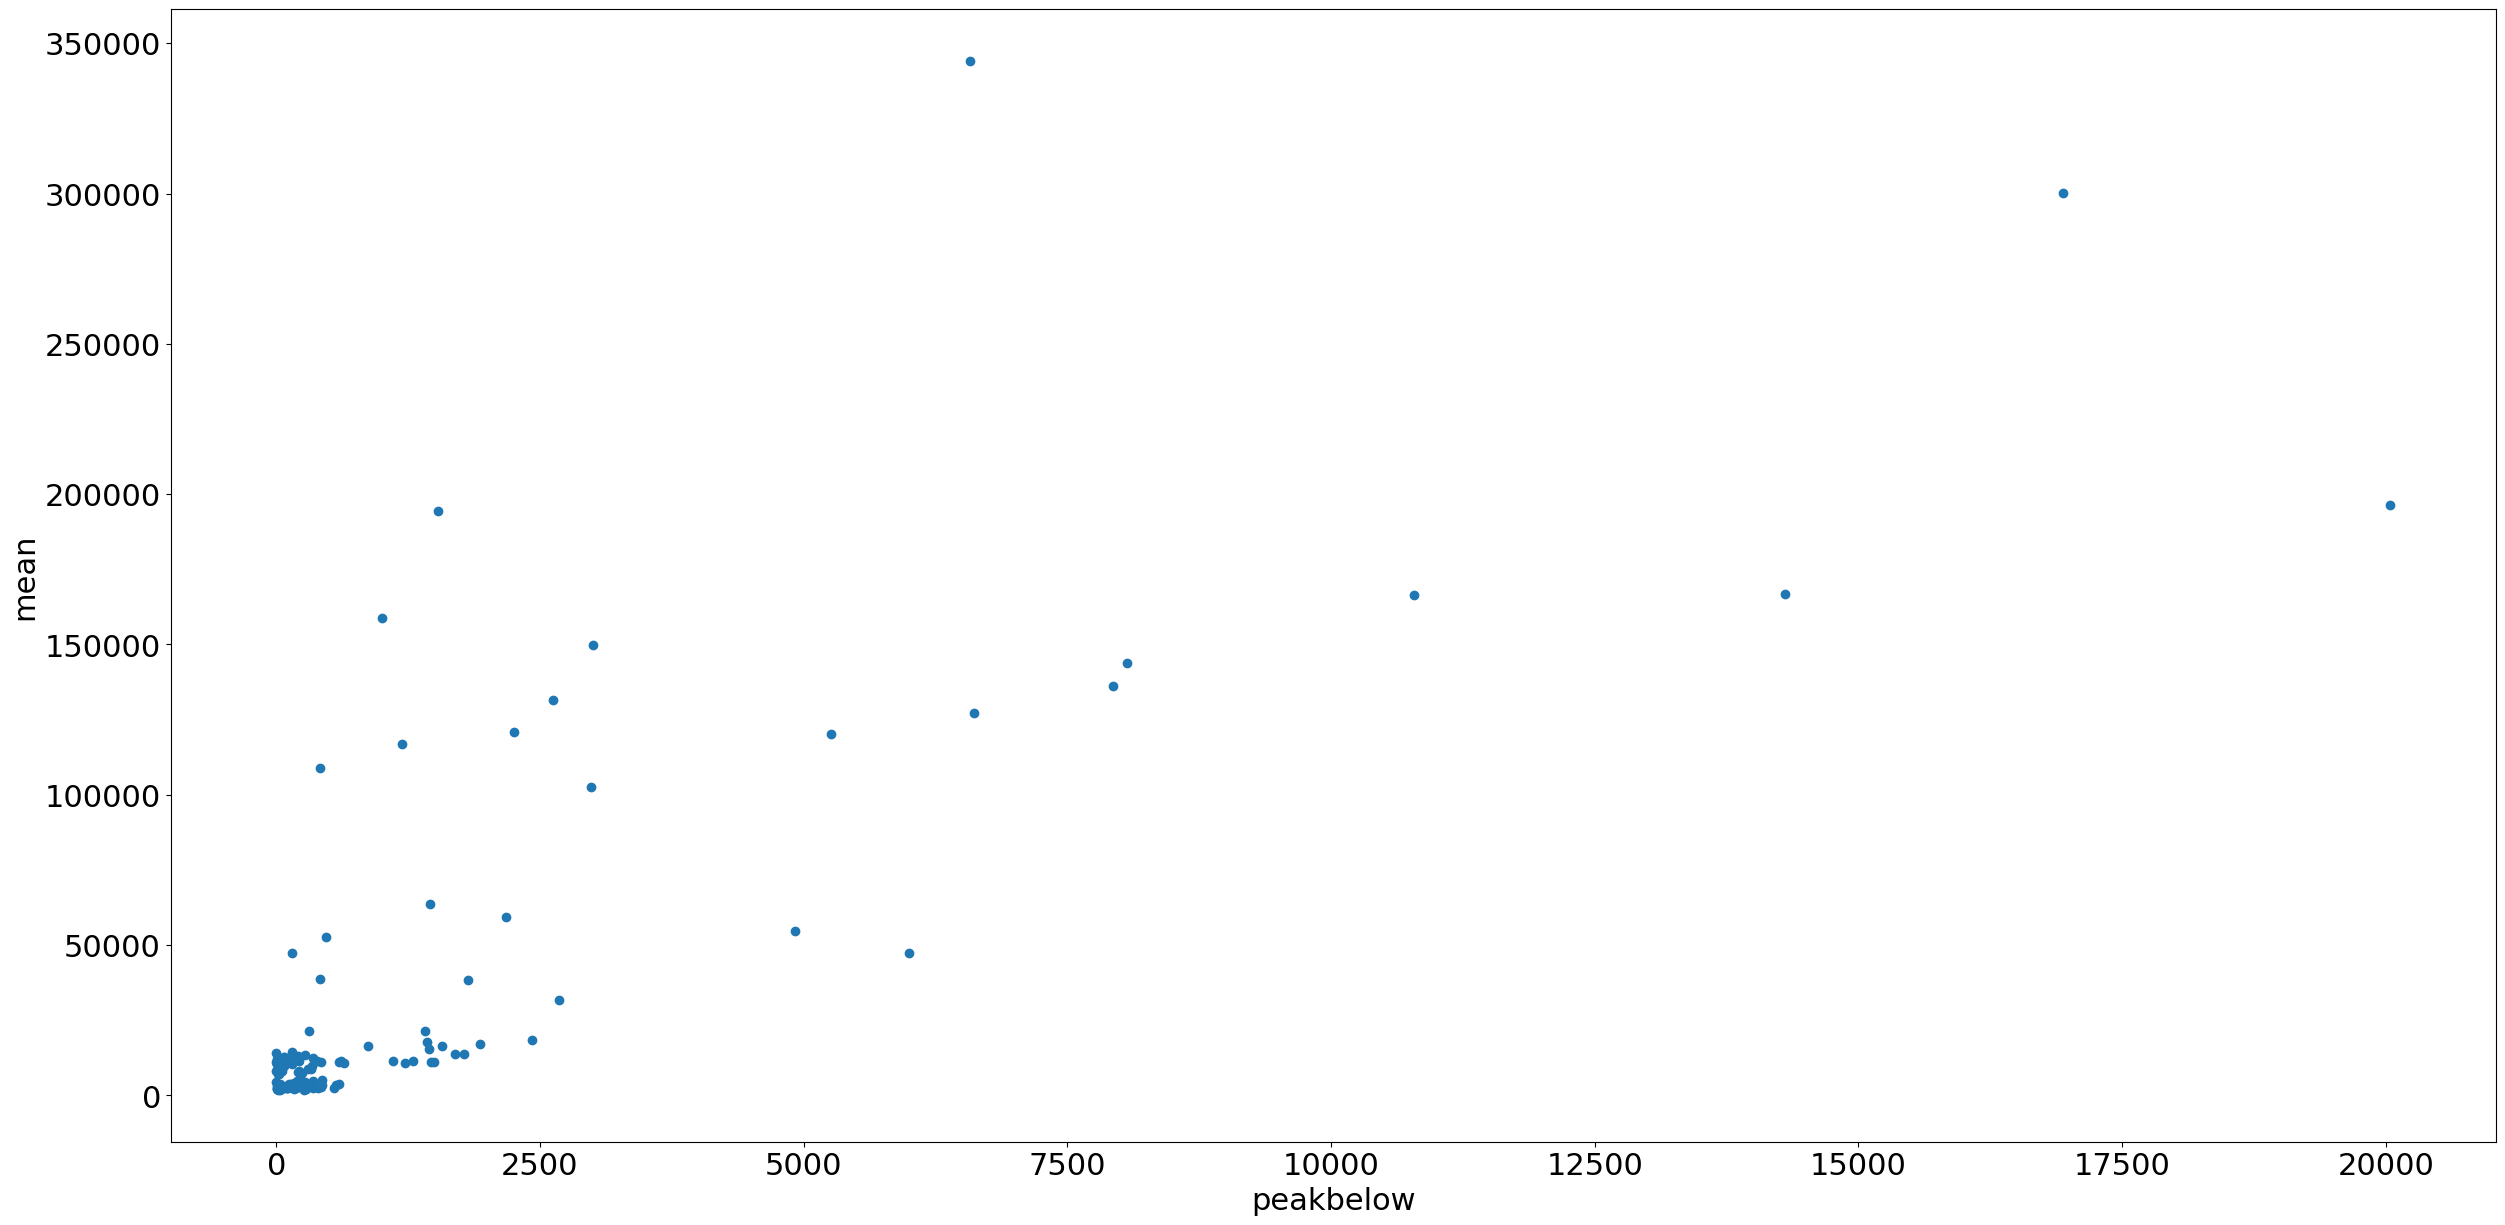

In [25]:
def plot_peakbelow_mean():
    plt.xlabel('peakbelow')
    plt.ylabel('mean')
    plt.scatter(peakbelow, mean)

plot_peakbelow_mean()

In [26]:
dataSeries = pd.DataFrame({'observations': d.ts[701280:701280+60*period], 
                           'forecast_date': d.timestamps[701280:701280+60*period],
                           'mean': mean,
                           'peakbelow': peakbelow,
                           #'peakover': peakover,
                           #'threshold_over': threshold_over,
                           'threshold_below': threshold_below,
                           'mean': mean,})
dataSeries['forecast_date'] = pd.to_datetime(dataSeries['forecast_date'])
dataSeries = dataSeries.set_index('forecast_date', drop=True)
dataSeries['hour'] = dataSeries.index.hour
dataSeries['dayofweek'] = dataSeries.index.dayofweek
dataSeries['weekofyear'] = dataSeries.index.weekofyear
dataSeries['month'] = dataSeries.index.month

dataSeries

observations          mean  peakbelow  threshold_below  \
forecast_date                                                                 
2019-01-01 00:00:00        8131.0   8928.045898        NaN      7720.738770   
2019-01-01 00:01:00        8305.0   8933.374023        NaN      7262.585938   
2019-01-01 00:02:00        8157.0   8299.726562        NaN      7046.934570   
2019-01-01 00:03:00        7982.0   9006.618164        NaN      7931.150879   
2019-01-01 00:04:00        8228.0   9620.175781        NaN      8004.132324   
...                           ...           ...        ...              ...   
2019-01-20 23:55:00       10886.0  73506.210938        NaN    -55666.796875   
2019-01-20 23:56:00       10970.0  53410.953125        NaN    -29043.287109   
2019-01-20 23:57:00       11038.0  62621.261719        NaN    -12256.927734   
2019-01-20 23:58:00       10875.0  11091.584961        NaN      9462.575195   
2019-01-20 23:59:00       10682.0  10605.172852        NaN      9161.791992   

                     hour  dayofweek  weekofyear  month  
forecast_date                                            
2019-01-01 00:00:00     0          1           1      1  
2019-01-01 00:01:00     0          1           1      1  
2019-01-01 00:02:00     0          1           1      1  
2019-01-01 00:03:00     0          1           1      1  
2019-01-01 00:04:00     0          1           1      1  
...                   ...        ...         ...    ...  
2019-01-20 23:55:00    23          6           3      1  
2019-01-20 23:56:00    23          6           3      1  
2019-01-20 23:57:00    23          6           3      1  
2019-01-20 23:58:00    23          6           3      1  
2019-01-20 23:59:00    23          6           3      1  

[28800 rows x 8 columns]

In [27]:
def mk_ds_extreme(df):
    feat_dynamic_cat = np.vstack([df.hour.values, df.dayofweek.values, df.month.values])
    feat_dynamic_real = np.vstack([df['mean'].values]) # , df.stderr.values, df.dof.values 
    
    target = df.peakbelow.values
    observed = [0 if np.isnan(x) else 1 for x in target]
    
    ds = ListDataset([{
        'feat_dynamic_cat': feat_dynamic_cat,
        'feat_dynamic_real': feat_dynamic_real,
        'target': [0 if np.isnan(x) else x for x in target],
        'start': '2019-01-01 00:00:00',
        'observed_values': observed
                      }],
        freq='1min'
    )
    return ds

train_ds_extreme = mk_ds_extreme(dataSeries.tail(-1000).dropna())
test_df_extreme = dataSeries.tail(10000).dropna()
test_ds_extreme = mk_ds_extreme(test_df_extreme)

dataSeries.tail(-1000).dropna()

observations           mean     peakbelow  \
forecast_date                                                    
2019-01-01 21:34:00        9820.0   11085.616211    426.593750   
2019-01-02 04:20:00        9037.0   10400.487305    151.785156   
2019-01-02 05:13:00        7027.0    7921.093750    204.637207   
2019-01-02 05:47:00        5924.0    7096.125000     19.991211   
2019-01-02 07:04:00        3307.0    5266.026367    226.171387   
...                           ...            ...           ...   
2019-01-20 12:44:00        2357.0    3496.871582    129.707764   
2019-01-20 21:23:00       12274.0  166604.765625  10781.914062   
2019-01-20 23:05:00       10362.0   11522.427734    212.075195   
2019-01-20 23:07:00        9908.0   11565.598633    389.899414   
2019-01-20 23:20:00       10297.0   11203.727539      0.662109   

                     threshold_below  hour  dayofweek  weekofyear  month  
forecast_date                                                             
2019-01-01 21:34:00     10246.593750    21          1           1      1  
2019-01-02 04:20:00      9188.785156     4          2           1      1  
2019-01-02 05:13:00      7231.637207     5          2           1      1  
2019-01-02 05:47:00      5943.991211     5          2           1      1  
2019-01-02 07:04:00      3533.171387     7          2           1      1  
...                              ...   ...        ...         ...    ...  
2019-01-20 12:44:00      2486.707764    12          6           3      1  
2019-01-20 21:23:00     23055.914062    21          6           3      1  
2019-01-20 23:05:00     10574.075195    23          6           3      1  
2019-01-20 23:07:00     10297.899414    23          6           3      1  
2019-01-20 23:20:00     10297.662109    23          6           3      1  

[111 rows x 8 columns]

# SimpleFeedForward Model on the Extreme Values

In [28]:
class PeakOverThresholdGeneralizedPareto(Distribution):
    r"""
    The Generalized Pareto is a continuous distribution defined on the real line.
    This distribution is often used to model the tails of other distributions.


    Parameters
    ----------
      scale: The scale of the distribution. GeneralizedPareto is a
        location-scale distribution, so doubling the `scale` doubles a sample
        and halves the density. Strictly positive floating point `Tensor`. Must
        broadcast with `concentration`.
        
      concentration: The shape parameter of the distribution,
      mapped to `concentration > 0` for heavy tails.
    F
    """
    
    is_reparameterizable = False

    @validated()
    def __init__(self, scale: Tensor, concentration: Tensor, F=None) -> None:
        self.scale = scale
        self.concentration = concentration
        self.F = F if F else getF(concentration)

    @property
    def batch_shape(self) -> Tuple:
        return self.concentration.shape

    @property
    def event_shape(self) -> Tuple:
        return ()

    @property
    def event_dim(self) -> int:
        return 0

    def log_prob(self, x: Tensor) -> Tensor:
        F = self.F
        z = x / self.scale        

        ll = (- F.log(self.scale) 
              - ((self.concentration + 1) / self.concentration) 
              * F.log1p(self.concentration * z))
        
        return ll

    @property
    def mean(self) -> Tensor:
        # Mean is only defined for concentration < 1. How to handle that?
        mu = self.scale / (1 - self.concentration)
        return mu
    

    @property
    def stddev(self) -> Tensor:
        # Variance is only defined for concentration < 1/2. How?
        F = self.F
        return self.scale / ((1 - self.concentration)* self.F.sqrt(1 - 2 * self.concentration))
        
        
    def cdf(self, x: Tensor) -> Tensor:
        F = self.F
        z = x / self.scale
        u = 1 - F.power(1 + self.concentration * z, - 1 / self.concentration )
        return u
        
    
    def base_distribution_quantile(self, level: Tensor, threshold: Tensor, peak_ratio: Tensor, transforms, below=False) -> Tensor:
        """
        Computes the tail quantile of the base distribution using the fitted extreme value distribution. 
        """
        
        F = self.F
        sgn = -1 if below else 1
        
        # Base GPD quantile
        base_q = (self.scale/self.concentration) * (F.power( level / peak_ratio, -self.concentration) - 1)
        
        # Reversing the transforms
        for t in transforms:
            base_q = t.f(base_q)
        
        # Applying over/below threshold
        q = threshold + sgn * base_q
        
        return q
        

    def sample(
        self, num_samples: Optional[int] = None, dtype=np.float32
    ) -> Tensor:
        def s(scale: Tensor, concentration: Tensor) -> Tensor:
            F = self.F
            ones = concentration.ones_like()

            smpl = scale * (F.power(
                F.random.uniform(0 * ones, 1 * ones, dtype=dtype),
                -concentration) - 1) / concentration
        
            return smpl
            
        return _sample_multiple(s, scale=self.scale, concentration=self.concentration, num_samples=num_samples)

    @property
    def args(self) -> List:
        return [self.scale, self.concentration]

    
class PeakOverThresholdGeneralizedParetoOutput(DistributionOutput):
    args_dim: Dict[str, int] = {"scale": 1, "concentration": 1}
    distr_cls: type = PeakOverThresholdGeneralizedPareto

    @classmethod
    def domain_map(cls, F, scale, concentration):
        scale = 1e-4 + softplus(F, scale)  
        concentration = 1e-4 + softplus(F, concentration)
        return scale.squeeze(axis=-1), concentration.squeeze(axis=-1)

    @property
    def event_shape(self) -> Tuple:
        return ()

In [29]:
from typing import List, Tuple

# Third-party imports
import mxnet as mx

# First-party imports
from gluonts.block.scaler import MeanScaler, NOPScaler
from gluonts.core.component import validated
from gluonts.distribution import Distribution, DistributionOutput
from gluonts.model.common import Tensor


class FeedForwardNetworkBase(mx.gluon.HybridBlock):
    """
    Abstract base class to implement feed-forward networks for probabilistic
    time series prediction.

    This class does not implement hybrid_forward: this is delegated
    to the two subclasses SimpleFeedForwardTrainingNetwork and
    SimpleFeedForwardPredictionNetwork, that define respectively how to
    compute the loss and how to generate predictions.

    Parameters
    ----------
    num_hidden_dimensions
        Number of hidden nodes in each layer.
    prediction_length
        Number of time units to predict.
    context_length
        Number of time units that condition the predictions.
    batch_normalization
        Whether to use batch normalization.
    mean_scaling
        Scale the network input by the data mean and the network output by
        its inverse.
    distr_output
        Distribution to fit.
    kwargs
    """

    # Needs the validated decorator so that arguments types are checked and
    # the block can be serialized.
    @validated()
    def __init__(
        self,
        num_hidden_dimensions: List[int],
        prediction_length: int,
        context_length: int,
        batch_normalization: bool,
        mean_scaling: bool,
        distr_output: DistributionOutput,
        **kwargs,
    ) -> None:
        super().__init__(**kwargs)

        self.num_hidden_dimensions = num_hidden_dimensions
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.batch_normalization = batch_normalization
        self.mean_scaling = mean_scaling
        self.distr_output = distr_output

        with self.name_scope():
            self.distr_args_proj = self.distr_output.get_args_proj()
            self.mlp = mx.gluon.nn.HybridSequential()
            dims = self.num_hidden_dimensions
            for layer_no, units in enumerate(dims[:-1]):
                self.mlp.add(mx.gluon.nn.Dense(units=units, activation="relu"))
                if self.batch_normalization:
                    self.mlp.add(mx.gluon.nn.BatchNorm())
            self.mlp.add(mx.gluon.nn.Dense(units=prediction_length * dims[-1]))
            self.mlp.add(
                mx.gluon.nn.HybridLambda(
                    lambda F, o: F.reshape(
                        o, (-1, prediction_length, dims[-1])
                    )
                )
            )
            self.scaler = MeanScaler() if mean_scaling else NOPScaler()

    def get_distr_args_loc_scale(
        self, F, past_target: Tensor
    ) -> Tuple[Tuple[Tensor, ...], Tensor, Tensor]:
        """
        Given past target values, applies the feed-forward network and
        maps the output to a probability distribution for future observations.

        Parameters
        ----------
        F
        past_target
            Tensor containing past target observations.
            Shape: (batch_size, context_length, target_dim).

        Returns
        -------
        Distribution
            The predicted probability distribution for future observations.
        """

        # (batch_size, seq_len, target_dim) and (batch_size, seq_len, target_dim)
        scaled_target, target_scale = self.scaler(
            past_target,
            F.ones_like(past_target),  # TODO: pass the actual observed here
        )
        mlp_outputs = self.mlp(scaled_target)
        distr_args = self.distr_args_proj(mlp_outputs)

        return distr_args, F.zeros_like(target_scale), target_scale


class FeedForwardTrainingNetwork(FeedForwardNetworkBase):#inside train_model()
    # noinspection PyMethodOverriding,PyPep8Naming
    def hybrid_forward(
        self, F, past_target: Tensor, future_target: Tensor
    ) -> Tensor:
        distr_args, loc, scale = self.get_distr_args_loc_scale(F, past_target)

        distr = self.distr_output.distribution(
            distr_args, scale=scale.expand_dims(axis=1)
        )

        # (batch_size, prediction_length, target_dim)
        loss = distr.loss(future_target)

        # (batch_size, )
        return loss.mean(axis=1)


class FeedForwardPredictionNetwork(FeedForwardNetworkBase):#inside train_model() self.create_predictor()
    # noinspection PyMethodOverriding,PyPep8Naming
    def hybrid_forward(
        self, F, past_target: Tensor
    ) -> Tuple[Tuple[Tensor, ...], Tensor, Tensor]:
        distr_args, loc, scale = self.get_distr_args_loc_scale(F, past_target)
        return distr_args, scale



In [30]:
from typing import List, Optional

# Third-party imports
from mxnet.gluon import HybridBlock

# First-party imports
from gluonts.core.component import validated
from gluonts.dataset.field_names import FieldName
from gluonts.distribution import DistributionOutput, GaussianOutput
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.model.forecast_generator import DistributionForecastGenerator
from gluonts.trainer import Trainer
from gluonts.transform import (
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    Transformation,
    AsNumpyArray,
)
from gluonts.support.util import copy_parameters


class FeedForwardEstimator(GluonEstimator):#Return gluonts.model.estimator.GluonEstimator train_model 


    """
    FeedForwardEstimator

    Parameters
    ----------
    freq
        Time time granularity of the data
    prediction_length
        Length of the prediction horizon
    trainer
        Trainer object to be used (default: Trainer())
    num_hidden_dimensions
        Number of hidden nodes in each layer (default: [40, 40])
    context_length
        Number of time units that condition the predictions
        (default: None, in which case context_length = prediction_length)
    distr_output
        Distribution to fit (default: GaussianOutput())
    batch_normalization
        Whether to use batch normalization (default: False)
    mean_scaling
        Scale the network input by the data mean and the network output by
        its inverse (default: True)
    num_parallel_samples
        Number of evaluation samples per time series to increase parallelism during inference.
        This is a model optimization that does not affect the accuracy (default: 100)
    """

    # The validated() decorator makes sure that parameters are checked by
    # Pydantic and allows to serialize/print models. Note that all parameters
    # have defaults except for `freq` and `prediction_length`. which is
    # recommended in GluonTS to allow to compare models easily.
    @validated()
    def __init__(
        self,
        freq: str,
        prediction_length: int,
        trainer: Trainer = Trainer(),
        num_hidden_dimensions: Optional[List[int]] = None,
        context_length: Optional[int] = None,
        distr_output: DistributionOutput = GaussianOutput(),
        batch_normalization: bool = False,
        mean_scaling: bool = True,
        num_parallel_samples: int = 100,
    ) -> None:
        """
        Defines an estimator. All parameters should be serializable.
        """
        super().__init__(trainer=trainer)

        assert (
            prediction_length > 0
        ), "The value of `prediction_length` should be > 0"
        assert (
            context_length is None or context_length > 0
        ), "The value of `context_length` should be > 0"
        assert num_hidden_dimensions is None or (
            [d > 0 for d in num_hidden_dimensions]
        ), "Elements of `num_hidden_dimensions` should be > 0"
        assert (
            num_parallel_samples > 0
        ), "The value of `num_parallel_samples` should be > 0"

        self.num_hidden_dimensions = (
            num_hidden_dimensions
            if num_hidden_dimensions is not None
            else list([40, 40])
        )
        self.prediction_length = prediction_length
        self.context_length = (
            context_length if context_length is not None else prediction_length
        )
        self.freq = freq
        self.distr_output = distr_output
        self.batch_normalization = batch_normalization
        self.mean_scaling = mean_scaling
        self.num_parallel_samples = num_parallel_samples

    # here we do only a simple operation to convert the input data to a form
    # that can be digested by our model by only splitting the target in two, a
    # conditioning part and a to-predict part, for each training example.
    # fFr a more complex transformation example, see the `gluonts.model.deepar`
    # transformation that includes time features, age feature, observed values
    # indicator, ...
    def create_transformation(self) -> Transformation:
        return Chain(
            [
                AsNumpyArray(field=FieldName.TARGET, expected_ndim=1),
                InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                    time_series_fields=[FieldName.FEAT_DYNAMIC_REAL, FieldName.FEAT_DYNAMIC_CAT]
                )
            ]
        )

    # defines the network, we get to see one batch to initialize it.
    # the network should return at least one tensor that is used as a loss to minimize in the training loop.
    # several tensors can be returned for instance for analysis, see DeepARTrainingNetwork for an example.
    def create_training_network(self) -> HybridBlock:
        return FeedForwardTrainingNetwork(
            num_hidden_dimensions=self.num_hidden_dimensions,
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            batch_normalization=self.batch_normalization,
            mean_scaling=self.mean_scaling,
        )

    # we now define how the prediction happens given that we are provided a
    # training network.
    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = FeedForwardPredictionNetwork(
            num_hidden_dimensions=self.num_hidden_dimensions,
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            batch_normalization=self.batch_normalization,
            mean_scaling=self.mean_scaling,
        )

        copy_parameters(net_source=trained_network, net_dest=prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            forecast_generator=DistributionForecastGenerator(
                self.distr_output
            ),
            ctx=self.trainer.ctx,
        )



In [31]:
trainer_extreme = Trainer(
        epochs=50,
        batch_size=25,
        num_batches_per_epoch=100,
        learning_rate=1e-3,
        hybridize=False,
        )

In [32]:
prediction_length=20

model_extreme = FeedForwardEstimator(
    freq='1min',
    prediction_length=prediction_length,
    num_hidden_dimensions=4*[20],
    context_length=180,
    trainer=trainer_extreme,
    mean_scaling=True,
    distr_output = PeakOverThresholdGeneralizedParetoOutput()
)

forecaster_extreme = model_extreme.train_model(train_ds_extreme)
predictor_extreme = forecaster_extreme.predictor

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:01<00:00, 75.53it/s, epoch=50/50, avg_epoch_loss=7]


In [33]:
def plot_prob_forecasts(target, threshold, samples, test_df, prediction_length, alarm_level, peak_ratio, transforms):
    percentiles = [50, 75, 90, 95, 99]
    legend = ["observations", "threshold", "cutoff"] + [f"p{k} of the Generalized Pareto" for k in percentiles]

    idx = test_df.tail(prediction_length).index
    
    fig, ax = plt.subplots(prediction_length, 1, figsize=(10, 20 * prediction_length))
    
    # Compute the absolute target
    adjusted_target = threshold - target
    
    # Compute percentiles of the predictive distribution
    pct = np.percentile(samples, percentiles, axis=0)

    # Compute alarm cutoff 
    cutoff = p.distribution.base_distribution.base_distribution_quantile(
        level=alarm_level,
        threshold=mx.nd.array(threshold),
        peak_ratio=peak_ratio,
        transforms=transforms,
        below=True
    ).asnumpy()
    
    for sp in range(prediction_length):
        ax[sp].set_title(f"Date: {idx[sp]}\n Peak below: {target[sp]} \n Alarm quantile: {alarm_level}")

        # plot the time series
        pd.Series(adjusted_target[sp]).plot(ax=ax[sp], linestyle = 'None', marker = 'o', markersize=20 )  
        
        # plot the time series
        pd.Series(threshold[sp]).plot(ax=ax[sp], linestyle = 'None', marker = 'o', markersize=20, color='g')

        # plot the cut-off
        pd.Series(cutoff[sp]).plot(ax=ax[sp], linestyle = 'None', marker = '^', markersize=20, color='r')
        
        # plot the percentiles of the GPD
        for i in range(len(percentiles)):
            adjusted_percentile = threshold - pct[i,:]
            pd.Series(data=adjusted_percentile[sp]).plot(
                    ax=ax[sp], marker='X', markersize=10, color=cm.hot(i/len(percentiles)), linestyle = 'None')


        ax[sp].grid(which="both")

    fig.legend(legend, loc="best")
    plt.show()

In [34]:
pred_extreme = predictor_extreme.predict(test_ds_extreme)
p = next(iter(pred_extreme))
p.distribution

gluonts.distribution.transformed_distribution.TransformedDistribution(base_distribution=__main__.PeakOverThresholdGeneralizedPareto(F=None, concentration=mxnet.nd.array([0.00016987220442388207, 0.00010102157830260694, 0.009417320601642132, 0.00010000008478527889, 0.0006761010154150426, 0.0006519042071886361, 9.999999747378752e-05, 0.00010001561895478517, 2.128180980682373, 0.00010003439092542976, 0.03558959439396858, 0.00010000236216001213, 0.00010052315337816253, 0.0005352823645807803, 2.9988510608673096, 0.00010001462942454964, 0.00010061764623969793, 9.999999747378752e-05, 0.00017102740821428597, 0.00010000020847655833], dtype=numpy.float32), scale=mxnet.nd.array([0.5565065145492554, 1.8703083992004395, 8.400925636291504, 1.7137683629989624, 1.4166980981826782, 2.5818347930908203, 5.766930103302002, 0.49501895904541016, 6.519674777984619, 0.38471508026123047, 8.997737884521484, 0.06518056243658066, 4.2082839012146, 5.699459075927734, 0.131610706448555, 0.018633093684911728, 9.742021

In [35]:
tss_extreme = list(test_ds_extreme)
target_extreme = tss_extreme[0]['target'][-prediction_length:]#mk_ds
threshold_extreme = test_df_extreme.threshold_below.tail(prediction_length).values
peak_ratio_extreme = dataSeries.peakbelow.notna().sum() / dataSeries.peakbelow.size
peak_ratio_extreme

0.004826388888888889

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


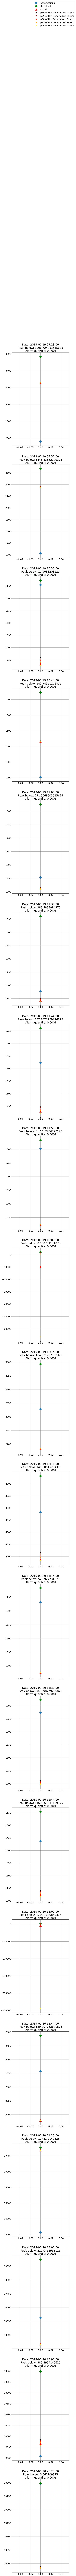

In [36]:
samples_extreme = p.distribution.sample(1000).asnumpy()
alarm_level = 1e-4

plot_prob_forecasts(target_extreme,
                    threshold_extreme,
                    samples_extreme,
                    test_df_extreme,
                    prediction_length,
                    alarm_level,
                    peak_ratio_extreme,
                    p.distribution.transforms)

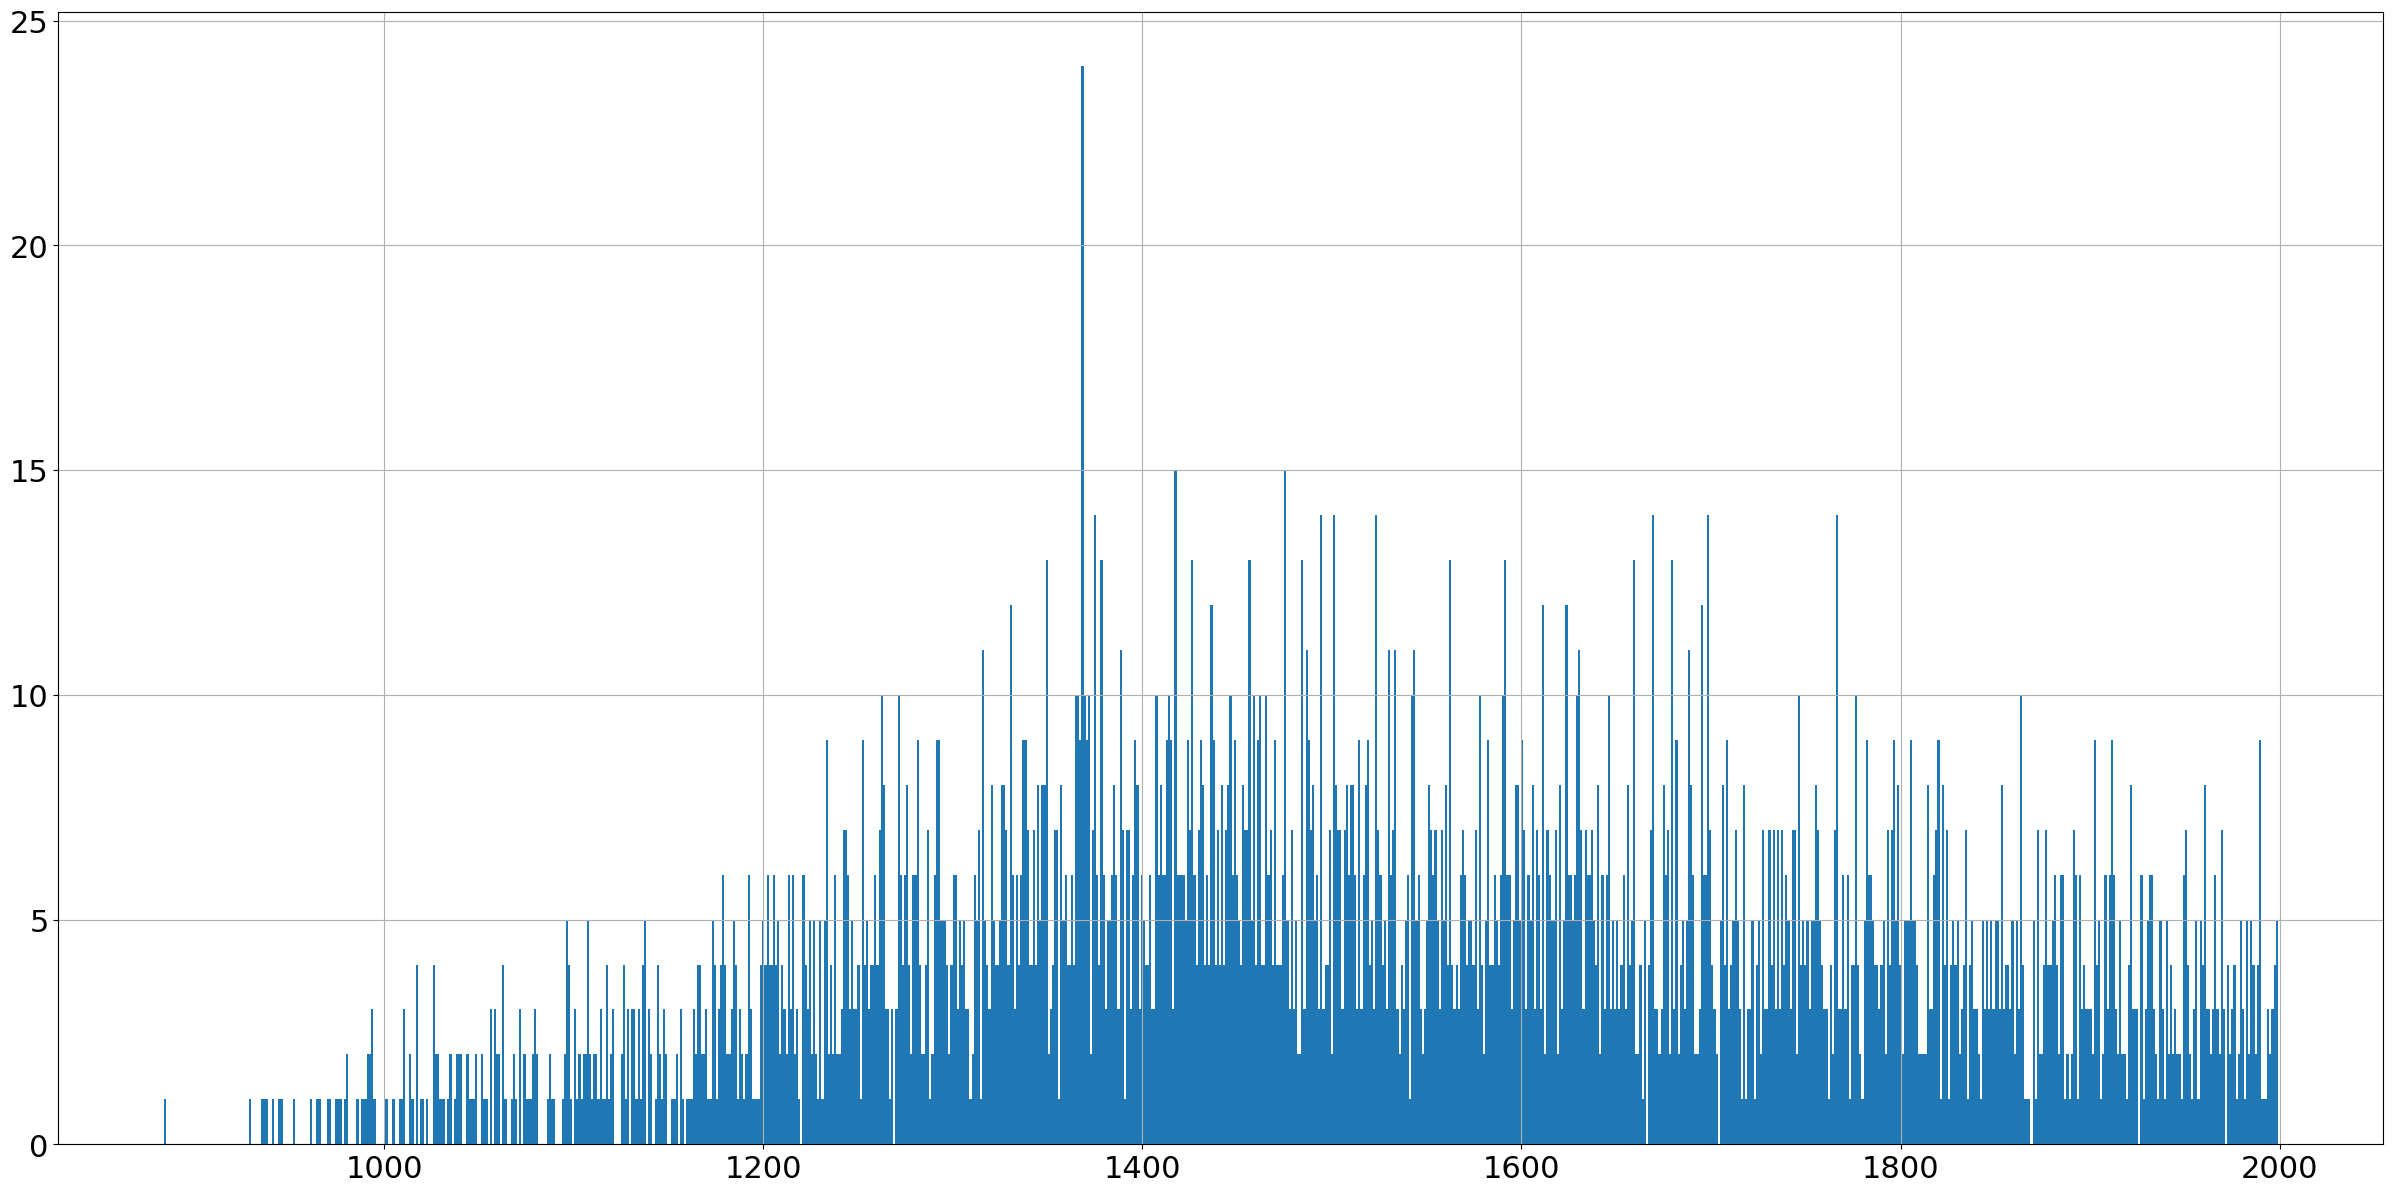

In [37]:
dataSeries.observations[dataSeries.observations<2000].hist(bins=1000)

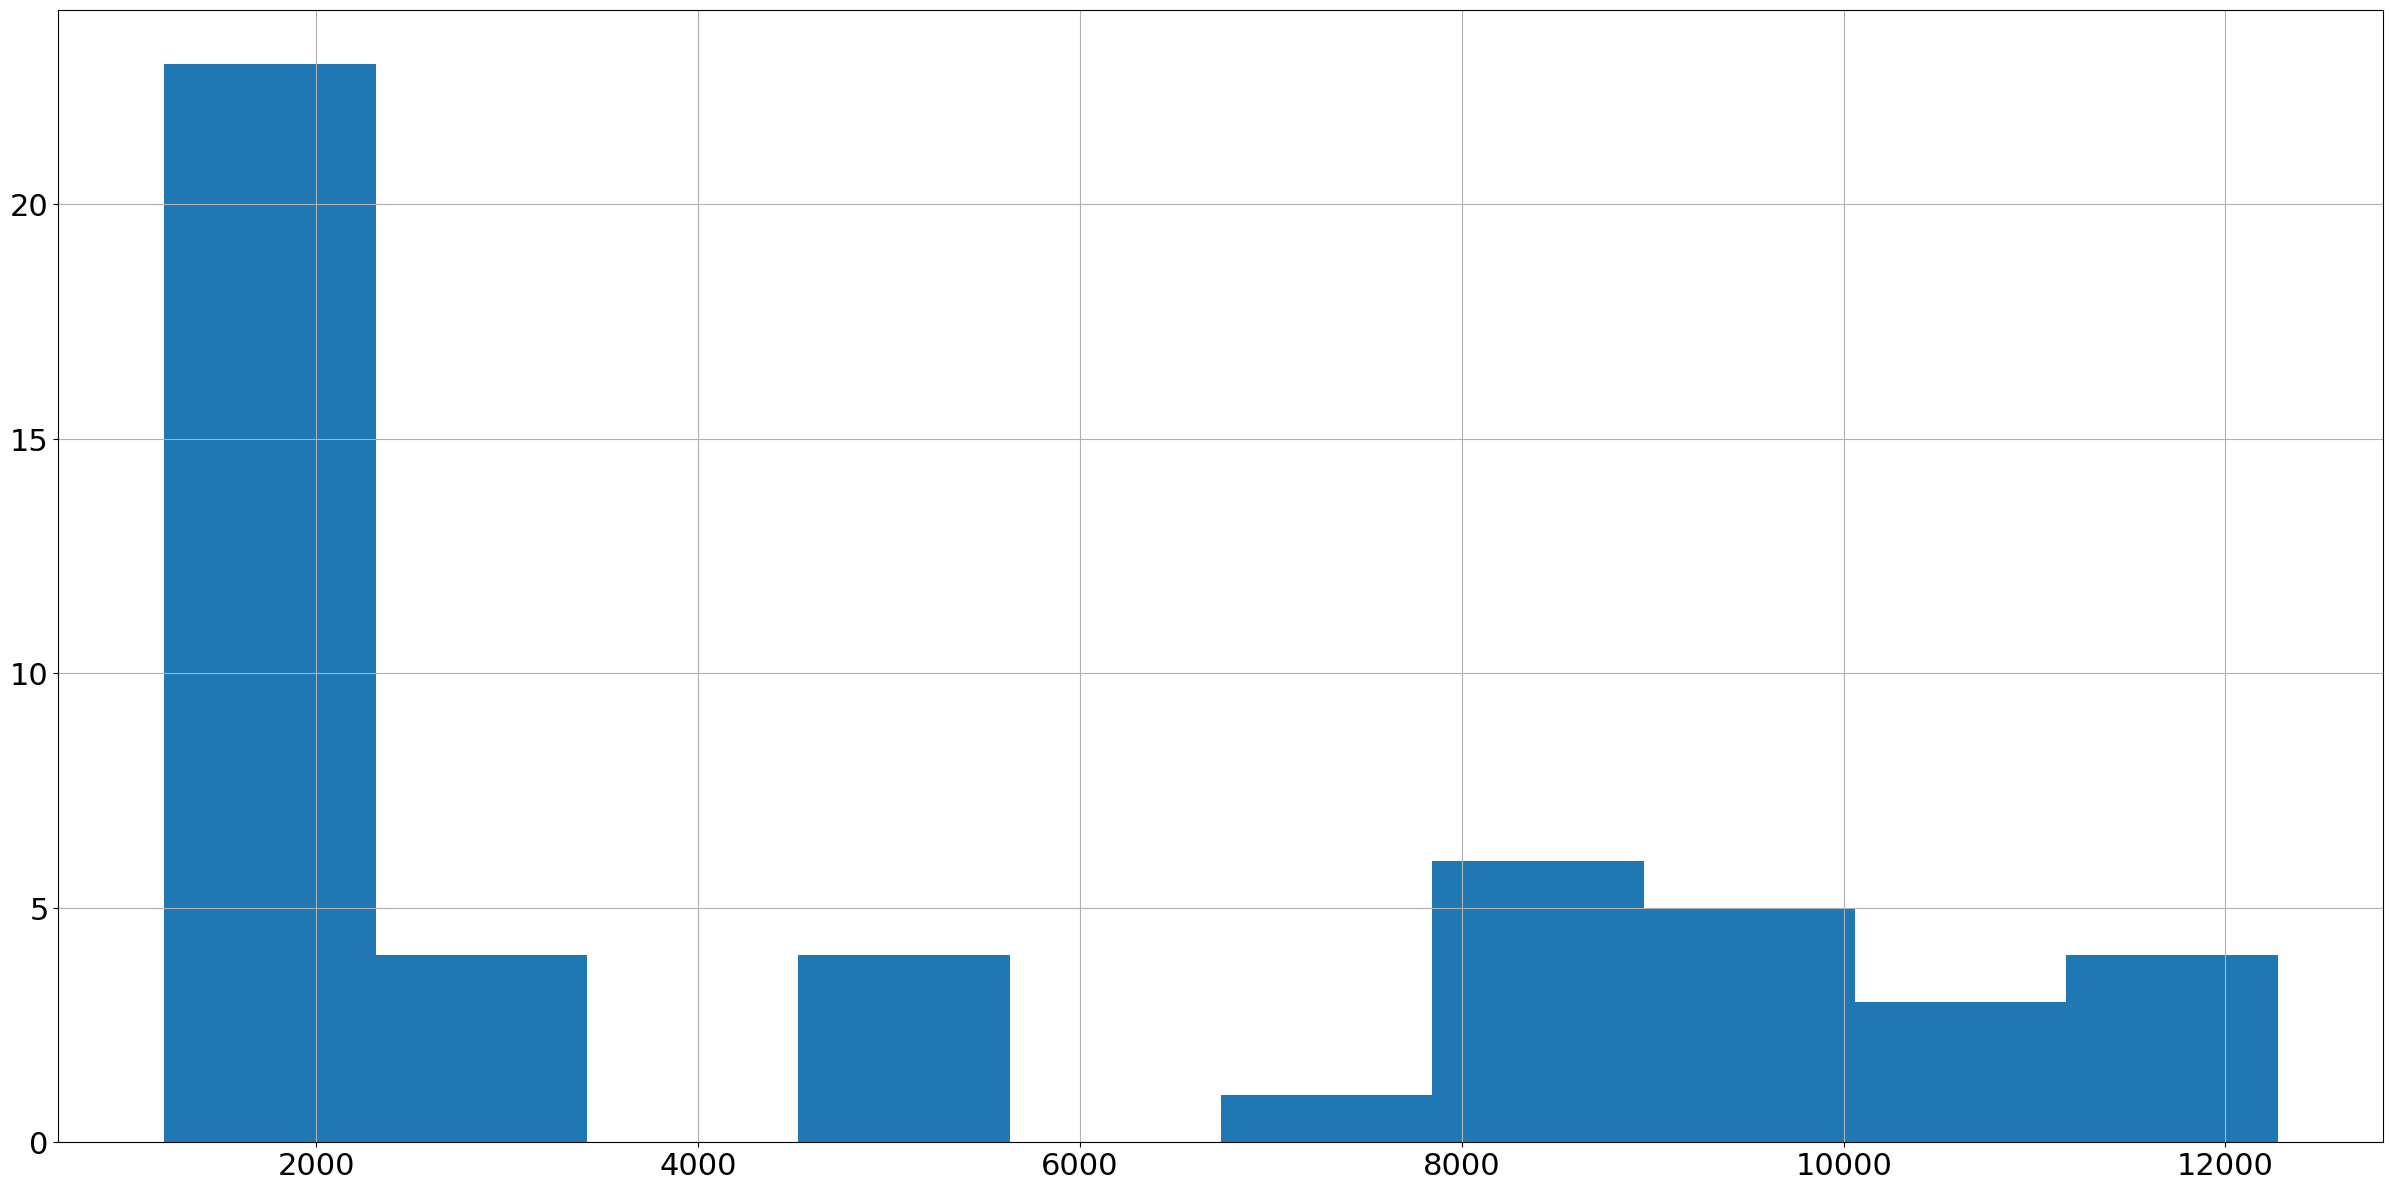

In [38]:
test_df_extreme.observations.hist(bins=10)

# Gaussian, prediction_length=10, context_length=60

In [39]:
from gluonts.distribution import GaussianOutput

estimator_10 = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=10,
    context_length=60,
    freq='1min',
    trainer = Trainer(
        epochs=50,
        batch_size=25,
        num_batches_per_epoch=100,
        learning_rate=1e-3,
        hybridize=False,
        ),
    distr_output = GaussianOutput()
)

predictor_10 = estimator_10.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [03:47<00:00,  2.27s/it, epoch=50/50, avg_epoch_loss=6.82]


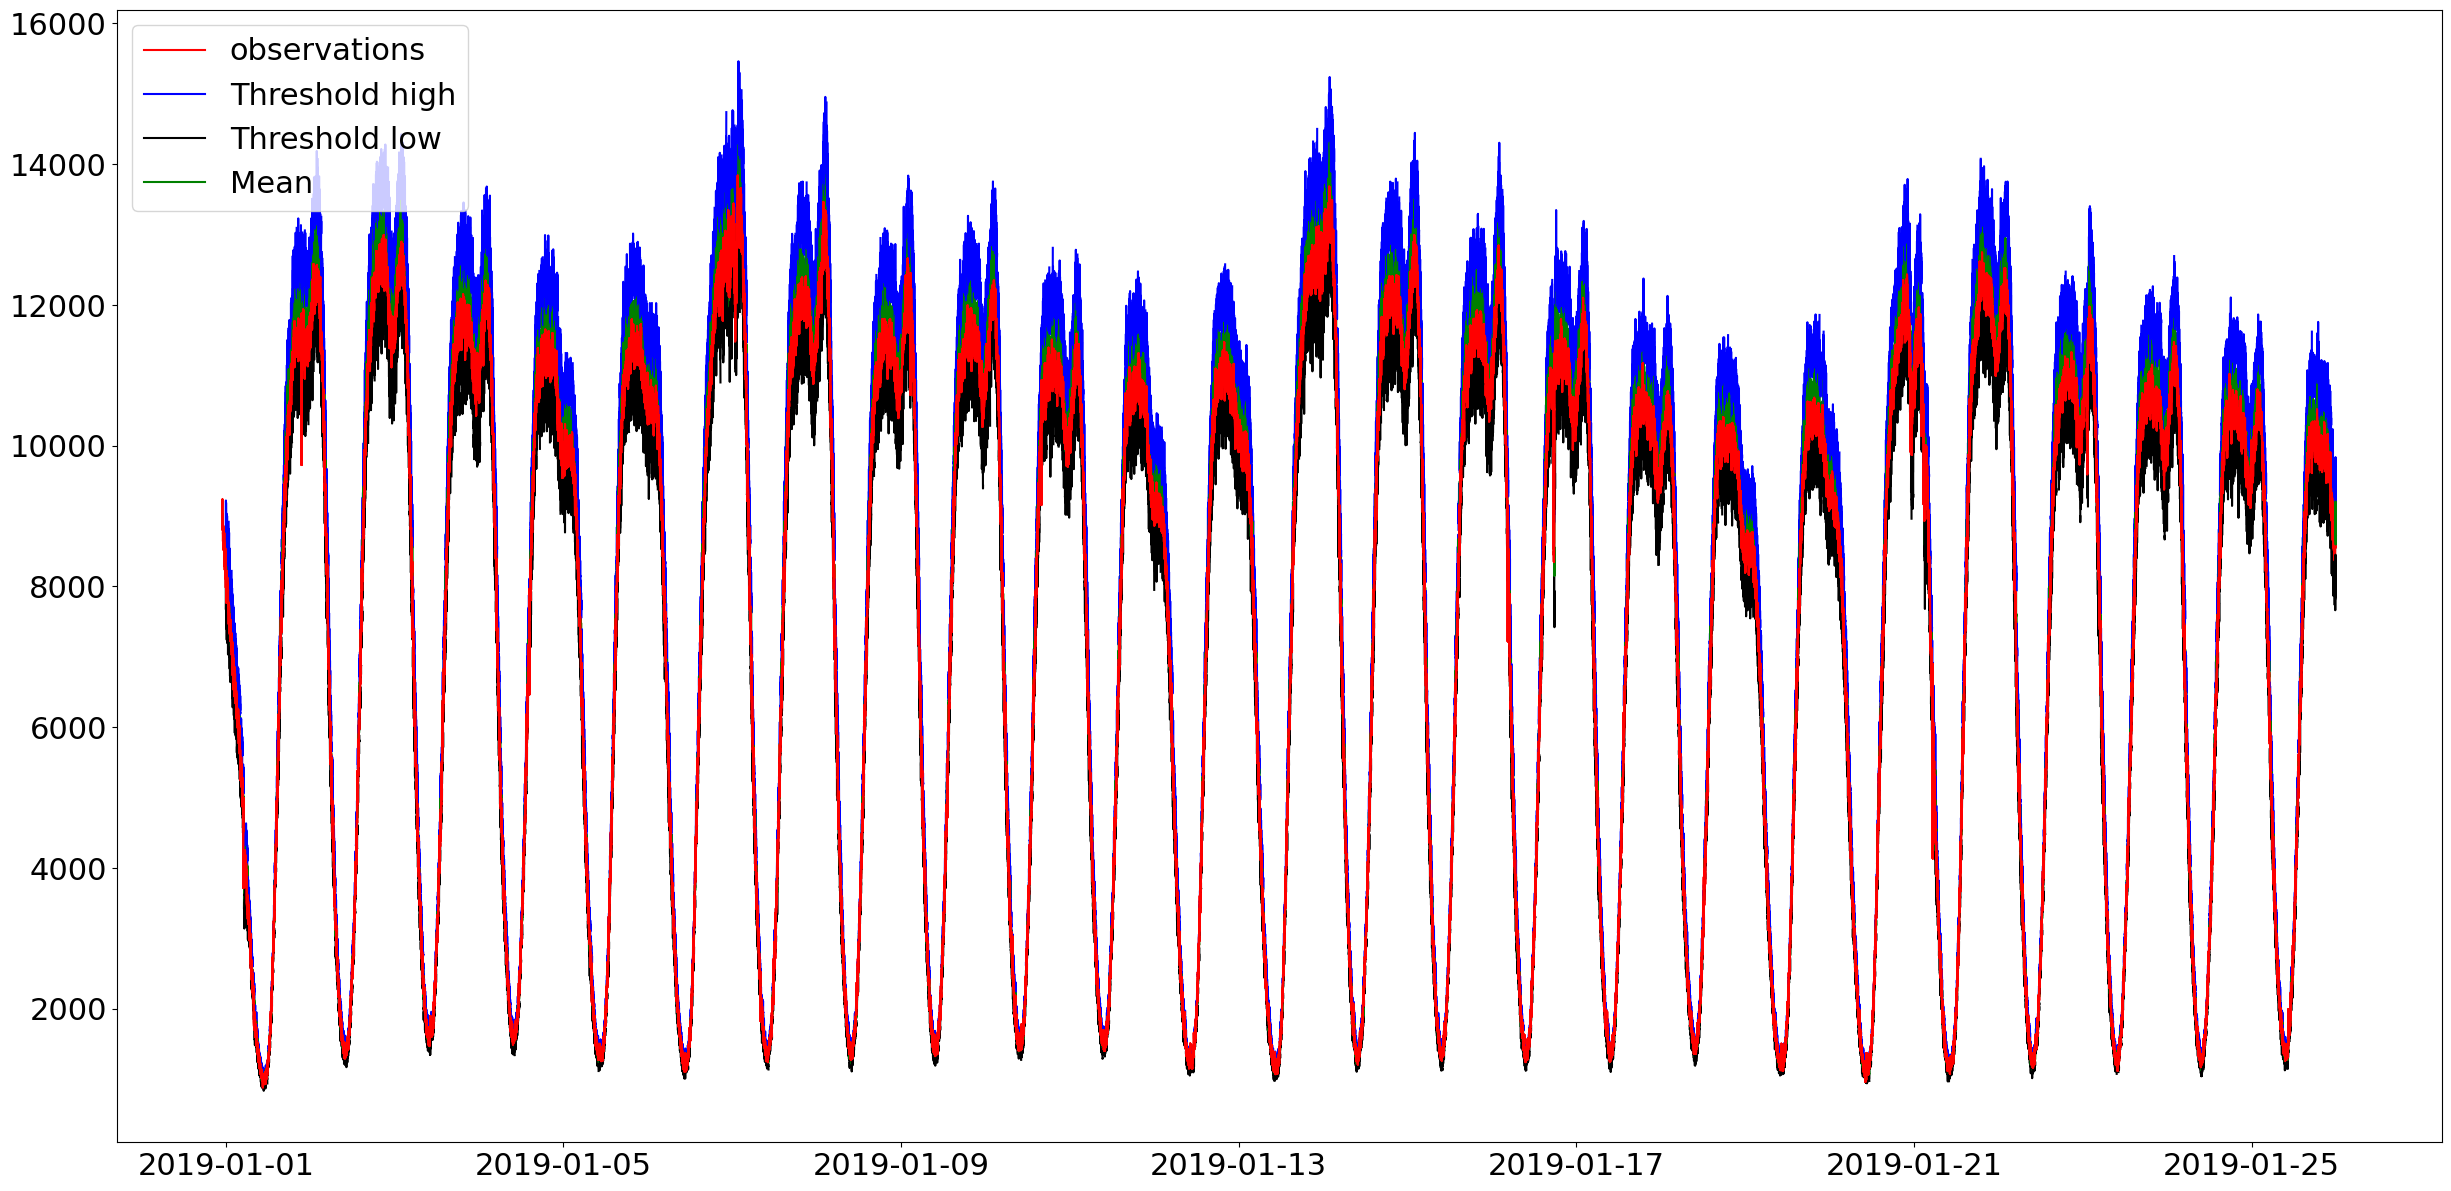

In [40]:
fig_10, ax_10 = plt.subplots(1, 1)

def plot_prob_forecasts_10(recur, ts_entry, forecast_entry):
    plot_length = 60+10
#     prediction_intervals = (50.0,98.0)
#     legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    prediction_intervals = [98.0]
#     legend = ["observations", "median prediction"] + [f"{prediction_intervals[0]}% prediction interval"]
    legend = ["observations", "Threshold high", "Threshold low", "Mean"]
#     fig, ax = plt.subplots(1, 1)
#     ts_entry[-plot_length:].plot(ax=ax, color='r')  # plot the time series
    ax_10.plot(ts_entry, color='r', label='observations')
#     print(ts_entry)
#     forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax_10.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.quantile(0.98), color='b', label='Threshold high')
    ax_10.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.quantile(0.02), color='black', label='Threshold low')
    ax_10.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.mean, color='g', label='Mean')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")

peakover_10 = []
peakbelow_10 = []
peakover_point_10 = []
peakbelow_point_10 = []
threshold_over_10 = []
threshold_below_10 = []
mean_10 = []

period_10 = 3600
    
for recur_10 in range(period_10):
    test_ds_10 = mk_ds(d[701280-60*1+10*recur_10:701280-60*1+10*recur_10+60*1+10]) #End: 1347422

    forecast_it_10, ts_it_10 = make_evaluation_predictions(
        dataset=test_ds_10,  # test dataset
        predictor=predictor_10,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts_10 = list(forecast_it_10)
    tss_10 = list(ts_it_10)

    # first entry of the time series list
    ts_entry_10 = tss_10[0]

    # first entry of test_ds
    test_ds_entry_10 = next(iter(test_ds_10))

    # first entry of the forecast list
    forecast_entry_10 = forecasts_10[0]
    
    #score
    
    #Compute the threshold above and below the series, and compute the extreme values
    threshold_over_10.extend(forecast_entry_10.quantile(0.98))
    threshold_below_10.extend(forecast_entry_10.quantile(0.02))
    mean_10.extend(forecast_entry_10.mean)
#     print(ts_entry_10)
#     print(len(ts_entry_10))
    for i_10 in range(len(forecast_entry_10.quantile(0.98))):
        threshold_high_10 = (forecast_entry_10.quantile(0.98))[i_10]
        threshold_low_10 = (forecast_entry_10.quantile(0.02))[i_10]
        peakover_10.append(ts_entry_10[0][60+i_10] - threshold_high_10 if ts_entry_10[0][60+i_10] - threshold_high_10 >= 0 else np.nan)
        peakbelow_10.append(threshold_low_10 - ts_entry_10[0][60+i_10] if ts_entry_10[0][60+i_10] - threshold_low_10 <= 0 else np.nan)
        peakover_point_10.append(ts_entry_10[0][60+i_10] if ts_entry_10[0][60+i_10] - threshold_high_10 >= 0 else np.nan)
        peakbelow_point_10.append(ts_entry_10[0][60+i_10] if ts_entry_10[0][60+i_10] - threshold_low_10 <= 0 else np.nan)

    plot_prob_forecasts_10(recur_10, ts_entry_10, forecast_entry_10)

plt.show()

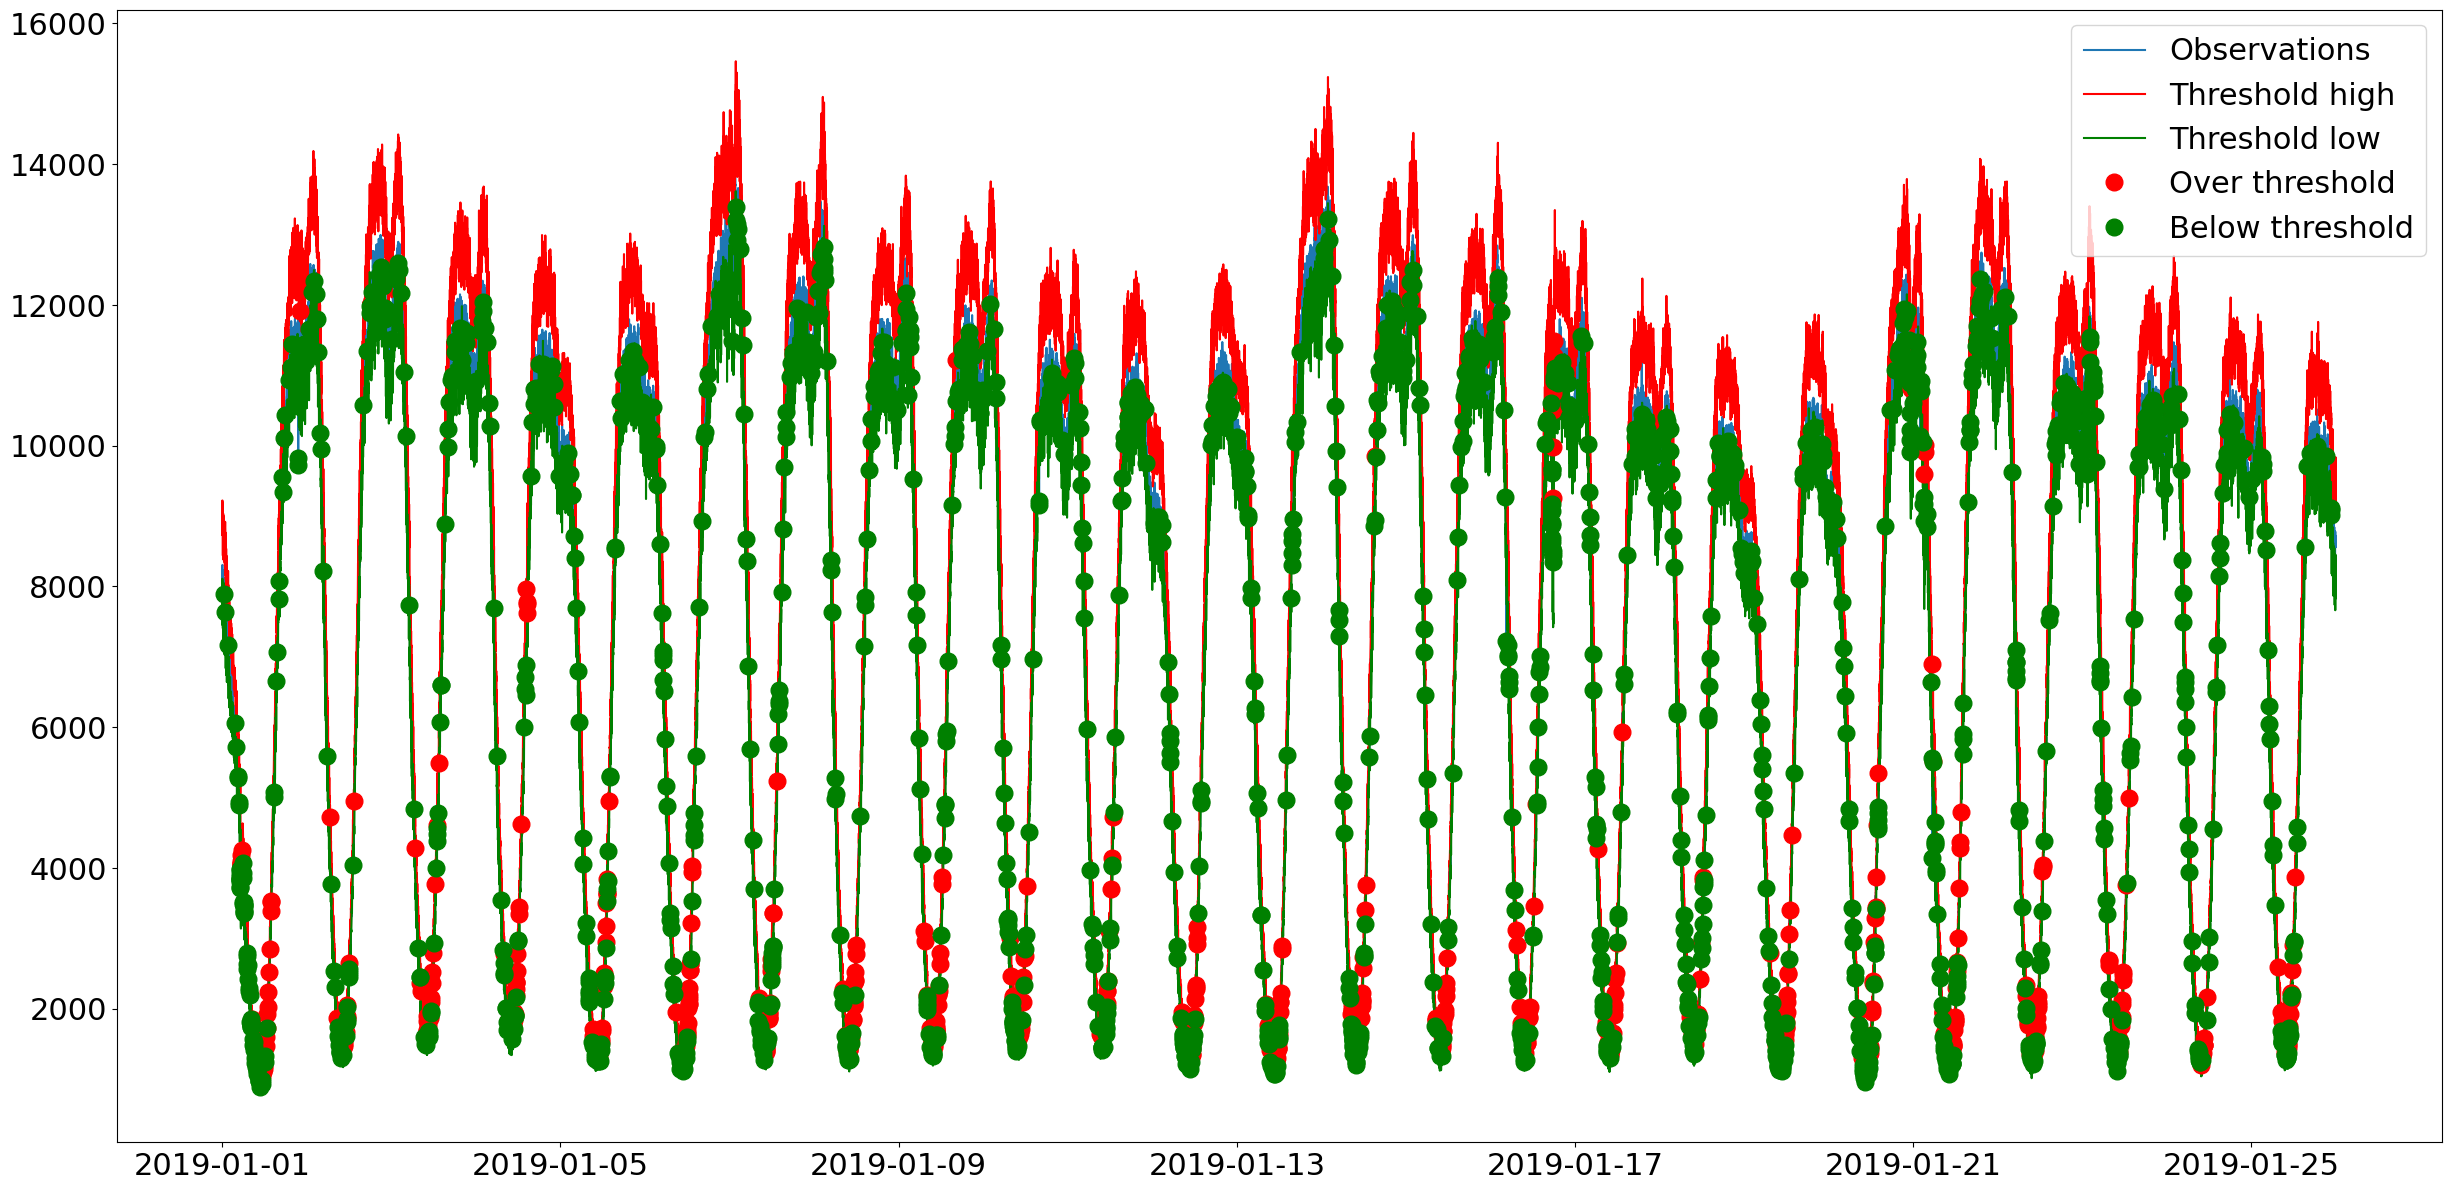

In [41]:
def plot_peaks_10():
    fig, ax = plt.subplots()
    #fig.set_size_inches(18.5, 10.5)
    
    ax.plot(d.timestamps[701280:701280+10*period_10], d.ts[701280:701280+10*period_10], label='Observations')
    ax.plot(d.timestamps[701280:701280+10*period_10], threshold_over_10, color='r', label='Threshold high')
    ax.plot(d.timestamps[701280:701280+10*period_10], threshold_below_10, color='g', label='Threshold low')
    
    ax.plot(d.timestamps[701280:701280+10*period_10], peakover_point_10, marker='o', color='r', linestyle = 'None', label='Over threshold', markersize = 12)
    ax.plot(d.timestamps[701280:701280+10*period_10], peakbelow_point_10, marker='o', color='g', linestyle = 'None', label='Below threshold', markersize = 12)
    
    ax.legend()
    
plot_peaks_10()

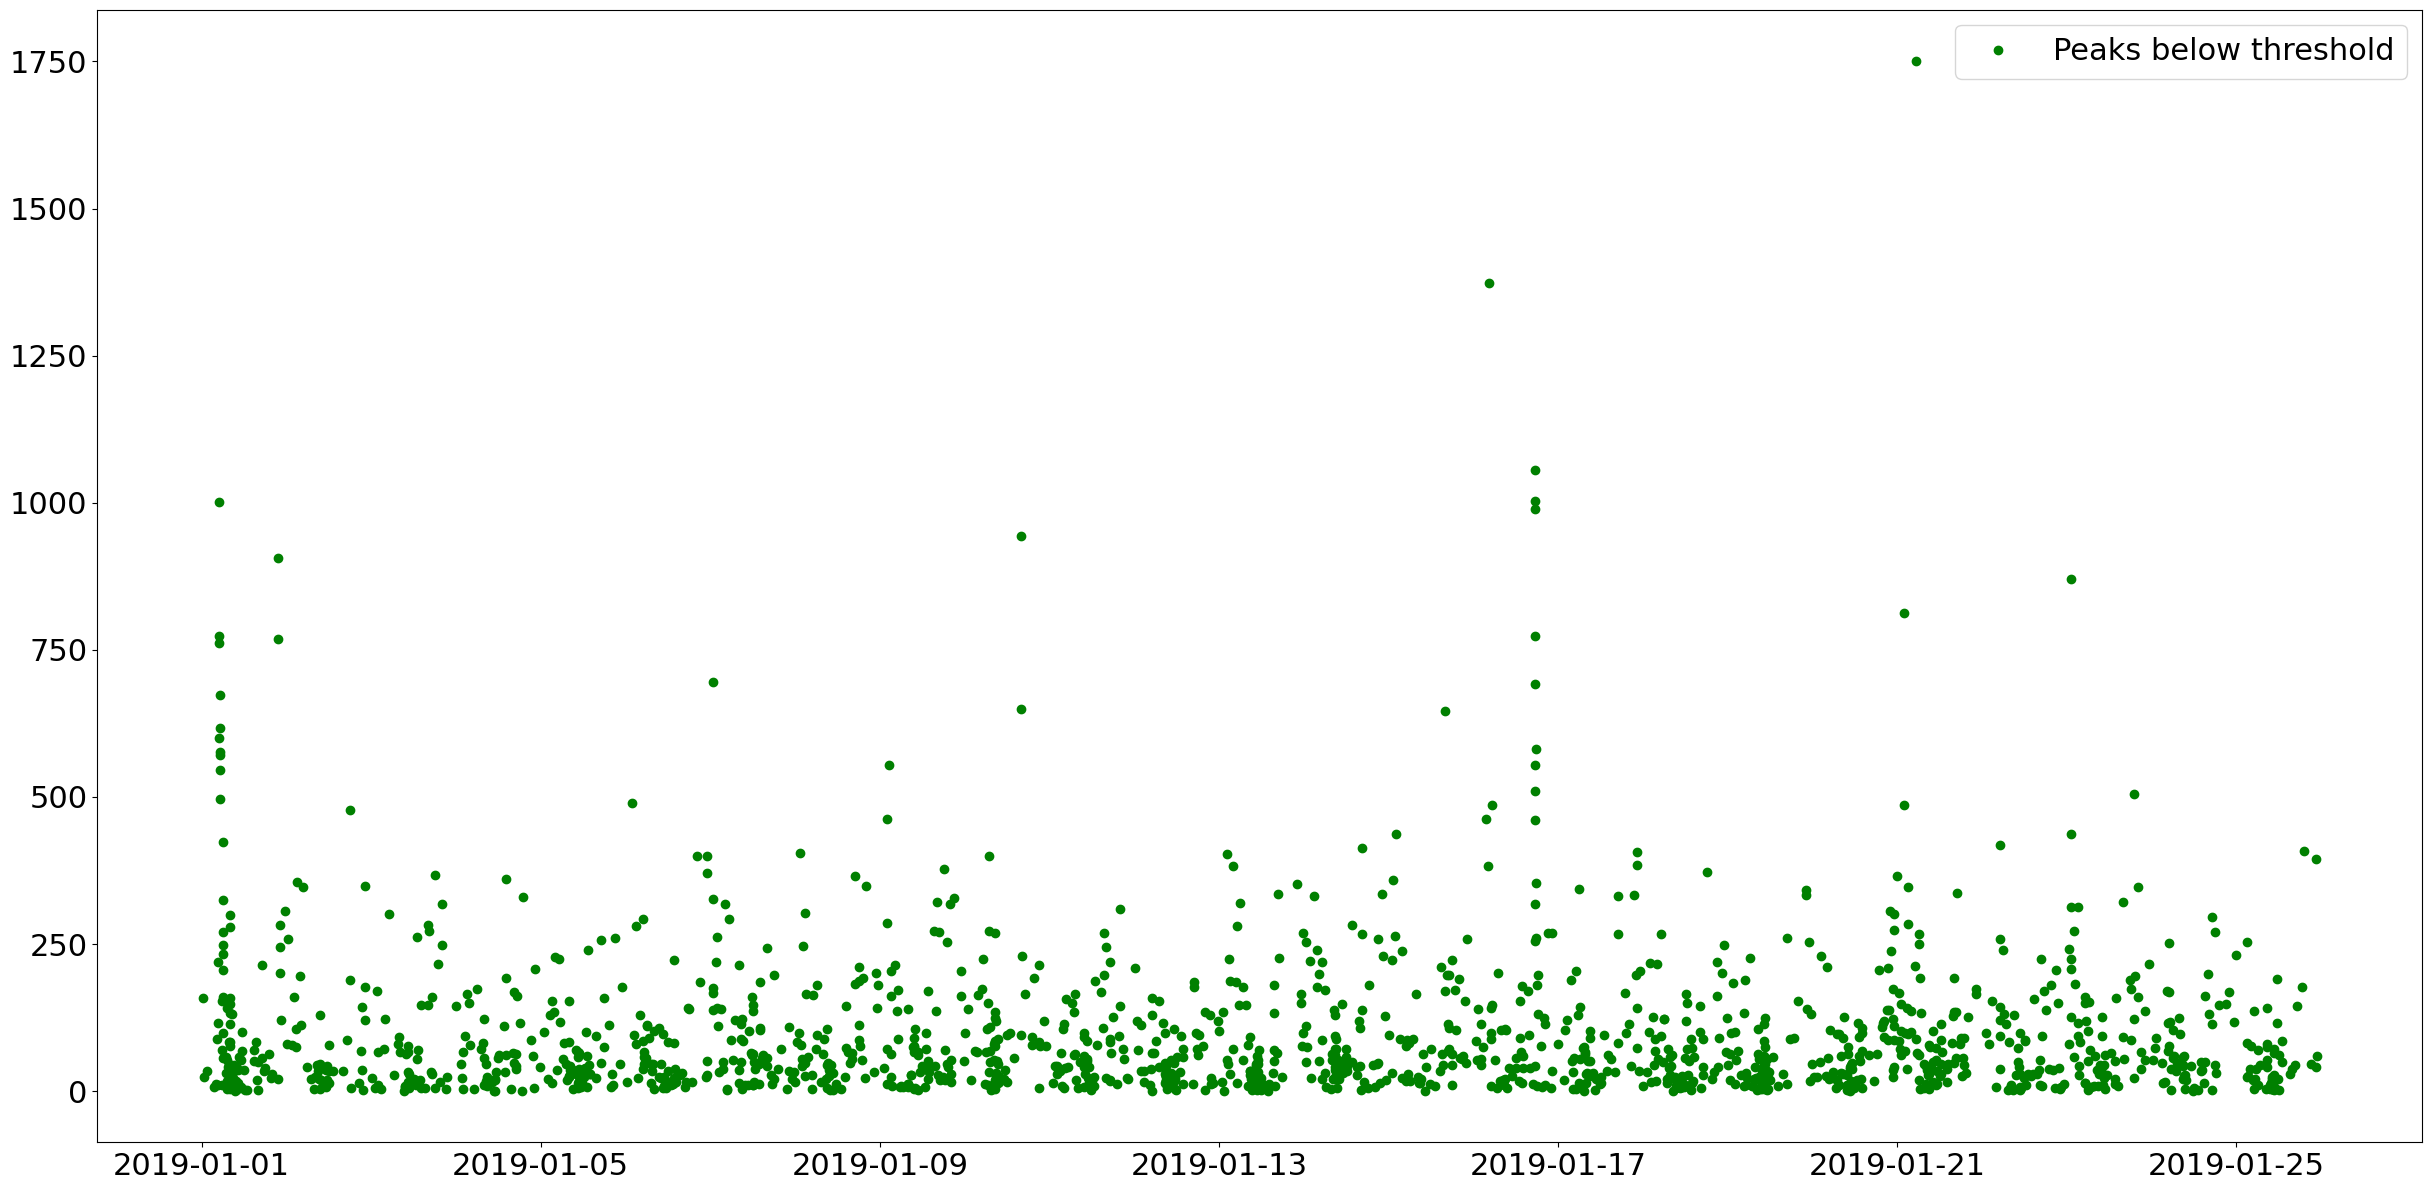

In [42]:
def plot_peakbelow_10():
    fig, ax = plt.subplots()
    #fig.set_size_inches(18.5, 10.5)

    ax.plot(d.timestamps[701280:701280+10*period_10], peakbelow_10, marker='o', color='g', linestyle = 'None', label='Peaks below threshold')
    #ax.plot(df['peak_over'], marker='o', color='r', linestyle = 'None', label='Peaks over threshold')
    ax.legend()

plot_peakbelow_10()

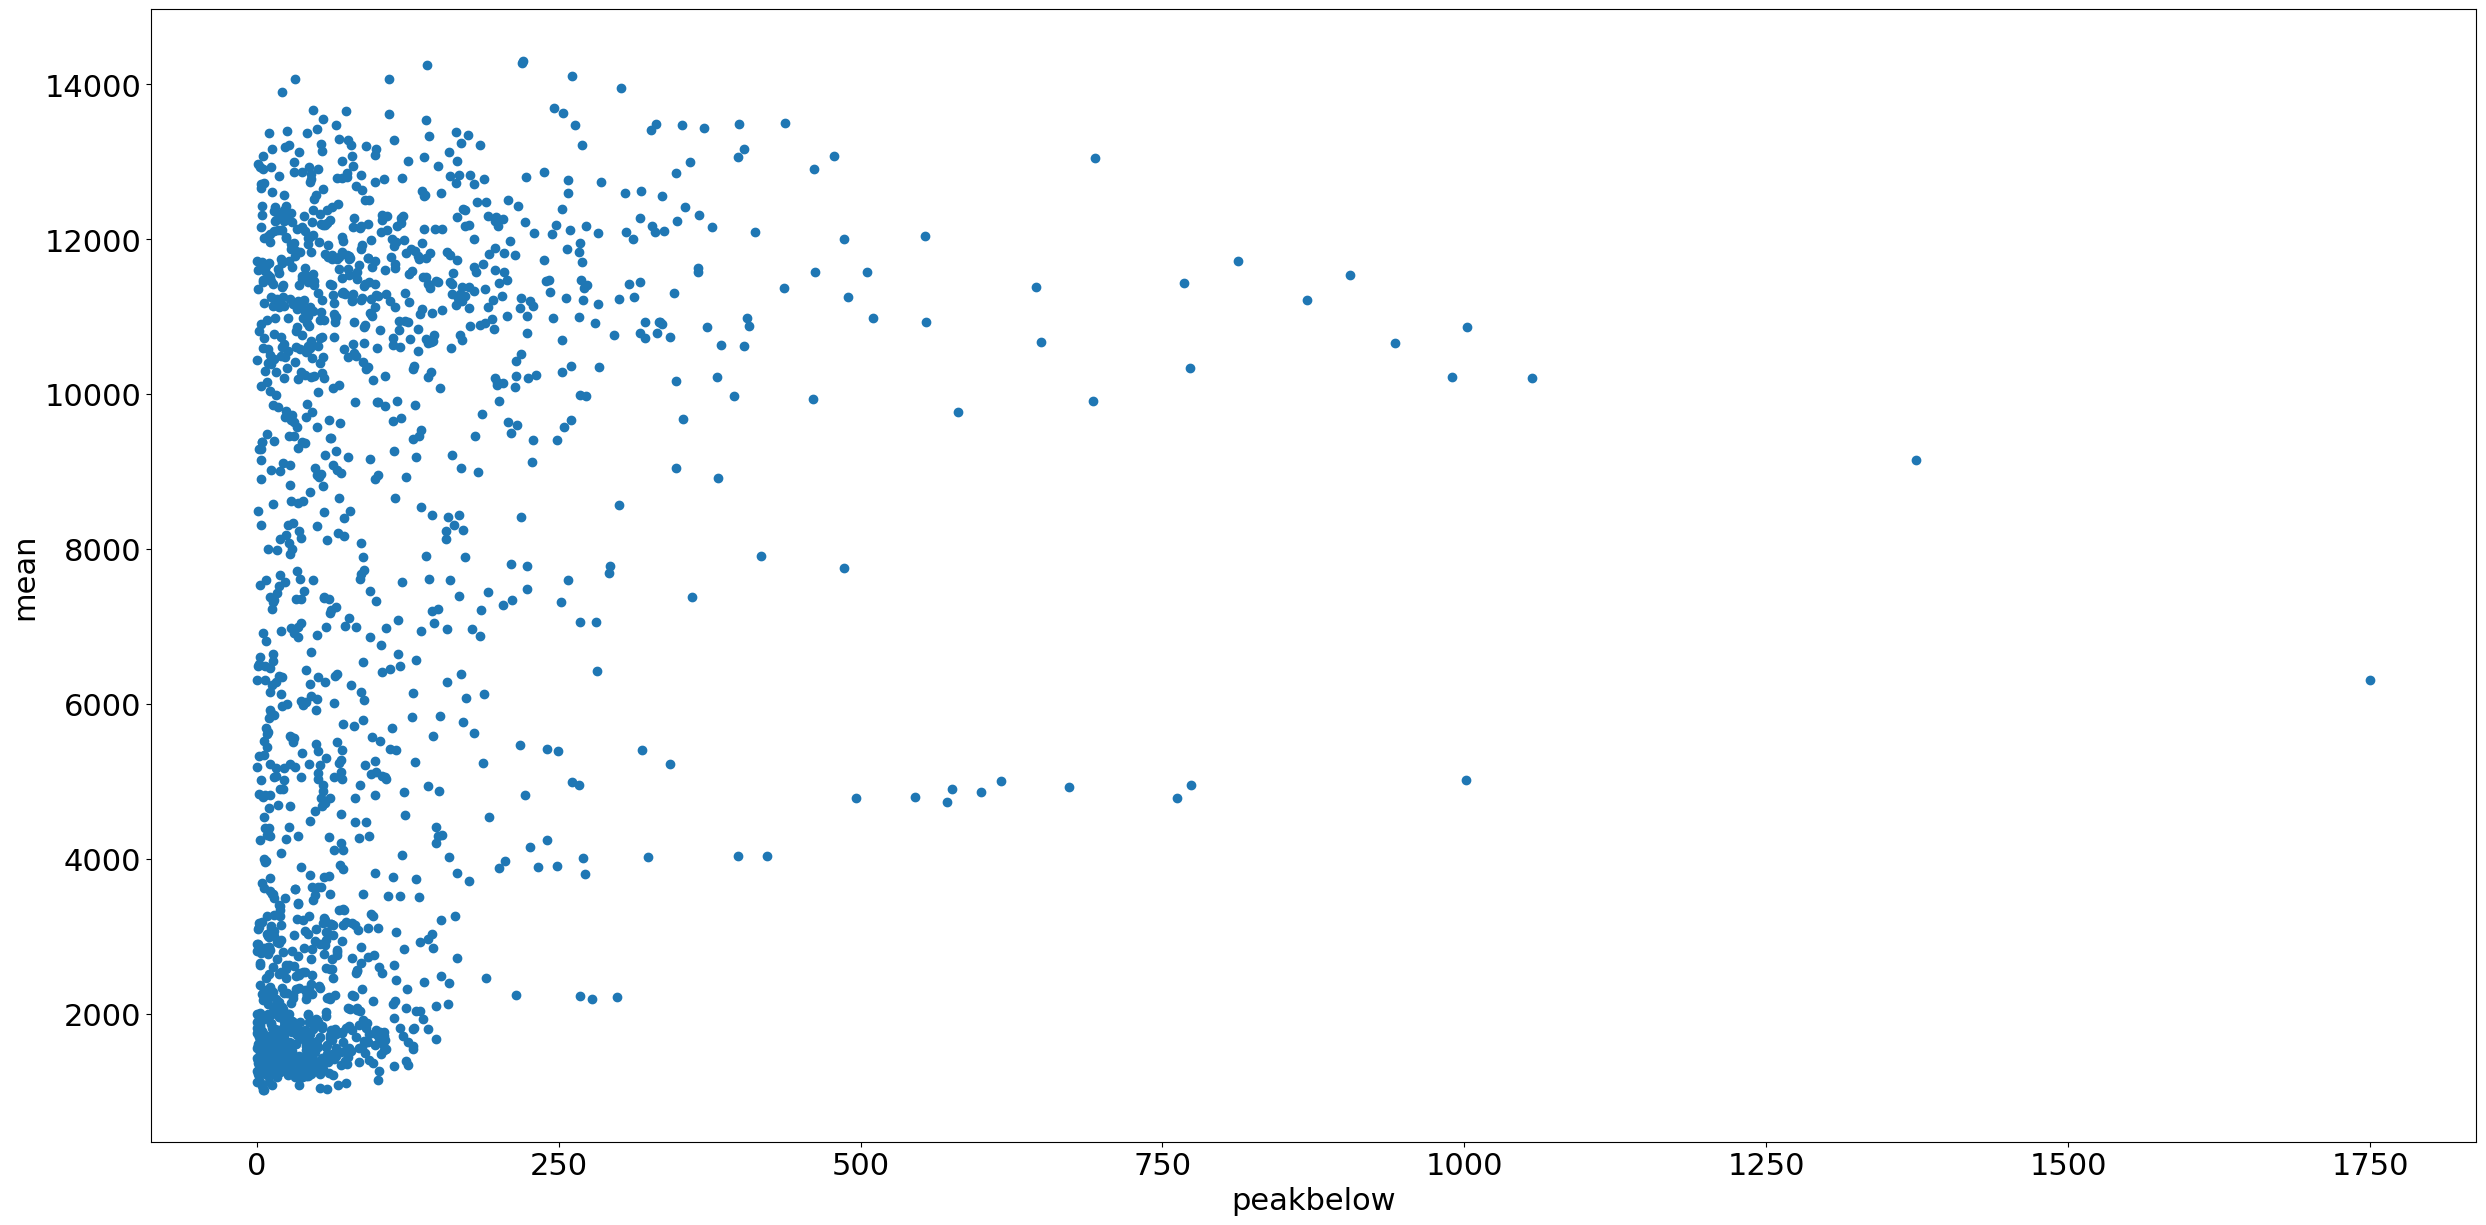

In [43]:
def plot_peakbelow_mean_10():
    plt.xlabel('peakbelow')
    plt.ylabel('mean')
    plt.scatter(peakbelow_10, mean_10)

plot_peakbelow_mean_10()

In [44]:
dataSeries_10 = pd.DataFrame({'observations': d.ts[701280:701280+10*period_10], 
                              'forecast_date': d.timestamps[701280:701280+10*period_10],
                              'mean': mean_10,
                              'peakbelow': peakbelow_10,
                              #'peakover': peakover_10,
                              #'threshold_over': threshold_over_10,
                              'threshold_below': threshold_below_10,
                              'mean': mean_10,})
dataSeries_10['forecast_date'] = pd.to_datetime(dataSeries_10['forecast_date'])
dataSeries_10 = dataSeries_10.set_index('forecast_date', drop=True)
dataSeries_10['hour'] = dataSeries_10.index.hour
dataSeries_10['dayofweek'] = dataSeries_10.index.dayofweek
dataSeries_10['weekofyear'] = dataSeries_10.index.weekofyear
dataSeries_10['month'] = dataSeries_10.index.month

dataSeries_10

observations         mean  peakbelow  threshold_below  \
forecast_date                                                                
2019-01-01 00:00:00        8131.0  8250.867188        NaN      7685.575684   
2019-01-01 00:01:00        8305.0  8369.996094        NaN      7770.134766   
2019-01-01 00:02:00        8157.0  8676.089844        NaN      8110.416016   
2019-01-01 00:03:00        7982.0  8392.589844        NaN      7894.710938   
2019-01-01 00:04:00        8228.0  8309.096680        NaN      7662.456543   
...                           ...          ...        ...              ...   
2019-01-25 23:55:00        8685.0  8682.414062        NaN      8013.249512   
2019-01-25 23:56:00        8720.0  8975.037109        NaN      8301.452148   
2019-01-25 23:57:00        8658.0  8649.924805        NaN      7920.226562   
2019-01-25 23:58:00        8656.0  8711.081055        NaN      7837.354980   
2019-01-25 23:59:00        8569.0  8717.999023        NaN      7930.460938   

                     hour  dayofweek  weekofyear  month  
forecast_date                                            
2019-01-01 00:00:00     0          1           1      1  
2019-01-01 00:01:00     0          1           1      1  
2019-01-01 00:02:00     0          1           1      1  
2019-01-01 00:03:00     0          1           1      1  
2019-01-01 00:04:00     0          1           1      1  
...                   ...        ...         ...    ...  
2019-01-25 23:55:00    23          4           4      1  
2019-01-25 23:56:00    23          4           4      1  
2019-01-25 23:57:00    23          4           4      1  
2019-01-25 23:58:00    23          4           4      1  
2019-01-25 23:59:00    23          4           4      1  

[36000 rows x 8 columns]

In [45]:
def mk_ds_extreme_10(df):
    feat_dynamic_cat = np.vstack([df.hour.values, df.dayofweek.values, df.month.values])
    feat_dynamic_real = np.vstack([df['mean'].values]) # , df.stderr.values, df.dof.values 
    
    target = df.peakbelow.values
    observed = [0 if np.isnan(x) else 1 for x in target]
    
    ds = ListDataset([{
        'feat_dynamic_cat': feat_dynamic_cat,
        'feat_dynamic_real': feat_dynamic_real,
        'target': [0 if np.isnan(x) else x for x in target],
        'start': '2019-01-01 00:00:00',
        'observed_values': observed
                      }],
        freq='1min'
    )
    return ds

train_ds_extreme_10 = mk_ds_extreme_10(dataSeries_10.tail(-1000).dropna())
test_df_extreme_10 = dataSeries_10.tail(10000).dropna()
test_ds_extreme_10 = mk_ds_extreme_10(test_df_extreme_10)

dataSeries_10.tail(-1000).dropna()

observations          mean   peakbelow  threshold_below  \
forecast_date                                                                  
2019-01-01 17:02:00        9551.0  10210.505859   55.354492      9606.354492   
2019-01-01 17:06:00        9348.0  10087.582031  213.906250      9561.906250   
2019-01-01 17:32:00       10114.0  10861.829102   33.221680     10147.221680   
2019-01-01 17:52:00       10435.0  11089.695312   39.090820     10474.090820   
2019-01-01 19:02:00       10933.0  11750.102539   62.117188     10995.117188   
...                           ...           ...         ...              ...   
2019-01-25 19:02:00        9740.0  10876.872070  407.738281     10147.738281   
2019-01-25 21:02:00        9848.0  10464.897461   45.372070      9893.372070   
2019-01-25 22:32:00        9092.0   9982.352539  394.868164      9486.868164   
2019-01-25 22:38:00        9015.0   9705.347656   40.904297      9055.904297   
2019-01-25 22:42:00        9116.0   9665.809570   60.019531      9176.019531   

                     hour  dayofweek  weekofyear  month  
forecast_date                                            
2019-01-01 17:02:00    17          1           1      1  
2019-01-01 17:06:00    17          1           1      1  
2019-01-01 17:32:00    17          1           1      1  
2019-01-01 17:52:00    17          1           1      1  
2019-01-01 19:02:00    19          1           1      1  
...                   ...        ...         ...    ...  
2019-01-25 19:02:00    19          4           4      1  
2019-01-25 21:02:00    21          4           4      1  
2019-01-25 22:32:00    22          4           4      1  
2019-01-25 22:38:00    22          4           4      1  
2019-01-25 22:42:00    22          4           4      1  

[1495 rows x 8 columns]

# SimpleFeedForward Model on the Extreme Values

In [46]:
trainer_extreme_10 = Trainer(
        epochs=50,
        batch_size=25,
        num_batches_per_epoch=100,
        learning_rate=1e-3,
        hybridize=False,
        )

In [47]:
prediction_length_10=20

model_extreme_10 = FeedForwardEstimator(
    freq='1min',
    prediction_length=prediction_length_10,
    num_hidden_dimensions=4*[20],
    context_length=180,
    trainer=trainer_extreme_10,
    mean_scaling=True,
    distr_output = PeakOverThresholdGeneralizedParetoOutput()
)

forecaster_extreme_10 = model_extreme_10.train_model(train_ds_extreme_10)
predictor_extreme_10 = forecaster_extreme_10.predictor

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:02<00:00, 42.22it/s, epoch=50/50, avg_epoch_loss=5.37]


In [48]:
pred_extreme_10 = predictor_extreme_10.predict(test_ds_extreme_10)
p_10 = next(iter(pred_extreme_10))
p_10.distribution

gluonts.distribution.transformed_distribution.TransformedDistribution(base_distribution=__main__.PeakOverThresholdGeneralizedPareto(F=None, concentration=mxnet.nd.array([0.04936131462454796, 0.05988852307200432, 0.08637387305498123, 0.05763765797019005, 0.05424526333808899, 0.07399013638496399, 0.04505154862999916, 0.034436192363500595, 0.08420037478208542, 0.05562625452876091, 0.03510615602135658, 0.04334680363535881, 0.025464175269007683, 0.03965297341346741, 0.026853185147047043, 0.04017559811472893, 0.04010678082704544, 0.03867018222808838, 0.07479403167963028, 0.09659133106470108], dtype=numpy.float32), scale=mxnet.nd.array([1.482954978942871, 1.656982183456421, 1.5744084119796753, 1.6973069906234741, 1.6043463945388794, 1.9097257852554321, 1.809942603111267, 2.026045322418213, 1.798084020614624, 1.77927827835083, 1.9510903358459473, 1.641637921333313, 1.7867543697357178, 1.7042937278747559, 1.5274277925491333, 1.822649359703064, 1.5028419494628906, 1.42697274684906, 1.46013510227

In [49]:
tss_extreme_10 = list(test_ds_extreme_10)
target_extreme_10 = tss_extreme_10[0]['target'][-prediction_length_10:]#mk_ds
threshold_extreme_10 = test_df_extreme_10.threshold_below.tail(prediction_length_10).values
peak_ratio_extreme_10 = dataSeries_10.peakbelow.notna().sum() / dataSeries_10.peakbelow.size
peak_ratio_extreme_10

0.043694444444444445

In [50]:
def plot_prob_forecasts_10(target, threshold, samples, test_df, prediction_length, alarm_level, peak_ratio, transforms):
    percentiles = [50, 75, 90, 95, 99]
    legend = ["observations", "threshold", "cutoff"] + [f"p{k} of the Generalized Pareto" for k in percentiles]

    idx = test_df.tail(prediction_length).index
    
    fig, ax = plt.subplots(prediction_length, 1, figsize=(10, 20 * prediction_length))
    
    # Compute the absolute target
    adjusted_target = threshold - target
    
    # Compute percentiles of the predictive distribution
    pct = np.percentile(samples, percentiles, axis=0)

    # Compute alarm cutoff 
    cutoff = p_10.distribution.base_distribution.base_distribution_quantile(
        level=alarm_level,
        threshold=mx.nd.array(threshold),
        peak_ratio=peak_ratio,
        transforms=transforms,
        below=True
    ).asnumpy()
    
    for sp in range(prediction_length):
        ax[sp].set_title(f"Date: {idx[sp]}\n Peak below: {target[sp]} \n Alarm quantile: {alarm_level}")

        # plot the time series
        pd.Series(adjusted_target[sp]).plot(ax=ax[sp], linestyle = 'None', marker = 'o', markersize=20 )  
        
        # plot the time series
        pd.Series(threshold[sp]).plot(ax=ax[sp], linestyle = 'None', marker = 'o', markersize=20, color='g')

        # plot the cut-off
        pd.Series(cutoff[sp]).plot(ax=ax[sp], linestyle = 'None', marker = '^', markersize=20, color='r')
        
        # plot the percentiles of the GPD
        for i in range(len(percentiles)):
            adjusted_percentile = threshold - pct[i,:]
            pd.Series(data=adjusted_percentile[sp]).plot(
                    ax=ax[sp], marker='X', markersize=10, color=cm.hot(i/len(percentiles)), linestyle = 'None')


        ax[sp].grid(which="both")

    fig.legend(legend, loc="best")
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


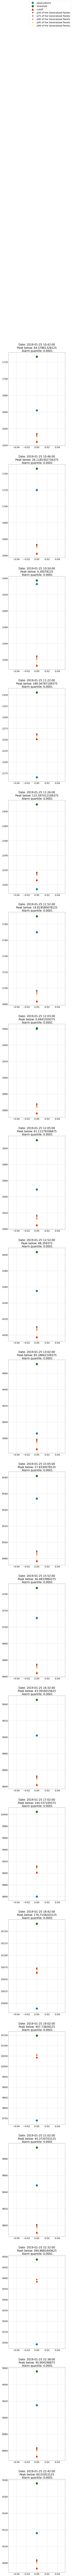

In [51]:
samples_extreme_10 = p_10.distribution.sample(1000).asnumpy()
alarm_level = 1e-4

plot_prob_forecasts_10(target_extreme_10,
                       threshold_extreme_10,
                       samples_extreme_10,
                       test_df_extreme_10,
                       prediction_length_10,
                       alarm_level,
                       peak_ratio_extreme_10,
                       p_10.distribution.transforms)

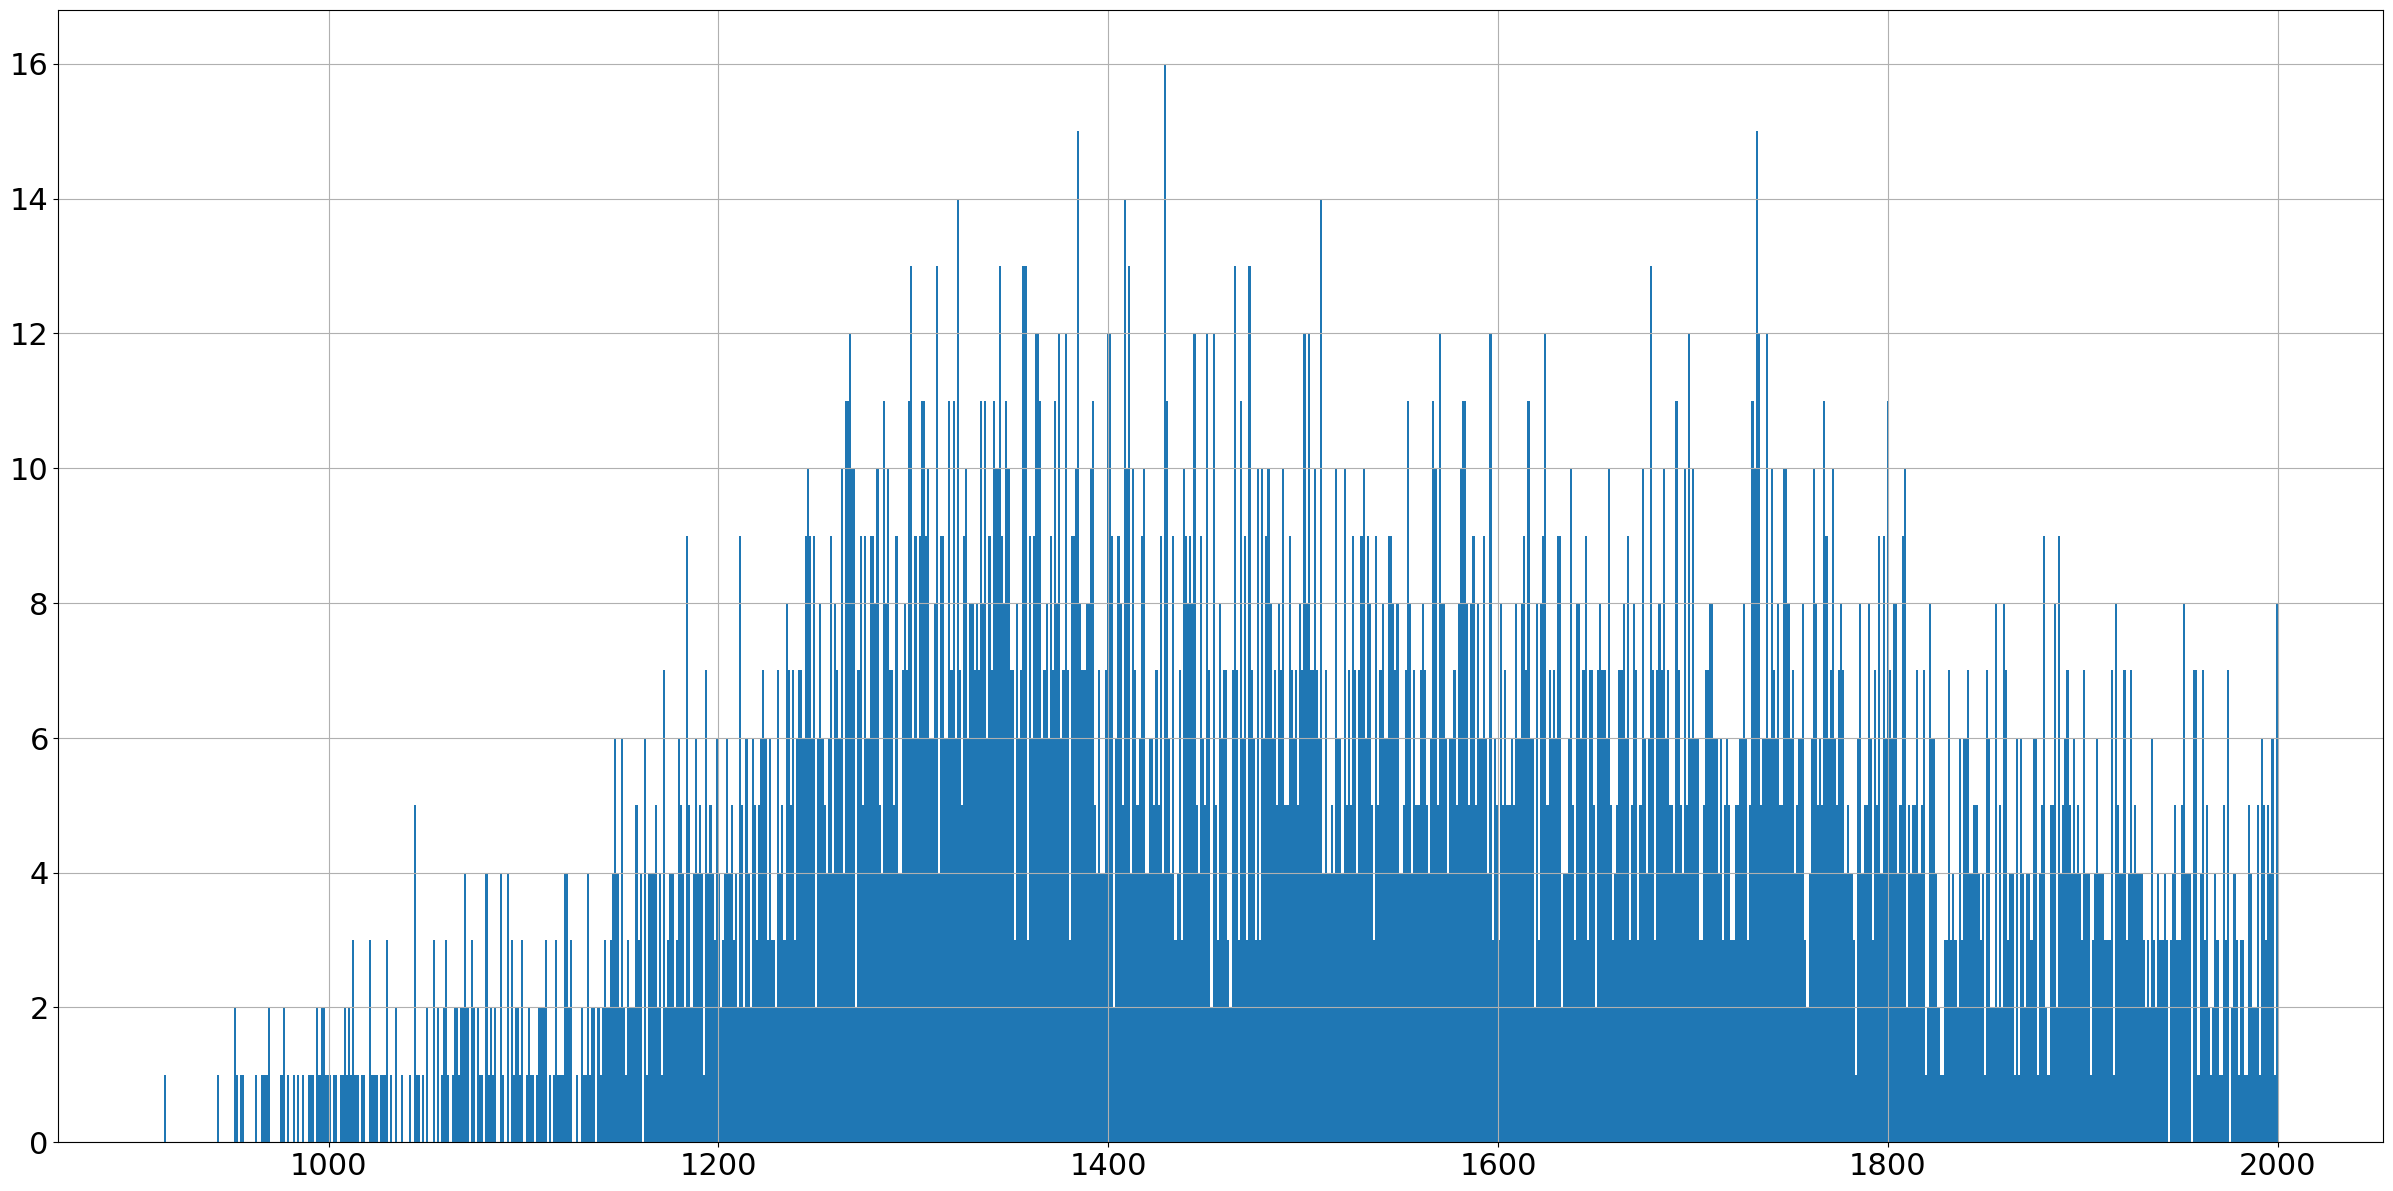

In [52]:
#dataSeries_10.observations[dataSeries_10.observations<2000].hist(bins=1000)
dataSeries_10['mean'][dataSeries_10['mean']<2000].hist(bins=1000)

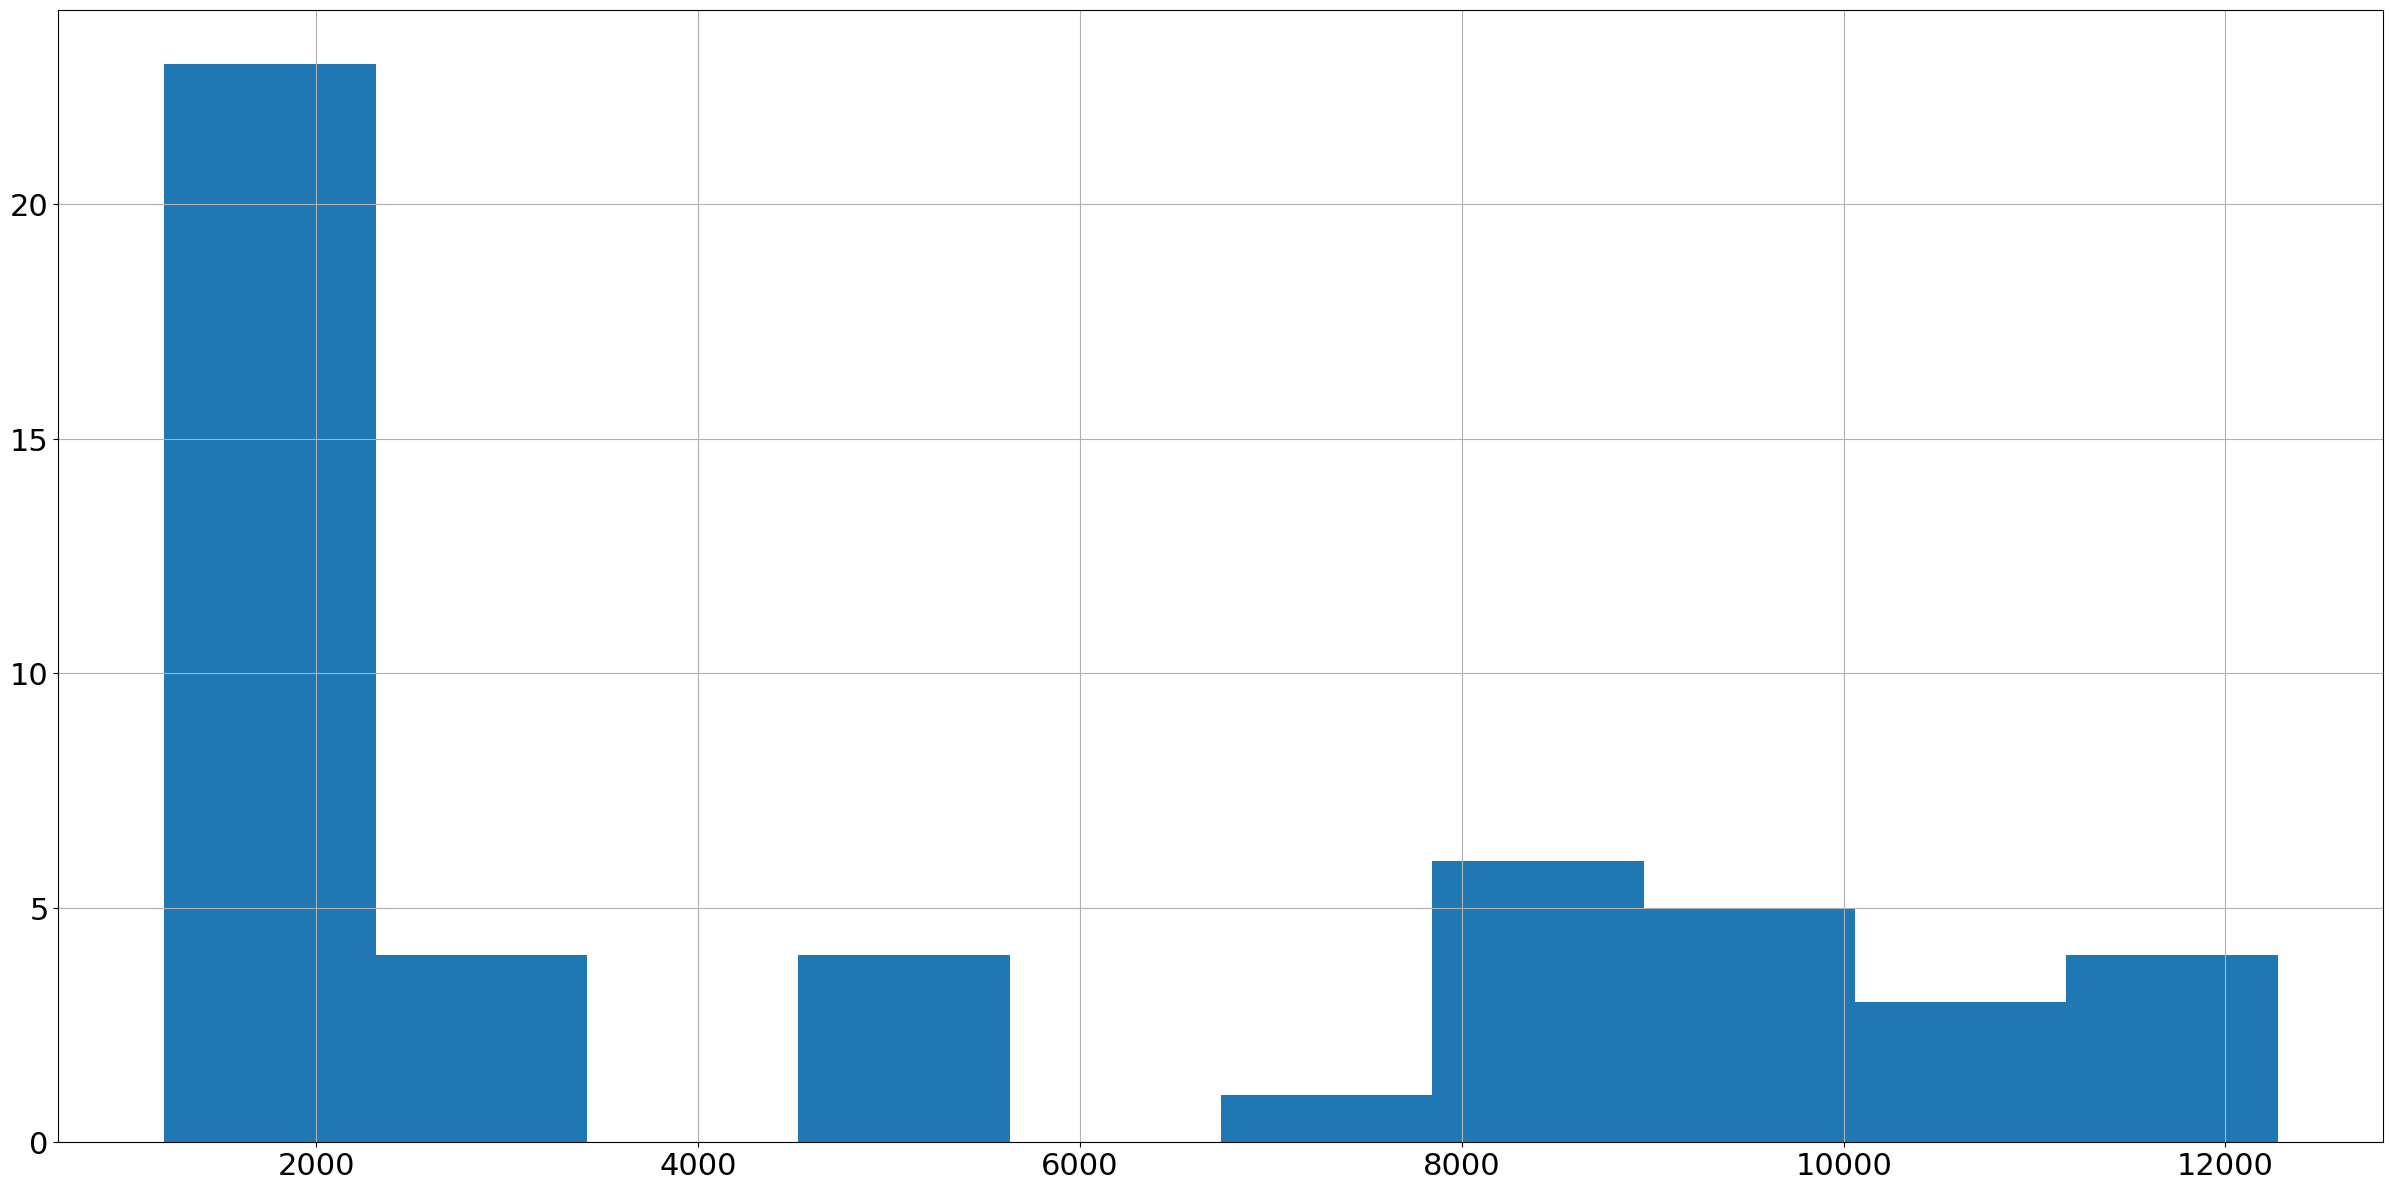

In [53]:
test_df_extreme.observations.hist(bins=10)

# StudentT, prediction_length=10, context_length=60

In [54]:
from gluonts.distribution import StudentTOutput

estimator_10_t = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=10,
    context_length=60,
    freq='1min',
    trainer = Trainer(
        epochs=50,
        batch_size=25,
        num_batches_per_epoch=100,
        learning_rate=1e-3,
        hybridize=False,
        ),
    distr_output = StudentTOutput()
)

predictor_10_t = estimator_10_t.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [03:42<00:00,  2.22s/it, epoch=50/50, avg_epoch_loss=6.6]


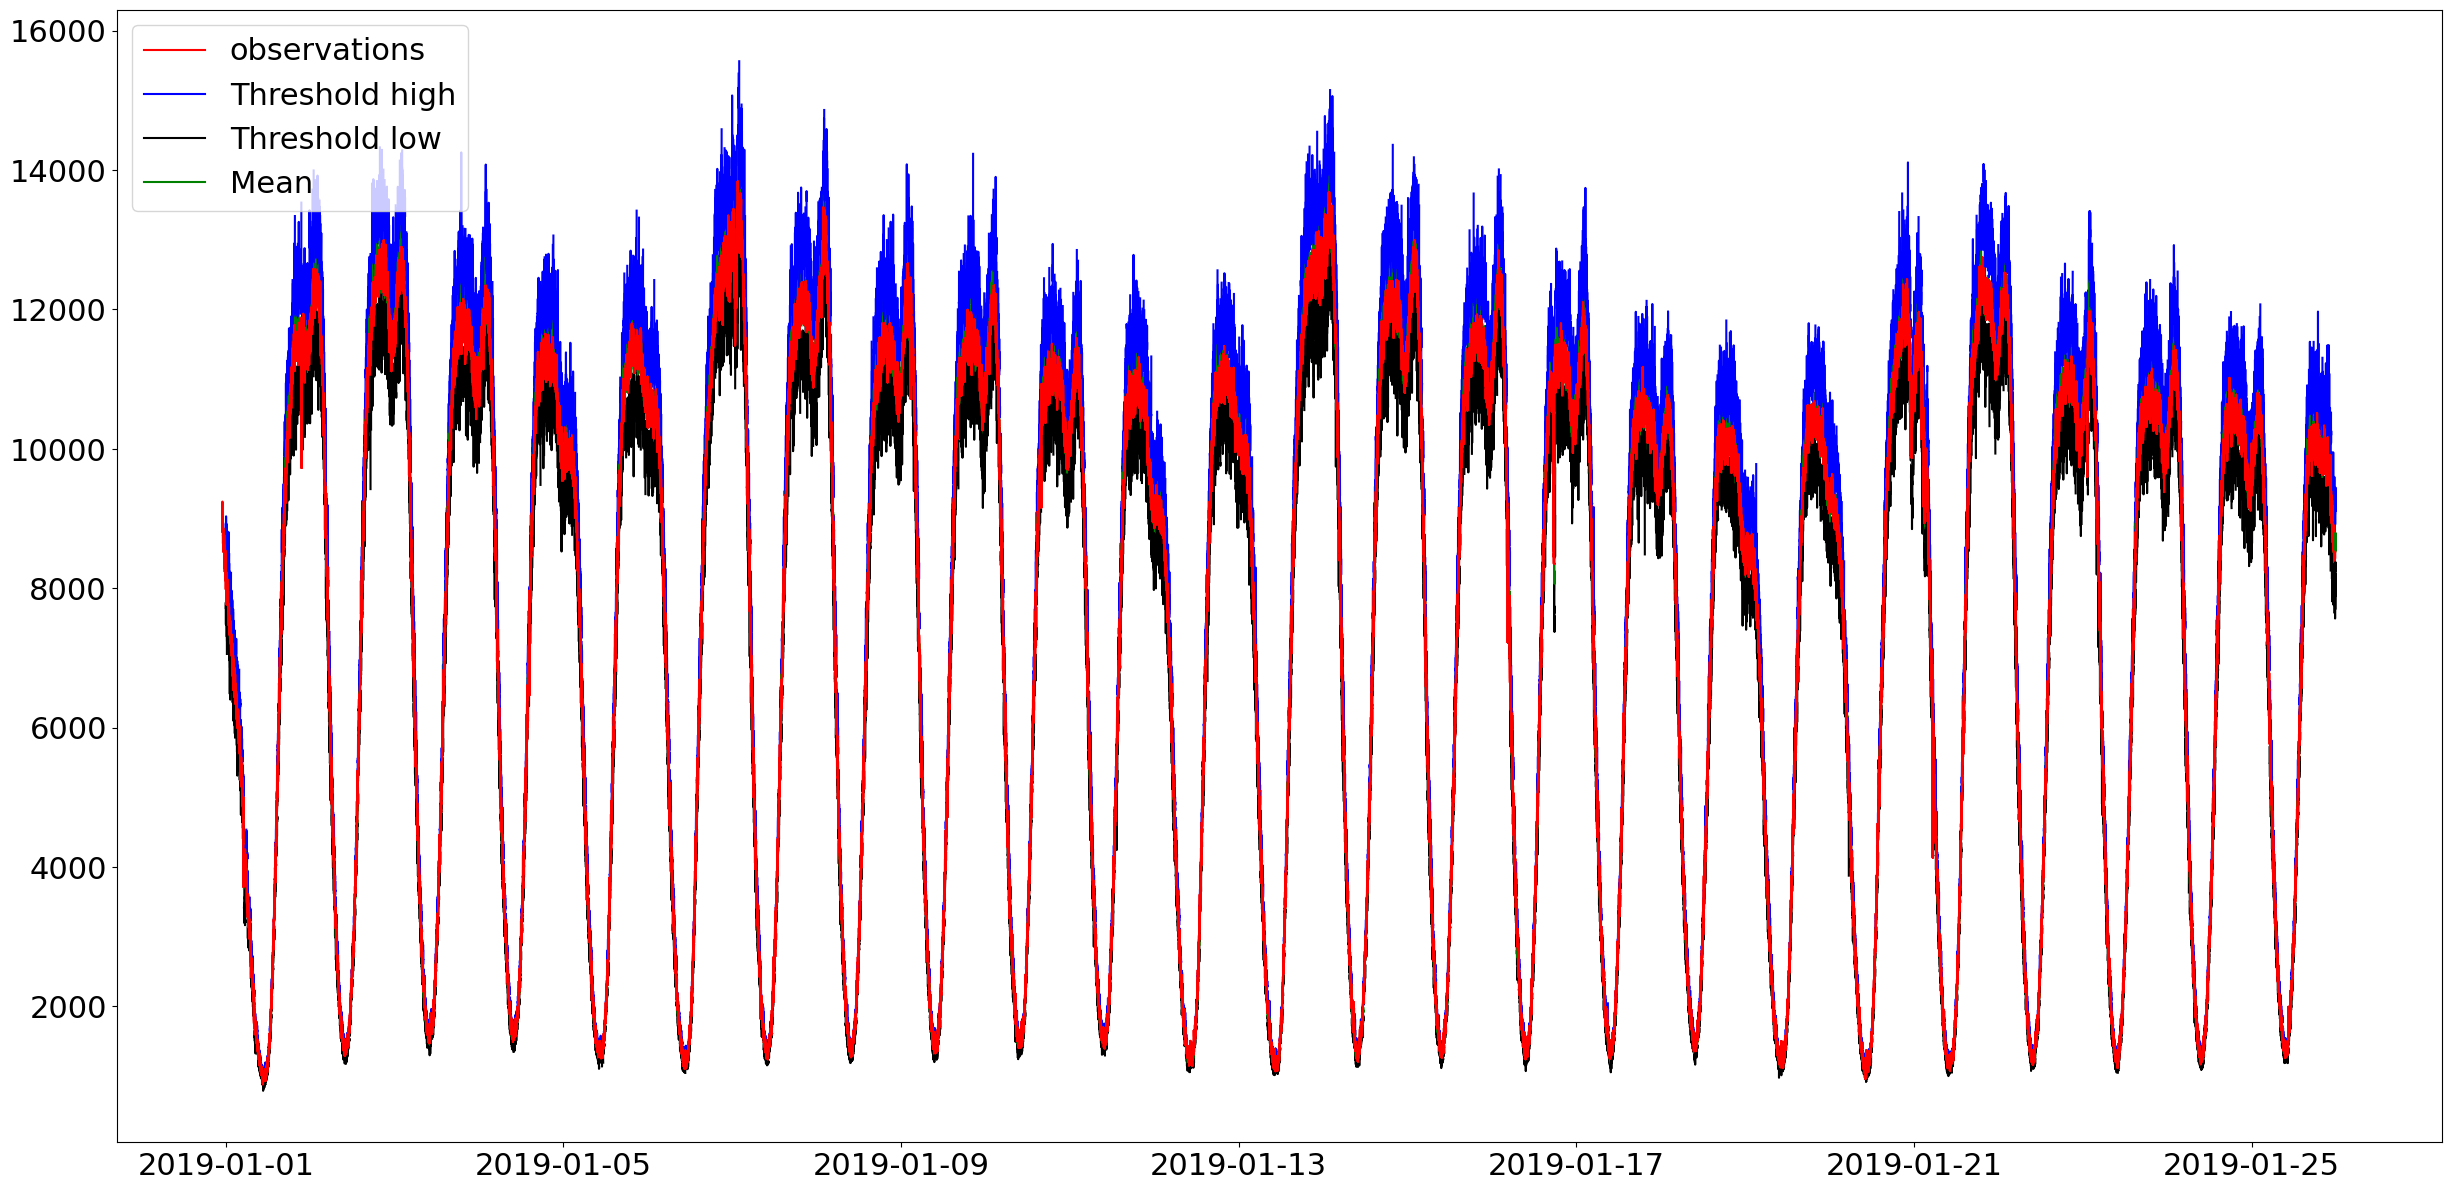

In [55]:
fig_10_t, ax_10_t = plt.subplots(1, 1)

def plot_prob_forecasts_10_t(recur, ts_entry, forecast_entry):
    plot_length = 60+10
#     prediction_intervals = (50.0,98.0)
#     legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    prediction_intervals = [98.0]
#     legend = ["observations", "median prediction"] + [f"{prediction_intervals[0]}% prediction interval"]
    legend = ["observations", "Threshold high", "Threshold low", "Mean"]
#     fig, ax = plt.subplots(1, 1)
#     ts_entry[-plot_length:].plot(ax=ax, color='r')  # plot the time series
    ax_10_t.plot(ts_entry, color='r', label='observations')
#     print(ts_entry)
#     forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax_10_t.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.quantile(0.98), color='b', label='Threshold high')
    ax_10_t.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.quantile(0.02), color='black', label='Threshold low')
    ax_10_t.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.mean, color='g', label='Mean')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")

peakover_10_t = []
peakbelow_10_t = []
peakover_point_10_t = []
peakbelow_point_10_t = []
threshold_over_10_t = []
threshold_below_10_t = []
mean_10_t = []

period_10_t = 3600
    
for recur_10_t in range(period_10_t):
    test_ds_10_t = mk_ds(d[701280-60*1+10*recur_10_t:701280-60*1+10*recur_10_t+60*1+10]) #End: 1347422

    forecast_it_10_t, ts_it_10_t = make_evaluation_predictions(
        dataset=test_ds_10_t,  # test dataset
        predictor=predictor_10_t,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts_10_t = list(forecast_it_10_t)
    tss_10_t = list(ts_it_10_t)

    # first entry of the time series list
    ts_entry_10_t = tss_10_t[0]

    # first entry of test_ds
    test_ds_entry_10_t = next(iter(test_ds_10_t))

    # first entry of the forecast list
    forecast_entry_10_t = forecasts_10_t[0]
    
    #Compute the threshold above and below the series, and compute the extreme values
    threshold_over_10_t.extend(forecast_entry_10_t.quantile(0.98))
    threshold_below_10_t.extend(forecast_entry_10_t.quantile(0.02))
    mean_10_t.extend(forecast_entry_10_t.mean)
#     print(ts_entry_10_t)
#     print(len(ts_entry_10_t))
    for i_10_t in range(len(forecast_entry_10_t.quantile(0.98))):
        threshold_high_10_t = (forecast_entry_10_t.quantile(0.98))[i_10_t]
        threshold_low_10_t = (forecast_entry_10_t.quantile(0.02))[i_10_t]
        peakover_10_t.append(ts_entry_10_t[0][60+i_10_t] - threshold_high_10_t if ts_entry_10_t[0][60+i_10_t] - threshold_high_10_t >= 0 else np.nan)
        peakbelow_10_t.append(threshold_low_10_t - ts_entry_10_t[0][60+i_10_t] if ts_entry_10_t[0][60+i_10_t] - threshold_low_10_t <= 0 else np.nan)
        peakover_point_10_t.append(ts_entry_10_t[0][60+i_10_t] if ts_entry_10_t[0][60+i_10_t] - threshold_high_10_t >= 0 else np.nan)
        peakbelow_point_10_t.append(ts_entry_10_t[0][60+i_10_t] if ts_entry_10_t[0][60+i_10_t] - threshold_low_10_t <= 0 else np.nan)

    plot_prob_forecasts_10_t(recur_10_t, ts_entry_10_t, forecast_entry_10_t)

plt.show()

In [56]:
dataSeries_10_t = pd.DataFrame({'observations': d.ts[701280:701280+10*period_10_t], 
                              'forecast_date': d.timestamps[701280:701280+10*period_10_t],
                              'mean': mean_10_t,
                              'peakbelow': peakbelow_10_t,
                              #'peakover': peakover_10_t,
                              #'threshold_over': threshold_over_10_t,
                              'threshold_below': threshold_below_10_t,
                              'mean': mean_10_t,})
dataSeries_10_t['forecast_date'] = pd.to_datetime(dataSeries_10_t['forecast_date'])
dataSeries_10_t = dataSeries_10_t.set_index('forecast_date', drop=True)
dataSeries_10_t['hour'] = dataSeries_10_t.index.hour
dataSeries_10_t['dayofweek'] = dataSeries_10_t.index.dayofweek
dataSeries_10_t['weekofyear'] = dataSeries_10_t.index.weekofyear
dataSeries_10_t['month'] = dataSeries_10_t.index.month

dataSeries_10_t

observations         mean  peakbelow  threshold_below  \
forecast_date                                                                
2019-01-01 00:00:00        8131.0  8166.691406        NaN      7715.639648   
2019-01-01 00:01:00        8305.0  8394.355469        NaN      7796.001953   
2019-01-01 00:02:00        8157.0  8193.666992        NaN      7477.858398   
2019-01-01 00:03:00        7982.0  8285.798828        NaN      7764.163574   
2019-01-01 00:04:00        8228.0  8245.165039        NaN      7800.455566   
...                           ...          ...        ...              ...   
2019-01-25 23:55:00        8685.0  8688.530273        NaN      8042.580078   
2019-01-25 23:56:00        8720.0  8560.203125        NaN      8030.910156   
2019-01-25 23:57:00        8658.0  8733.500977        NaN      7883.944824   
2019-01-25 23:58:00        8656.0  8534.986328        NaN      8065.723633   
2019-01-25 23:59:00        8569.0  8747.488281        NaN      8200.550781   

                     hour  dayofweek  weekofyear  month  
forecast_date                                            
2019-01-01 00:00:00     0          1           1      1  
2019-01-01 00:01:00     0          1           1      1  
2019-01-01 00:02:00     0          1           1      1  
2019-01-01 00:03:00     0          1           1      1  
2019-01-01 00:04:00     0          1           1      1  
...                   ...        ...         ...    ...  
2019-01-25 23:55:00    23          4           4      1  
2019-01-25 23:56:00    23          4           4      1  
2019-01-25 23:57:00    23          4           4      1  
2019-01-25 23:58:00    23          4           4      1  
2019-01-25 23:59:00    23          4           4      1  

[36000 rows x 8 columns]

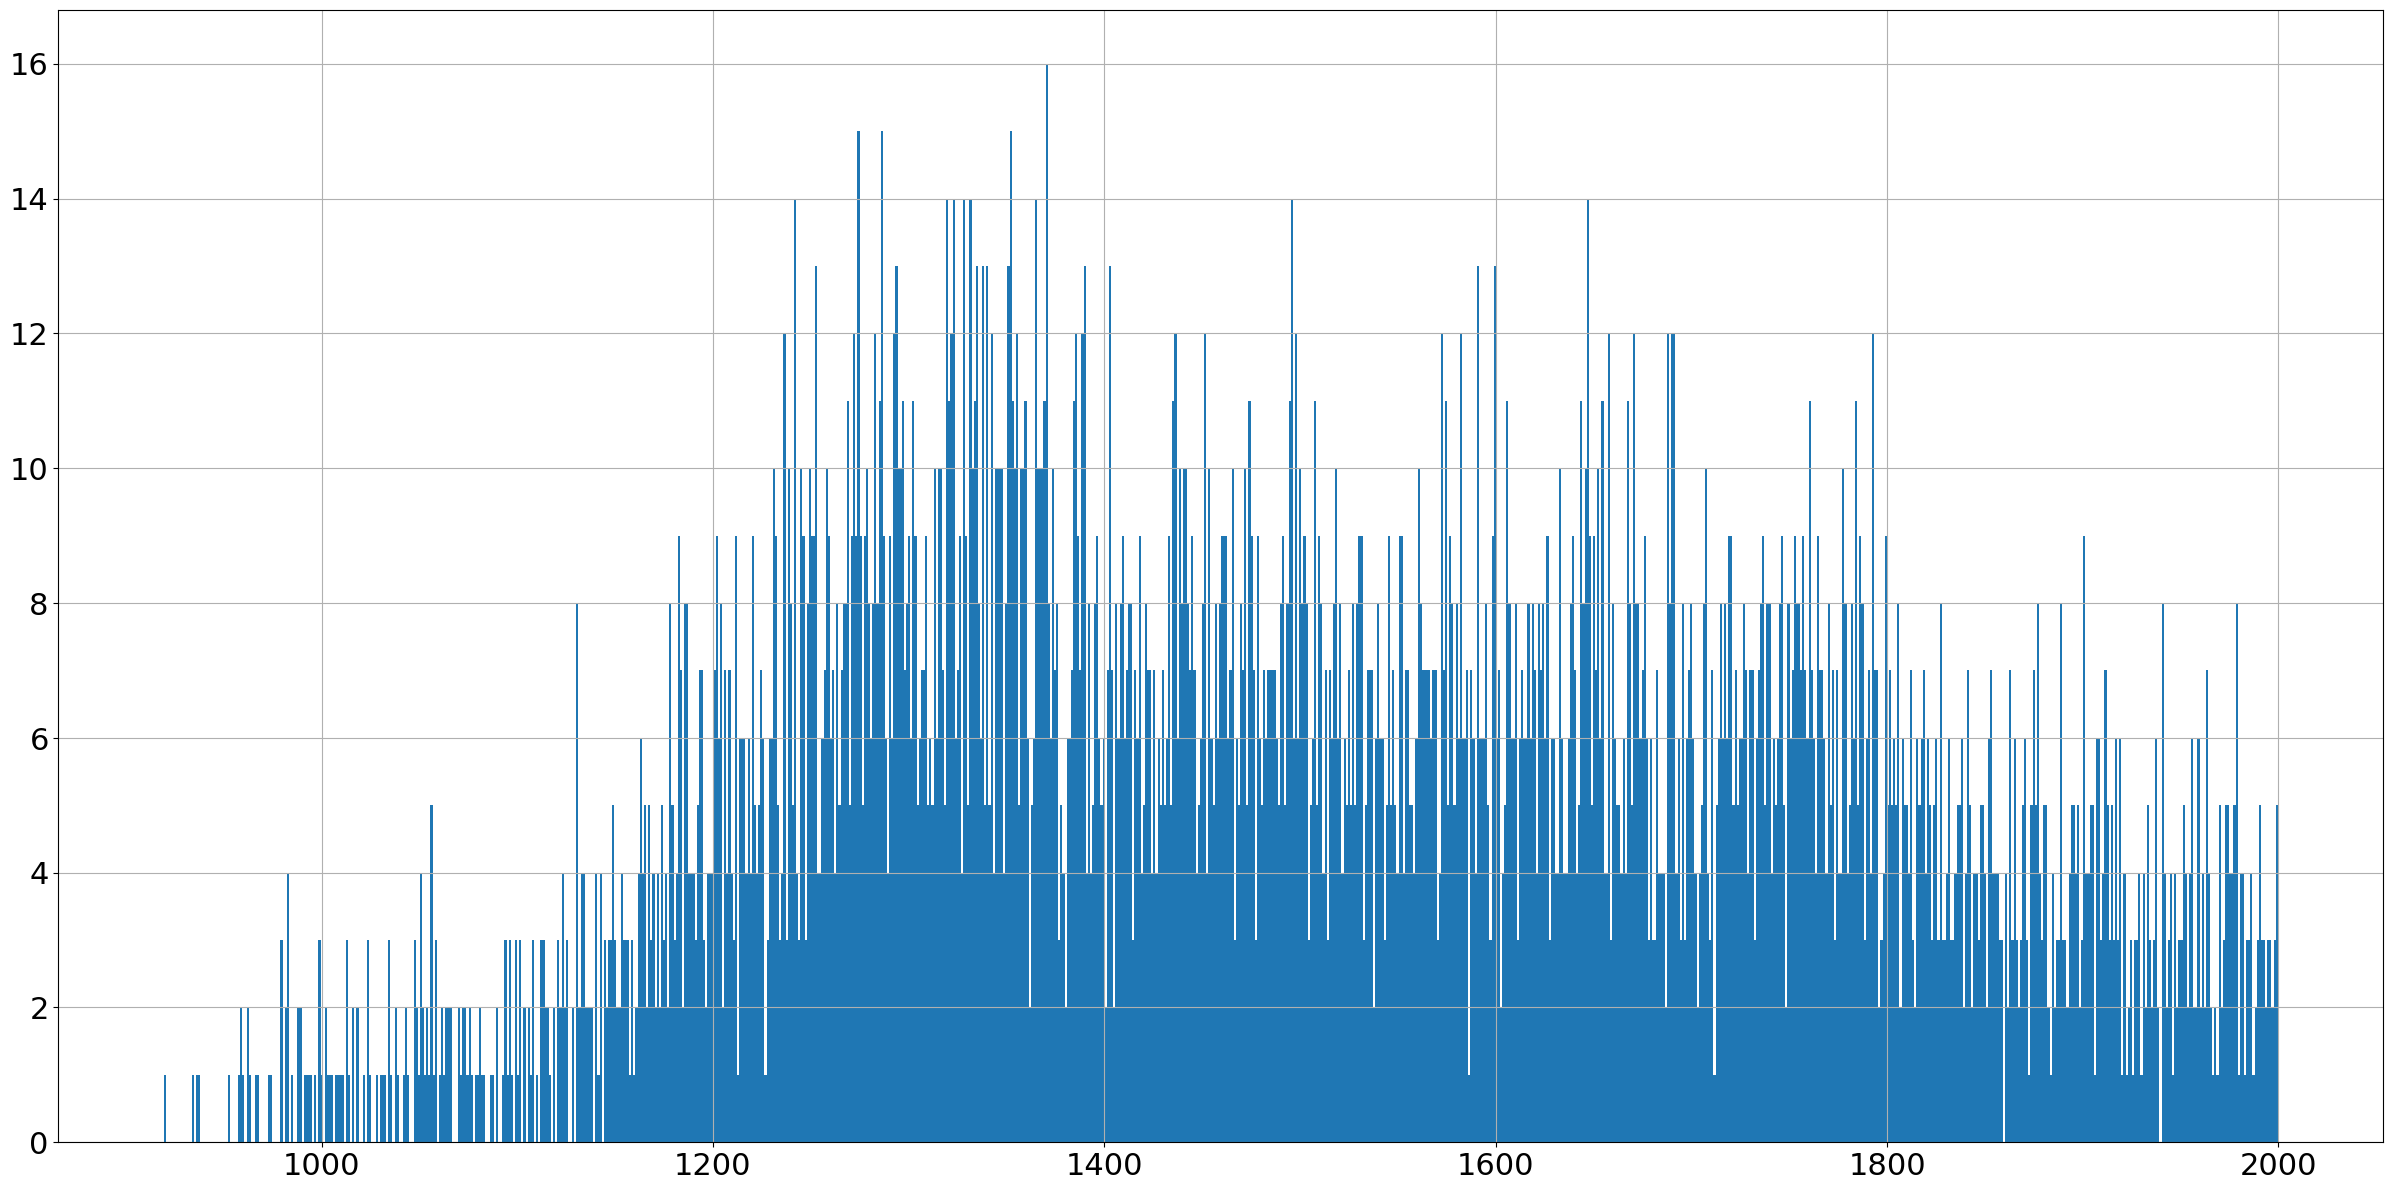

In [57]:
#dataSeries_10_t.observations[dataSeries_10_t.observations<2000].hist(bins=1000)
dataSeries_10_t['mean'][dataSeries_10_t['mean']<2000].hist(bins=1000)

# LogitNormal, prediction_length=10, context_length=60

In [68]:
from gluonts.distribution import LogitNormalOutput

estimator_10_log = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=10,
    context_length=60,
    freq='1min',
    trainer = Trainer(
        epochs=50,#50
        batch_size=25,
        num_batches_per_epoch=100,
        learning_rate=1e-5,#1e-3
        hybridize=False,
        ),
    distr_output = LogitNormalOutput()
)

predictor_10_log = estimator_10_log.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [05:52<00:00,  3.52s/it, epoch=50/50, avg_epoch_loss=-3.52]


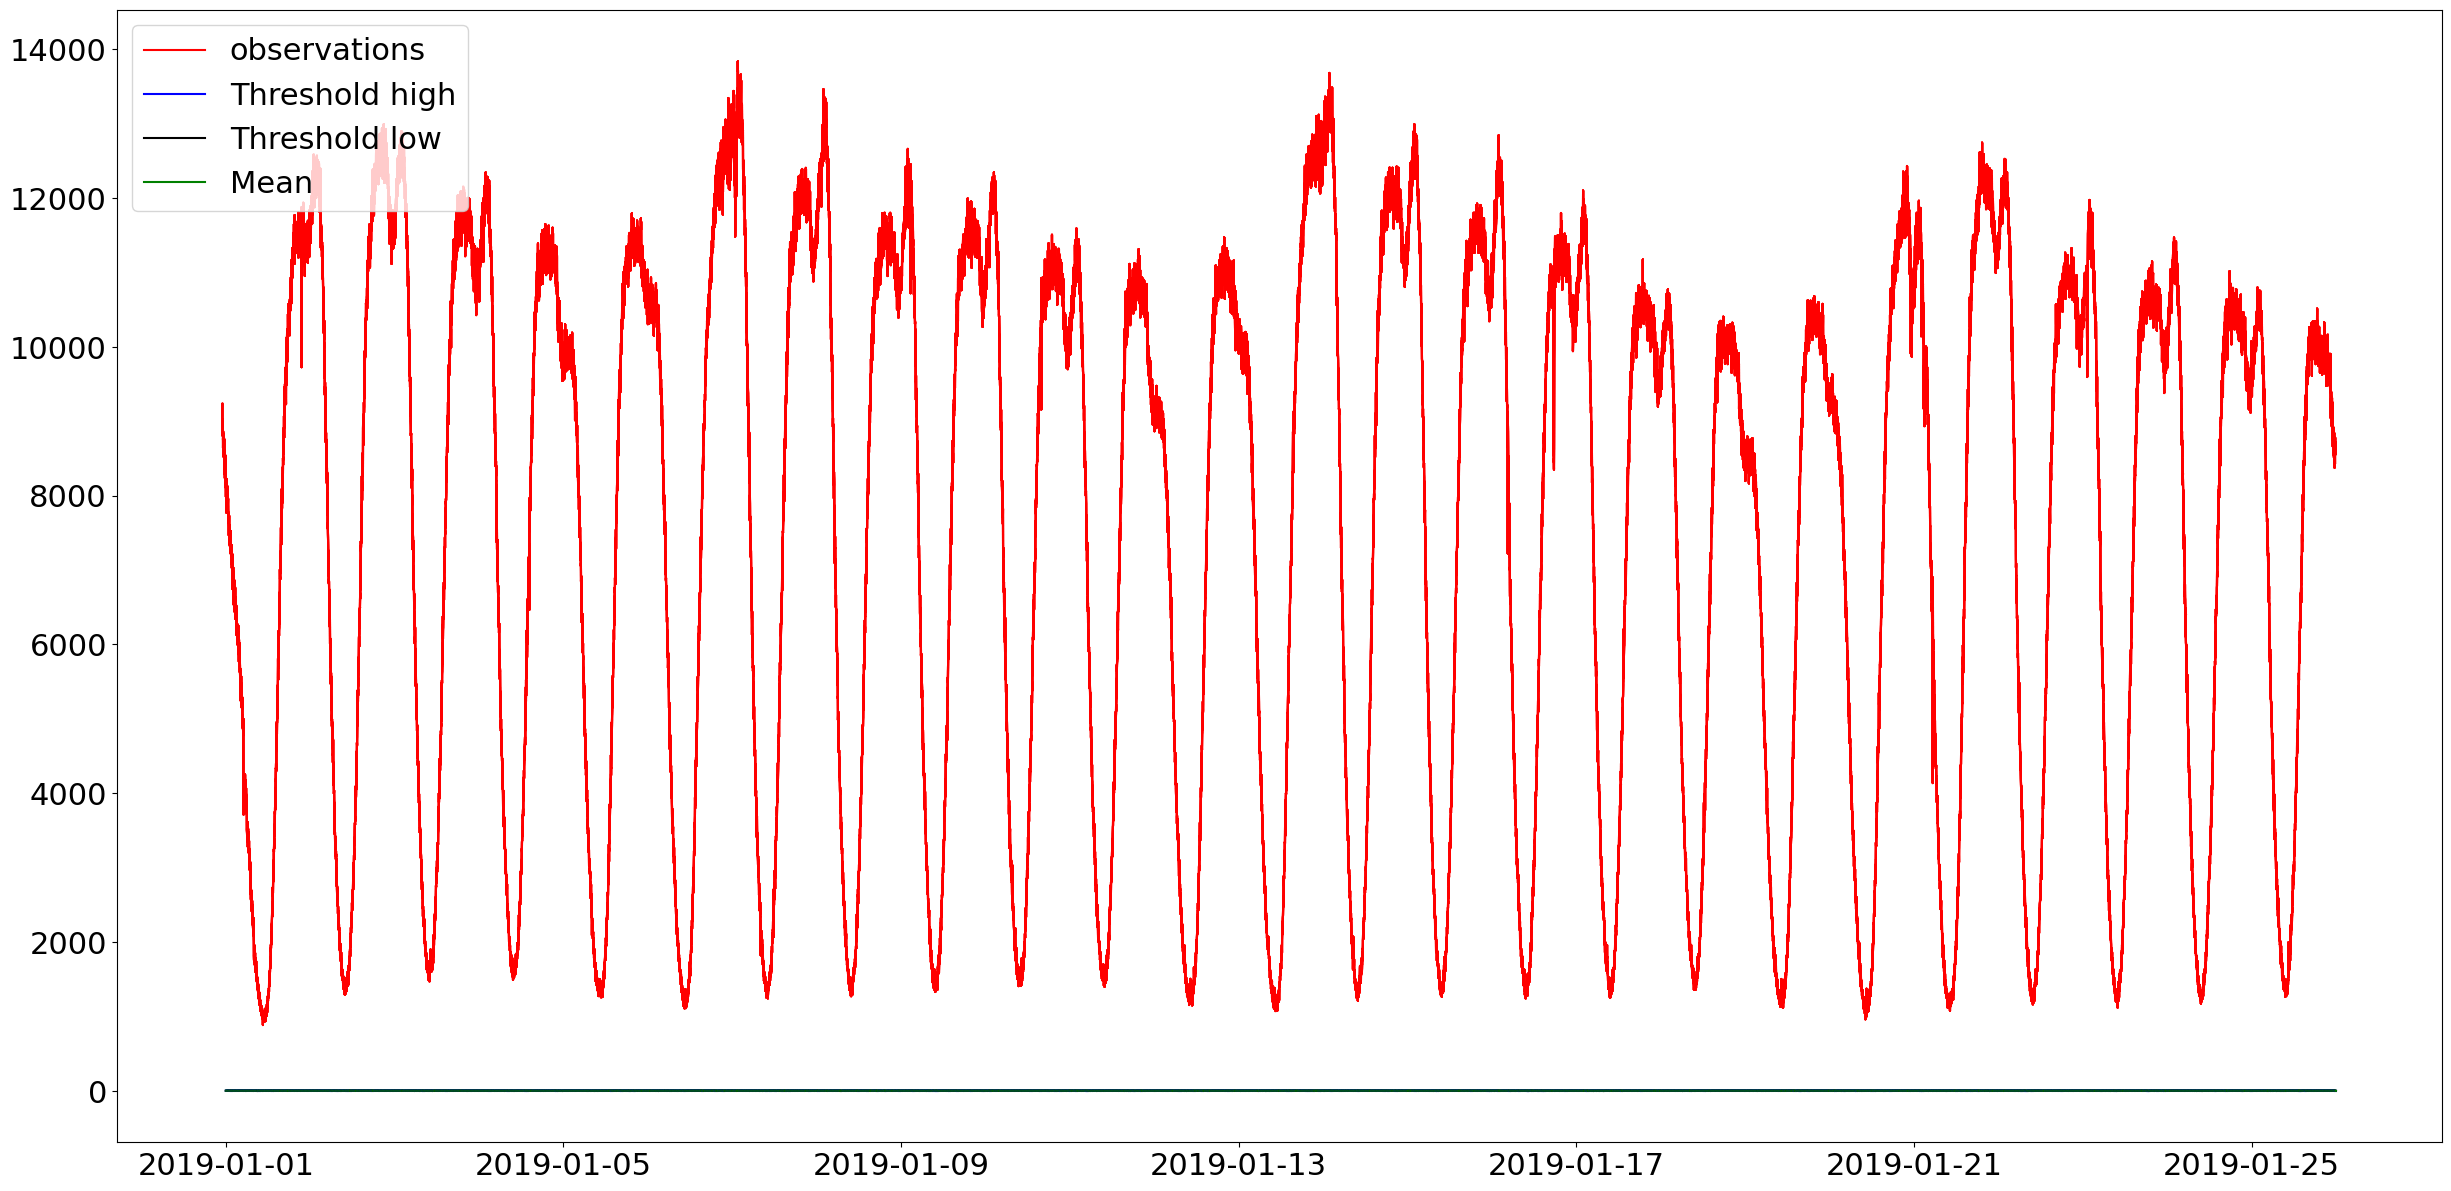

In [69]:
fig_10_log, ax_10_log = plt.subplots(1, 1)

def plot_prob_forecasts_10_log(recur, ts_entry, forecast_entry):
    plot_length = 60+10
#     prediction_intervals = (50.0,98.0)
#     legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    prediction_intervals = [98.0]
#     legend = ["observations", "median prediction"] + [f"{prediction_intervals[0]}% prediction interval"]
    legend = ["observations", "Threshold high", "Threshold low", "Mean"]
#     fig, ax = plt.subplots(1, 1)
#     ts_entry[-plot_length:].plot(ax=ax, color='r')  # plot the time series
    ax_10_log.plot(ts_entry, color='r', label='observations')
#     print(ts_entry)
#     forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax_10_log.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.quantile(0.98), color='b', label='Threshold high')
    ax_10_log.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.quantile(0.02), color='black', label='Threshold low')
    ax_10_log.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.mean, color='g', label='Mean')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")

peakover_10_log = []
peakbelow_10_log = []
peakover_point_10_log = []
peakbelow_point_10_log = []
threshold_over_10_log = []
threshold_below_10_log = []
mean_10_log = []

period_10_log = 3600
    
for recur_10_log in range(period_10_log):
    test_ds_10_log = mk_ds(d[701280-60*1+10*recur_10_log:701280-60*1+10*recur_10_log+60*1+10]) #End: 1347422

    forecast_it_10_log, ts_it_10_log = make_evaluation_predictions(
        dataset=test_ds_10_log,  # test dataset
        predictor=predictor_10_log,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts_10_log = list(forecast_it_10_log)
    tss_10_log = list(ts_it_10_log)

    # first entry of the time series list
    ts_entry_10_log = tss_10_log[0]

    # first entry of test_ds
    test_ds_entry_10_log = next(iter(test_ds_10_log))

    # first entry of the forecast list
    forecast_entry_10_log = forecasts_10_log[0]
    
    #Compute the threshold above and below the series, and compute the extreme values
    threshold_over_10_log.extend(forecast_entry_10_log.quantile(0.98))
    threshold_below_10_log.extend(forecast_entry_10_log.quantile(0.02))
    mean_10_log.extend(forecast_entry_10_log.mean)
#     print(ts_entry_10_log)
#     print(len(ts_entry_10_log))
    for i_10_log in range(len(forecast_entry_10_log.quantile(0.98))):
        threshold_high_10_log = (forecast_entry_10_log.quantile(0.98))[i_10_log]
        threshold_low_10_log = (forecast_entry_10_log.quantile(0.02))[i_10_log]
        peakover_10_log.append(ts_entry_10_log[0][60+i_10_log] - threshold_high_10_log if ts_entry_10_log[0][60+i_10_log] - threshold_high_10_log >= 0 else np.nan)
        peakbelow_10_log.append(threshold_low_10_log - ts_entry_10_log[0][60+i_10_log] if ts_entry_10_log[0][60+i_10_log] - threshold_low_10_log <= 0 else np.nan)
        peakover_point_10_log.append(ts_entry_10_log[0][60+i_10_log] if ts_entry_10_log[0][60+i_10_log] - threshold_high_10_log >= 0 else np.nan)
        peakbelow_point_10_log.append(ts_entry_10_log[0][60+i_10_log] if ts_entry_10_log[0][60+i_10_log] - threshold_low_10_log <= 0 else np.nan)

    plot_prob_forecasts_10_log(recur_10_log, ts_entry_10_log, forecast_entry_10_log)

plt.show()

In [70]:
dataSeries_10_log = pd.DataFrame({'observations': d.ts[701280:701280+10*period_10_log], 
                              'forecast_date': d.timestamps[701280:701280+10*period_10_log],
                              'mean': mean_10_log,
                              'peakbelow': peakbelow_10_log,
                              #'peakover': peakover_10_log,
                              #'threshold_over': threshold_over_10_log,
                              'threshold_below': threshold_below_10_log,
                              'mean': mean_10_log,})
dataSeries_10_log['forecast_date'] = pd.to_datetime(dataSeries_10_log['forecast_date'])
dataSeries_10_log = dataSeries_10_log.set_index('forecast_date', drop=True)
dataSeries_10_log['hour'] = dataSeries_10_log.index.hour
dataSeries_10_log['dayofweek'] = dataSeries_10_log.index.dayofweek
dataSeries_10_log['weekofyear'] = dataSeries_10_log.index.weekofyear
dataSeries_10_log['month'] = dataSeries_10_log.index.month

dataSeries_10_log

observations      mean  peakbelow  threshold_below  hour  \
forecast_date                                                                   
2019-01-01 00:00:00        8131.0  0.808098        NaN         0.003237     0   
2019-01-01 00:01:00        8305.0  0.773466        NaN         0.041128     0   
2019-01-01 00:02:00        8157.0  0.742461        NaN         0.021928     0   
2019-01-01 00:03:00        7982.0  0.576532        NaN         0.016476     0   
2019-01-01 00:04:00        8228.0  0.485703        NaN         0.001762     0   
...                           ...       ...        ...              ...   ...   
2019-01-25 23:55:00        8685.0  0.639198        NaN         0.001143    23   
2019-01-25 23:56:00        8720.0  0.774961        NaN         0.004353    23   
2019-01-25 23:57:00        8658.0  0.658314        NaN         0.029986    23   
2019-01-25 23:58:00        8656.0  0.796409        NaN         0.085827    23   
2019-01-25 23:59:00        8569.0  0.550219        NaN         0.000851    23   

                     dayofweek  weekofyear  month  
forecast_date                                      
2019-01-01 00:00:00          1           1      1  
2019-01-01 00:01:00          1           1      1  
2019-01-01 00:02:00          1           1      1  
2019-01-01 00:03:00          1           1      1  
2019-01-01 00:04:00          1           1      1  
...                        ...         ...    ...  
2019-01-25 23:55:00          4           4      1  
2019-01-25 23:56:00          4           4      1  
2019-01-25 23:57:00          4           4      1  
2019-01-25 23:58:00          4           4      1  
2019-01-25 23:59:00          4           4      1  

[36000 rows x 8 columns]

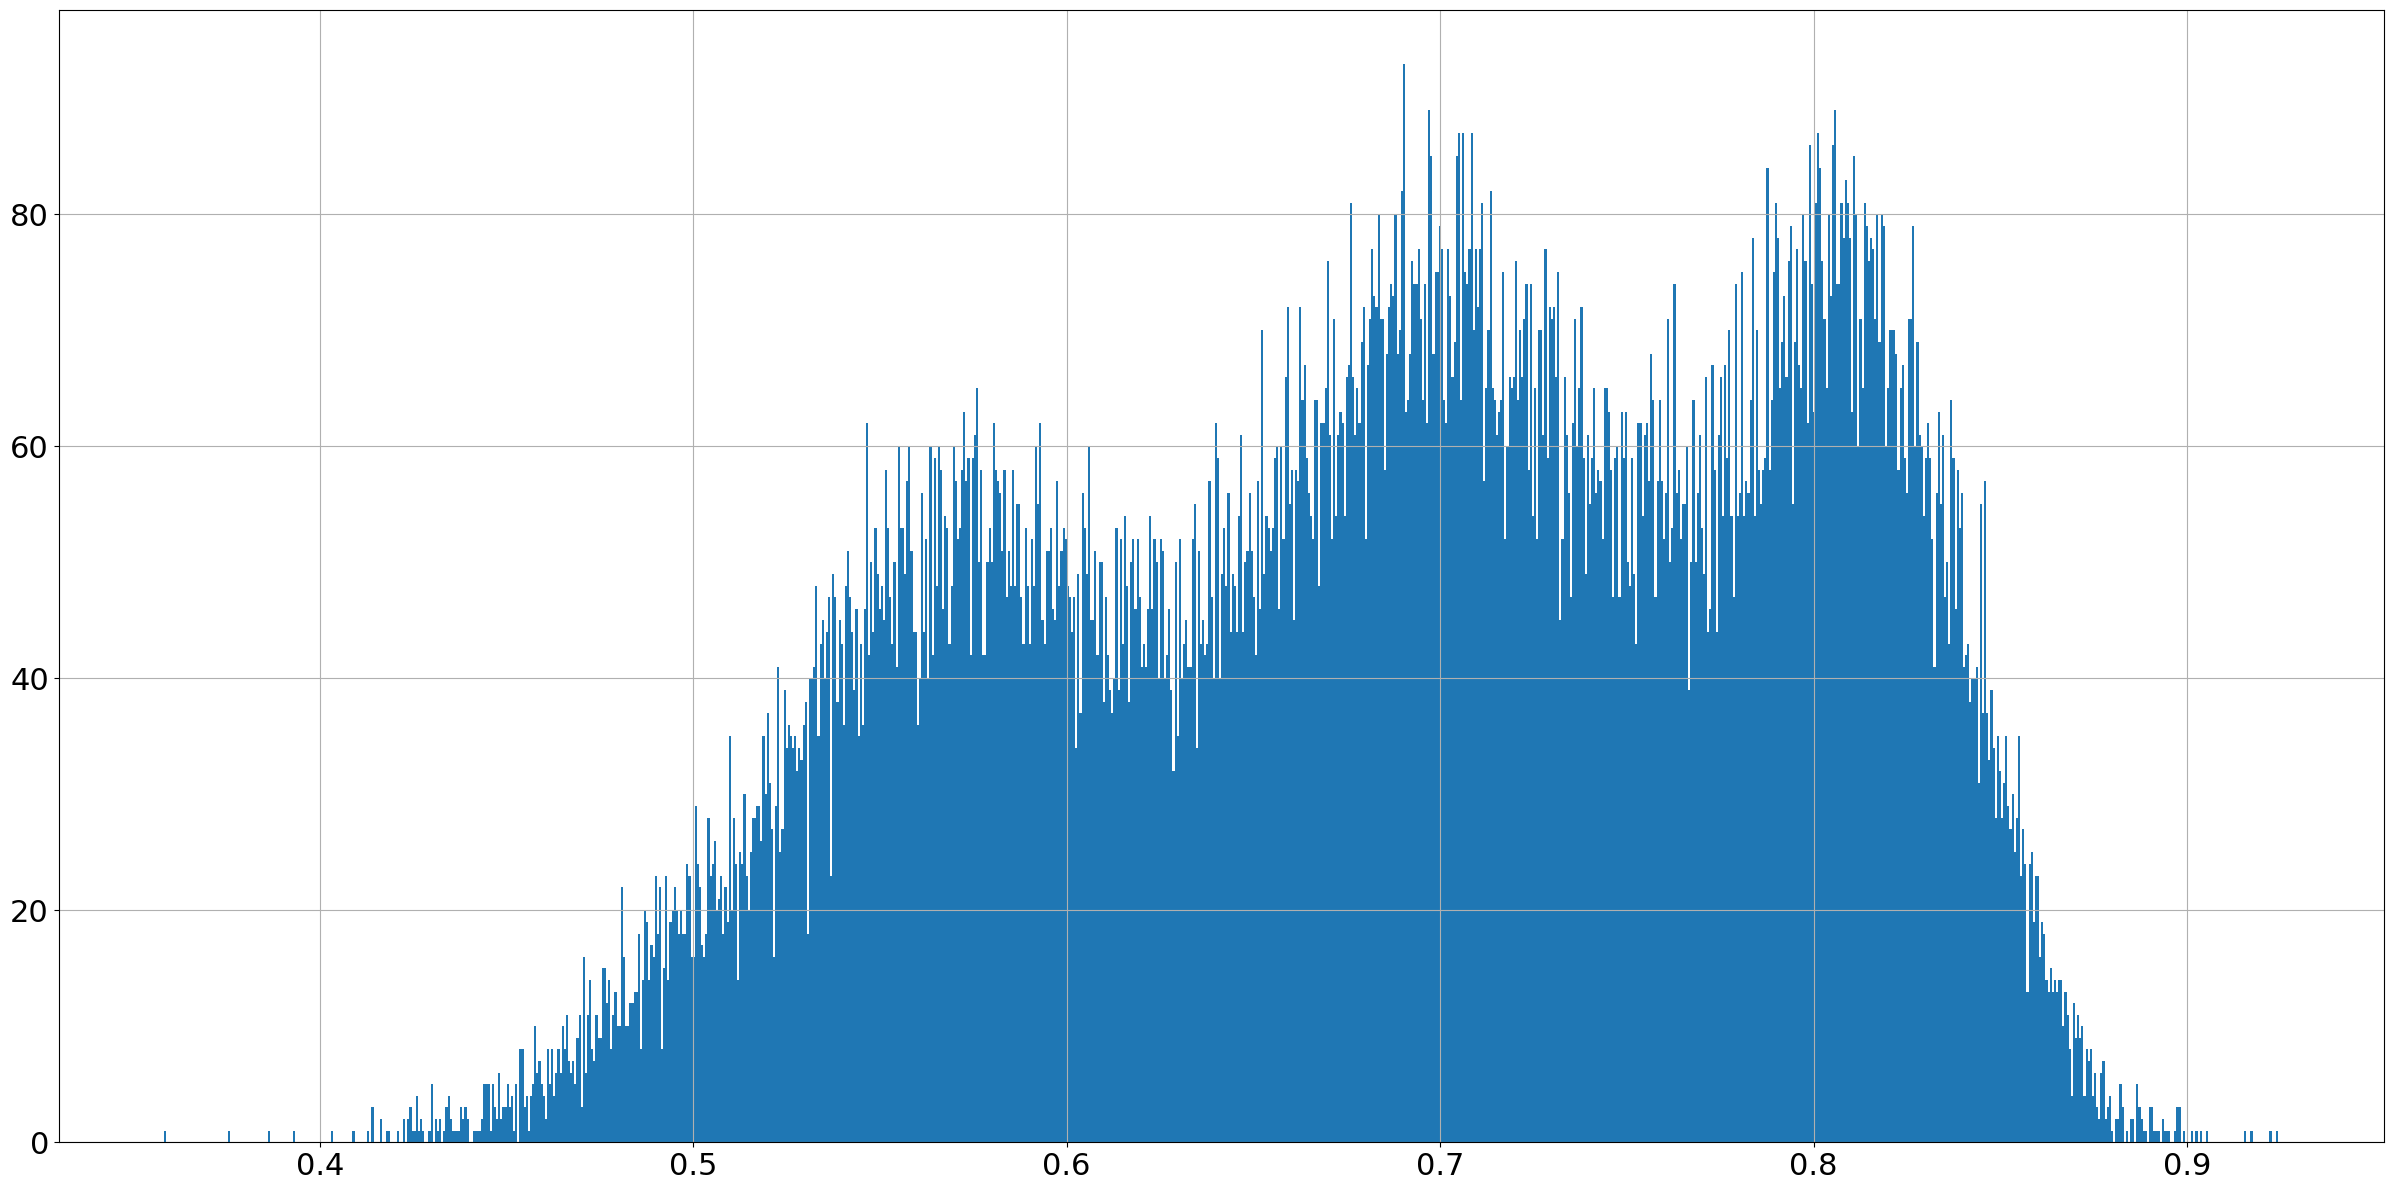

In [71]:
#dataSeries_10_log.observations[dataSeries_10_log.observations<2000].hist(bins=1000)
dataSeries_10_log['mean'][dataSeries_10_log['mean']<2000].hist(bins=1000)

# Uniform, prediction_length=10, context_length=60

In [63]:
from gluonts.distribution import UniformOutput

estimator_10_uni = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=10,
    context_length=60,
    freq='1min',
    trainer = Trainer(
        epochs=50,
        batch_size=25,
        num_batches_per_epoch=100,
        learning_rate=1e-6,#1e-3
        hybridize=False,
        ),
    distr_output = UniformOutput()
)

predictor_10_uni = estimator_10_uni.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:02<?, ?it/s]


GluonTSUserError: Got NaN in first epoch. Try reducing initial learning rate.

In [ ]:
fig_10_uni, ax_10_uni = plt.subplots(1, 1)

def plot_prob_forecasts_10_uni(recur, ts_entry, forecast_entry):
    plot_length = 60+10
#     prediction_intervals = (50.0,98.0)
#     legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    prediction_intervals = [98.0]
#     legend = ["observations", "median prediction"] + [f"{prediction_intervals[0]}% prediction interval"]
    legend = ["observations", "Threshold high", "Threshold low", "Mean"]
#     fig, ax = plt.subplots(1, 1)
#     ts_entry[-plot_length:].plot(ax=ax, color='r')  # plot the time series
    ax_10_uni.plot(ts_entry, color='r', label='observations')
#     print(ts_entry)
#     forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax_10_uni.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.quantile(0.98), color='b', label='Threshold high')
    ax_10_uni.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.quantile(0.02), color='black', label='Threshold low')
    ax_10_uni.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.mean, color='g', label='Mean')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")

peakover_10_uni = []
peakbelow_10_uni = []
peakover_point_10_uni = []
peakbelow_point_10_uni = []
threshold_over_10_uni = []
threshold_below_10_uni = []
mean_10_uni = []

period_10_uni = 3600
    
for recur_10_uni in range(period_10_uni):
    test_ds_10_uni = mk_ds(d[701280-60*1+10*recur_10_uni:701280-60*1+10*recur_10_uni+60*1+10]) #End: 1347422

    forecast_it_10_uni, ts_it_10_uni = make_evaluation_predictions(
        dataset=test_ds_10_uni,  # test dataset
        predictor=predictor_10_uni,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts_10_uni = list(forecast_it_10_uni)
    tss_10_uni = list(ts_it_10_uni)

    # first entry of the time series list
    ts_entry_10_uni = tss_10_uni[0]

    # first entry of test_ds
    test_ds_entry_10_uni = next(iter(test_ds_10_uni))

    # first entry of the forecast list
    forecast_entry_10_uni = forecasts_10_uni[0]
    
    #Compute the threshold above and below the series, and compute the extreme values
    threshold_over_10_uni.extend(forecast_entry_10_uni.quantile(0.98))
    threshold_below_10_uni.extend(forecast_entry_10_uni.quantile(0.02))
    mean_10_uni.extend(forecast_entry_10_uni.mean)
#     print(ts_entry_10_uni)
#     print(len(ts_entry_10_uni))
    for i_10_uni in range(len(forecast_entry_10_uni.quantile(0.98))):
        threshold_high_10_uni = (forecast_entry_10_uni.quantile(0.98))[i_10_uni]
        threshold_low_10_uni = (forecast_entry_10_uni.quantile(0.02))[i_10_uni]
        peakover_10_uni.append(ts_entry_10_uni[0][60+i_10_uni] - threshold_high_10_uni if ts_entry_10_uni[0][60+i_10_uni] - threshold_high_10_uni >= 0 else np.nan)
        peakbelow_10_uni.append(threshold_low_10_uni - ts_entry_10_uni[0][60+i_10_uni] if ts_entry_10_uni[0][60+i_10_uni] - threshold_low_10_uni <= 0 else np.nan)
        peakover_point_10_uni.append(ts_entry_10_uni[0][60+i_10_uni] if ts_entry_10_uni[0][60+i_10_uni] - threshold_high_10_uni >= 0 else np.nan)
        peakbelow_point_10_uni.append(ts_entry_10_uni[0][60+i_10_uni] if ts_entry_10_uni[0][60+i_10_uni] - threshold_low_10_uni <= 0 else np.nan)

    plot_prob_forecasts_10_uni(recur_10_uni, ts_entry_10_uni, forecast_entry_10_uni)

plt.show()

In [ ]:
dataSeries_10_uni = pd.DataFrame({'observations': d.ts[701280:701280+10*period_10_uni], 
                              'forecast_date': d.timestamps[701280:701280+10*period_10_uni],
                              'mean': mean_10_uni,
                              'peakbelow': peakbelow_10_uni,
                              #'peakover': peakover_10_uni,
                              #'threshold_over': threshold_over_10_uni,
                              'threshold_below': threshold_below_10_uni,
                              'mean': mean_10_uni,})
dataSeries_10_uni['forecast_date'] = pd.to_datetime(dataSeries_10_uni['forecast_date'])
dataSeries_10_uni = dataSeries_10_uni.set_index('forecast_date', drop=True)
dataSeries_10_uni['hour'] = dataSeries_10_uni.index.hour
dataSeries_10_uni['dayofweek'] = dataSeries_10_uni.index.dayof?week
dataSeries_10_uni['weekofyear'] = dataSeries_10_uni.index.weekofyear
dataSeries_10_uni['month'] = dataSeries_10_uni.index.month

dataSeries_10_uni

In [ ]:
#dataSeries_10_uni.observations[dataSeries_10_uni.observations<2000].hist(bins=1000)
dataSeries_10_uni['mean'][dataSeries_10_uni['mean']<2000].hist(bins=1000)

# Tail Coverage Evaluation (RLL)

In [ ]:
def RLL():
     

# Tail Coverage Evaluation (Distance from the Uniform Distribution)

In [ ]:
def distan_cal():
    